### Import libraries

In [3]:
import seaborn as sns
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import zipfile 
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import random
import scipy.stats as stats 
import re
from datetime import datetime, date
import datetime as dt
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from numpy.linalg import svd
from scipy.spatial import distance_matrix
from scipy.stats import chi2
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
import pmdarima as pm


'''This has to be installed to run Self-Organizing Maps section'''
# install sompy (use our forked version - the original one has visualization bugs)
#!conda install git
#!pip install -U git+https://github.com/joaopfonseca/SOMPY.git
# IF THIS IT TAKING TOO LONG, TRY TO INSTALL IT FROM THE ANACONDA PROMPT
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView


%matplotlib inline
%config InlineBackend.figure_format = 'retina' #better quality of visualisations

import warnings
warnings.filterwarnings('ignore')
import logging 
logging.getLogger('matplotlib.font_manager').disable = True

### Load and reduce the size of the df to be able to manipulate it

In [3]:
zf = zipfile.ZipFile('/Users/rui.soromenho/Downloads/NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv.zip') 

In [4]:
dtype_dict = {
    'ProductFamily_ID':'category',
    'ProductCategory_ID':'category',
    'ProductBrand_ID':'category',
    'ProductName_ID':'category',
    'ProductPackSKU_ID':'category',
    'Point-of-Sale_ID':'category',
    'Measures':'category',
    'Value':'float32'
}

In [5]:
def reduce_memory(_df):
    # keeping only the number of the ID for all the varaibles
    cols = ['ProductFamily_ID', 'ProductCategory_ID', 'ProductBrand_ID','ProductName_ID', 'ProductPackSKU_ID', 'Point-of-Sale_ID']
    for col in cols:
        _df[col]=_df[col].str.replace(r"[^0-9]", "",regex=True)
    # splitting the chunk-dataset in 2, one for the record with quantity and one for price
    df_units = _df[_df['Measures'] == "Sell-out units"]
    df_values = _df[_df['Measures'] == "Sell-out values"]
    # joining the quantity and price in the same record
    target_columns = ['ProductFamily_ID', 'ProductCategory_ID', 'ProductBrand_ID','ProductName_ID', 'ProductPackSKU_ID', 'Point-of-Sale_ID', 'Date']
    df_join = pd.merge(df_units,df_values,on = target_columns)
    df_join.drop(['Measures_x','Measures_y'],axis=1,inplace=True)
    df_join.rename(columns={'Value_x':'Quantity','Value_y':'Total_Sales'},inplace=True)
    return df_join

In [6]:
i = 0
for chunk in pd.read_csv(zf.open('NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv'),dtype=dtype_dict,chunksize=2000000):  
    processed_df = reduce_memory(chunk)
    if i == 0:
        print(i)
        result = processed_df
        i +=1
    else:
        print(i)
        i +=1
        result = pd.concat([result,processed_df],ignore_index = True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


In [8]:
df = result.copy()

In [8]:
df.head()

ProductFamily_ID ProductCategory_ID ProductBrand_ID ProductName_ID  \
0               16                 11             306            649   
1               16                 11             306            649   
2               16                 11             306            649   
3               16                 11             306            649   
4               16                 11             306            649   

  ProductPackSKU_ID Point-of-Sale_ID        Date  Quantity  Total_Sales  
0              1970                1  2017-03-04       2.0       1540.0  
1              1970                1  2016-05-02       4.0       3080.0  
2              1970                1  2016-10-24       2.0       1540.0  
3              1970                1  2017-10-13       2.0       1620.0  
4              1970                1  2017-10-14       2.0       1620.0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91189734 entries, 0 to 91189733
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ProductFamily_ID    object 
 1   ProductCategory_ID  object 
 2   ProductBrand_ID     object 
 3   ProductName_ID      object 
 4   ProductPackSKU_ID   object 
 5   Point-of-Sale_ID    object 
 6   Date                object 
 7   Quantity            float32
 8   Total_Sales         float32
dtypes: float32(2), object(7)
memory usage: 5.4+ GB


In [183]:
#df.to_csv('BC5_df_smaller')

### Work with a smaller sample of 30 points-of-sale to test how to solve for the first questions

In [18]:
data_sample = df[df['Point-of-Sale_ID'].isin([str(i) for i in range(1,31)])]
data_sample

ProductFamily_ID ProductCategory_ID ProductBrand_ID ProductName_ID  \
0                     16                 11             306            649   
1                     16                 11             306            649   
2                     16                 11             306            649   
3                     16                 11             306            649   
4                     16                 11             306            649   
...                  ...                ...             ...            ...   
7604972                4                 34             279            577   
7604973                4                 34             279            577   
7604974                4                 34             279            577   
7604975                4                 34             279            577   
7604976                4                 34             279            577   

        ProductPackSKU_ID Point-of-Sale_ID        Date  Quantity  Total_Sales  
0                    1970                1  2017-03-04       2.0       1540.0  
1                    1970                1  2016-05-02       4.0       3080.0  
2                    1970                1  2016-10-24       2.0       1540.0  
3                    1970                1  2017-10-13       2.0       1620.0  
4                    1970                1  2017-10-14       2.0       1620.0  
...                   ...              ...         ...       ...          ...  
7604972              1813               30  2016-01-19       1.0        645.0  
7604973              1813               30  2016-01-23       1.0        674.0  
7604974              1813               30  2016-04-21       1.0        645.0  
7604975              1813               30  2016-04-22       1.0        507.0  
7604976              1813               30  2016-04-30       1.0        600.0  

[7604977 rows x 9 columns]

## 1. EDA

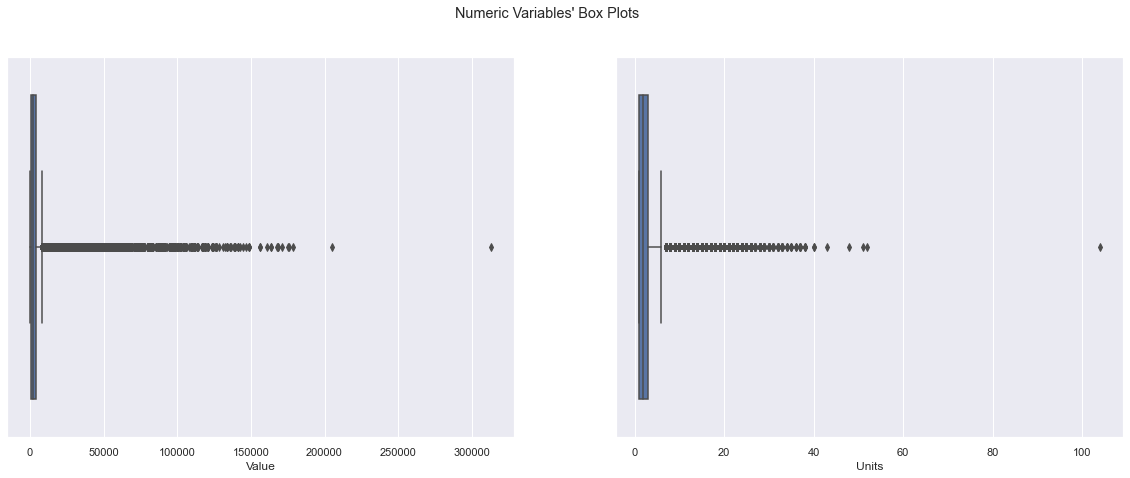

In [87]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), ['Value', 'Units']):
    sns.boxplot(x=data_merged[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"
plt.suptitle(title)
plt.subplots_adjust(wspace=0.2)

plt.show()

<AxesSubplot:xlabel='Family'>

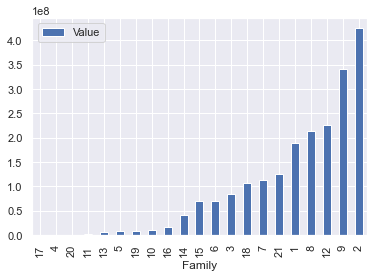

In [96]:
pd.DataFrame(data_merged.groupby('Family')['Value'].sum()).sort_values(by='Value').plot(kind='bar')

<AxesSubplot:xlabel='Family'>

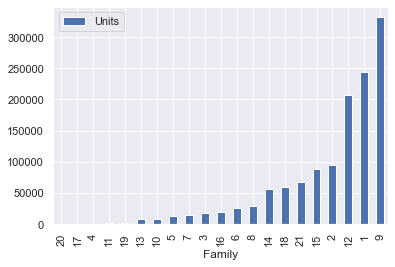

In [99]:
pd.DataFrame(data_merged.groupby('Family')['Units'].sum()).sort_values(by='Units').plot(kind='bar')

## 2. Go through each POS and return the top10 products sold (name, category and family) by quarter


In [ ]:
#look for discontinued products
all_prod = df['ProductName_ID'].unique().tolist()
print(len(all_prod))

valid_prod = df[df['Date']>'2019']['ProductName_ID'].unique().tolist() 
print(len(valid_prod))

desc_prod = []

for i in all_prod:
    if i not in valid_prod:
        desc_prod.append(i)

len(desc_prod)

In [16]:
#list of POS
pos_list = list(data_sample['Point-of-Sale'].unique())

#filter for POS
data_sample[data_sample['Point-of-Sale']=='1']

#groupby product name value
data_sample[data_sample['Point-of-Sale']=='1'].groupby('Name')['Value'].sum()

#return the top10
data_sample[data_sample['Point-of-Sale']=='1'].groupby('Name')['Value'].sum().sort_values(ascending=False)[0:10]


Name
2802    6.096978e+07
738     4.725222e+07
1277    4.175722e+07
847     3.216138e+07
728     2.980294e+07
567     2.772381e+07
1956    2.703116e+07
1059    2.612719e+07
1422    1.918273e+07
2692    1.767277e+07
Name: Value, dtype: float64

In [27]:
#Testing how aggregate based on dates
data_date_index = data_sample.copy()
data_date_index.Date = pd.to_datetime(data_date_index.Date)
data_date_index.set_index('Date', inplace=True)
data_date_index.resample('QS').sum().head()

Value     Units      Day  DayOfWeek  weekday  WeekOfYear  \
Date                                                                          
2016-01-01  4.593560e+08  310946.0  2228606     363376   120942     1083873   
2016-04-01  4.773060e+08  307772.0  2316462     374703   125147     2925318   
2016-07-01  4.784604e+08  301625.0  2357285     381731   125957     4881882   
2016-10-01  4.887756e+08  327022.0  2436468     386844   125324     6947360   
2017-01-01  4.870518e+08  325974.0  2315693     377825   127467     1046136   

              Month  Quarter       Year  
Date                                     
2016-01-01   291102   144561  291434976  
2016-04-01   745329   298006  300390048  
2016-07-01  1192716   447804  300924288  
2016-10-01  1665268   604756  304797024  
2017-01-01   300863   150794  304151498

In [20]:
#Grouping by quarter, point-of-sale and product family
data_sample.Date = pd.to_datetime(data_sample.Date)
pd.DataFrame(data_sample.groupby([pd.Grouper(key='Date', 
                                                   freq='QS'), 
                                        'Point-of-Sale', 
                                        'Family']).Units.sum()).unstack().fillna(0)

Units                                               \
Family                         1     10     11      12     13      14      15   
Date       Point-of-Sale                                                        
2016-01-01 1              6428.0  482.0   26.0  6019.0  317.0  2481.0  3090.0   
           10             3088.0  165.0   40.0  2356.0   61.0  1020.0  1389.0   
           2              4660.0  150.0   20.0  3918.0  159.0  2059.0  2533.0   
           3              6400.0  210.0   67.0  5107.0  220.0  2022.0  3647.0   
           4              7159.0  497.0  142.0  8954.0  339.0  3147.0  3916.0   
...                          ...    ...    ...     ...    ...     ...     ...   
2019-10-01 5              1518.0   57.0   34.0  1873.0   48.0   612.0   450.0   
           6              1479.0   43.0    8.0  1637.0   31.0   490.0   381.0   
           7              1261.0   28.0   11.0  1334.0   23.0   363.0   266.0   
           8              3071.0  100.0   24.0  3741.0   50.0  1063.0   695.0   
           9              2092.0   49.0   26.0  1940.0   38.0   415.0   493.0   

                                               ...                        \
Family                       16    17      18  ...       2    20      21   
Date       Point-of-Sale                       ...                         
2016-01-01 1              711.0   0.0  3029.0  ...  2442.0  26.0  2342.0   
           10             331.0   0.0   849.0  ...  1238.0   9.0   937.0   
           2              731.0   0.0  1513.0  ...  2048.0   2.0  1145.0   
           3              778.0   1.0  1602.0  ...  2806.0   6.0  2063.0   
           4              736.0   0.0  2409.0  ...  2921.0  42.0  4027.0   
...                         ...   ...     ...  ...     ...   ...     ...   
2019-10-01 5              128.0  13.0   497.0  ...   740.0   2.0   549.0   
           6               70.0  25.0   536.0  ...   838.0   2.0   478.0   
           7               45.0   5.0   282.0  ...   445.0   5.0   446.0   
           8              169.0  19.0   660.0  ...  1381.0   8.0  1186.0   
           9               94.0  16.0   462.0  ...   832.0   1.0   709.0   

                                                                            
Family                        3     4      5      6      7      8        9  
Date       Point-of-Sale                                                    
2016-01-01 1              265.0  16.0  648.0  596.0  287.0  395.0   8877.0  
           10             118.0  21.0  393.0  200.0  140.0  222.0   3965.0  
           2              244.0   2.0  465.0  349.0  259.0  355.0   5935.0  
           3              439.0  12.0  713.0  661.0  554.0  477.0  10438.0  
           4              307.0  25.0  744.0  831.0  205.0  529.0  11982.0  
...                         ...   ...    ...    ...    ...    ...      ...  
2019-10-01 5              322.0   4.0  109.0  202.0   54.0  319.0   2861.0  
           6              375.0   9.0  101.0  142.0   42.0  365.0   2442.0  
           7              209.0   4.0   54.0  148.0   42.0  248.0   2306.0  
           8              573.0  12.0  184.0  314.0   87.0  795.0   4753.0  
           9              370.0   3.0  100.0  216.0   65.0  579.0   2978.0  

[160 rows x 21 columns]

In [353]:
#function to add features based on date
def dates_feature_generation(data):
        data['Date'] = pd.to_datetime(data.Date)
        #data['Day'] = data.Date.dt.day.to_list()
        data['DayOfWeek'] = data.Date.dt.dayofweek.to_list()
        data['weekday'] = 1        # Initialize the column with default value of 1
        data.loc[data['DayOfWeek'] == 5, 'weekday'] = 0
        data.loc[data['DayOfWeek'] == 6, 'weekday'] = 0
        data['WeekOfYear'] = data.Date.dt.weekofyear.to_list()
        #data['Month'] = data.Date.dt.month.to_list()
        data['Quarter'] = data.Date.dt.quarter.to_list()
        data['Year'] = data.Date.dt.year.to_list()
        #data['Day'] = data.Date.dt.day.to_list()
        #data['YearQuarter'] = data['Year'].astype('str')+'Q'+data['Quarter'].astype('str')
        
#         data = data.drop(['Date'], axis = 1)
        
        return data

In [31]:
data_date_features

Family Category Brand Name  Pack Point-of-Sale       Date   Value  \
0           16       11   306  649  1970             1 2017-03-04  1540.0   
1           16       11   306  649  1970             1 2016-05-02  3080.0   
2           16       11   306  649  1970             1 2016-10-24  1540.0   
3           16       11   306  649  1970             1 2017-10-13  1620.0   
4           16       11   306  649  1970             1 2017-10-14  1620.0   
...        ...      ...   ...  ...   ...           ...        ...     ...   
2355629      4       34   279  577  1813            10 2018-02-15   700.0   
2355630      4       34   279  577  1813            10 2016-01-18   565.0   
2355631      4       34   279  577  1813            10 2016-01-19   585.0   
2355632      4       34   279  577  1813            10 2016-01-21   585.0   
2355633      4       34   279  577  1813            10 2016-04-20   565.0   

         Units  Day  DayOfWeek  weekday  WeekOfYear  Month  Quarter  Year  \
0          2.0    4          5        0           9      3        1  2017   
1          4.0    2          0        1          18      5        2  2016   
2          2.0   24          0        1          43     10        4  2016   
3          2.0   13          4        1          41     10        4  2017   
4          2.0   14          5        0          41     10        4  2017   
...        ...  ...        ...      ...         ...    ...      ...   ...   
2355629    1.0   15          3        1           7      2        1  2018   
2355630    1.0   18          0        1           3      1        1  2016   
2355631    1.0   19          1        1           3      1        1  2016   
2355632    1.0   21          3        1           3      1        1  2016   
2355633    1.0   20          2        1          16      4        2  2016   

        YearQuarter  
0            2017Q1  
1            2016Q2  
2            2016Q4  
3            2017Q4  
4            2017Q4  
...             ...  
2355629      2018Q1  
2355630      2016Q1  
2355631      2016Q1  
2355632      2016Q1  
2355633      2016Q2  

[2355634 rows x 17 columns]

In [40]:
data_POS_1 = data_date_features[data_date_features['Point-of-Sale']=='1']


pd.DataFrame(data_POS_1.groupby('Name')['Units'].sum()).sort_values(by='Units',ascending=False)



Units
Name         
226   14807.0
1846  12281.0
2412  12268.0
1766  10747.0
1277   9150.0
...       ...
1327      2.0
1326      2.0
1965      2.0
1301      2.0
2187      2.0

[1128 rows x 1 columns]

## 3. Clustering the Points-of-Sale

#### Create variables to describe each Point-of-Sale:
- Total Sales Value
- Total Sales Quantity
- Avg Value per Product
- Growth 2019 vs 2018 vs 2017
- For seasonality: Percentage of Sales Value sold in each quarter?
- For preferences: Percentage of Sales Value coming from each Product Family? Top 10 Categories?
- For sales dispersion across products: Percentage of Value generated by the top 10 Products

In [350]:
df.head()

ProductFamily_ID ProductCategory_ID ProductBrand_ID ProductName_ID  \
0               16                 11             306            649   
1               16                 11             306            649   
2               16                 11             306            649   
3               16                 11             306            649   
4               16                 11             306            649   

  ProductPackSKU_ID Point-of-Sale_ID        Date  Quantity  Total_Sales  
0              1970                1  2017-03-04       2.0       1540.0  
1              1970                1  2016-05-02       4.0       3080.0  
2              1970                1  2016-10-24       2.0       1540.0  
3              1970                1  2017-10-13       2.0       1620.0  
4              1970                1  2017-10-14       2.0       1620.0

In [351]:
#Total Sales Value, Total Sales Quantity, and Avg Value per Product per POS
clustering_data = pd.DataFrame(df.groupby('Point-of-Sale_ID')[['Total_Sales', 'Quantity']].sum())

In [352]:
clustering_data = clustering_data.sort_values(by='Total_Sales', ascending=False)
clustering_data['Value_per_Product'] = np.round((clustering_data['Total_Sales']/clustering_data['Quantity']))
clustering_data

Total_Sales   Quantity  Value_per_Product
Point-of-Sale_ID                                            
292               2.370513e+09  1429510.0             1658.0
92                2.040656e+09  1146164.0             1780.0
280               1.988559e+09  1201625.0             1655.0
78                1.947181e+09  1218702.0             1598.0
272               1.886343e+09  1158511.0             1628.0
...                        ...        ...                ...
167               2.336765e+08   127605.0             1831.0
373               2.314108e+08   146802.0             1576.0
237               2.226688e+08   145743.0             1528.0
221               2.126848e+08   128611.0             1654.0
243               1.475361e+08    91629.0             1610.0

[410 rows x 3 columns]

In [354]:
#YOY growth per POS
df_date_features = dates_feature_generation(df)

In [209]:
df_date_features.head()

ProductFamily_ID ProductCategory_ID ProductBrand_ID ProductName_ID  \
0               16                 11             306            649   
1               16                 11             306            649   
2               16                 11             306            649   
3               16                 11             306            649   
4               16                 11             306            649   

  ProductPackSKU_ID Point-of-Sale_ID       Date  Quantity  Total_Sales  \
0              1970                1 2017-03-04       2.0       1540.0   
1              1970                1 2016-05-02       4.0       3080.0   
2              1970                1 2016-10-24       2.0       1540.0   
3              1970                1 2017-10-13       2.0       1620.0   
4              1970                1 2017-10-14       2.0       1620.0   

   WeekOfYear  Quarter  Year  DayOfWeek  weekday  
0           9        1  2017          5        0  
1          18        2  2016          0        1  
2          43        4  2016          0        1  
3          41        4  2017          4        1  
4          41        4  2017          5        0

In [355]:
df_yearly_sales = pd.DataFrame(df_date_features.groupby(['Point-of-Sale_ID', 'Year'])['Total_Sales'].sum())

In [356]:
df_yearly_sales = df_yearly_sales.unstack()
df_yearly_sales = df_yearly_sales.pct_change(axis='columns')

In [357]:
df_yearly_sales_growth = np.round(df_yearly_sales.iloc[:, 1:]*100, 2)

In [358]:
clustering_data = pd.concat([clustering_data, df_yearly_sales_growth], axis=1)
clustering_data


Total_Sales   Quantity  Value_per_Product  (Total_Sales, 2017)  \
292  2.370513e+09  1429510.0             1658.0                 5.83   
92   2.040656e+09  1146164.0             1780.0                 3.25   
280  1.988559e+09  1201625.0             1655.0                 8.21   
78   1.947181e+09  1218702.0             1598.0                25.99   
272  1.886343e+09  1158511.0             1628.0                 7.88   
..            ...        ...                ...                  ...   
167  2.336765e+08   127605.0             1831.0                -5.91   
373  2.314108e+08   146802.0             1576.0                -5.71   
237  2.226688e+08   145743.0             1528.0                 3.18   
221  2.126848e+08   128611.0             1654.0                 6.59   
243  1.475361e+08    91629.0             1610.0                 1.38   

     (Total_Sales, 2018)  (Total_Sales, 2019)  
292                -0.98            -7.950000  
92                 -4.44           -15.810000  
280                 8.97            -7.360000  
78                  8.04            -9.950000  
272                 9.41           -19.450001  
..                   ...                  ...  
167                 2.48            -3.180000  
373                 5.33           -11.260000  
237                 8.65           -13.520000  
221                13.98           -11.530000  
243                 1.05           -12.400000  

[410 rows x 6 columns]

In [359]:
clustering_data['SalesYoY_2017'] = clustering_data.iloc[:, 3:4]
clustering_data['SalesYoY_2018'] = clustering_data.iloc[:, 4:5]
clustering_data['SalesYoY_2019'] = clustering_data.iloc[:, 5:6]

In [360]:
clustering_data = clustering_data[['Total_Sales', 'Quantity', 'Value_per_Product', 'SalesYoY_2017', 'SalesYoY_2018', 'SalesYoY_2019']]

In [361]:
clustering_data

Total_Sales   Quantity  Value_per_Product  SalesYoY_2017  SalesYoY_2018  \
292  2.370513e+09  1429510.0             1658.0           5.83          -0.98   
92   2.040656e+09  1146164.0             1780.0           3.25          -4.44   
280  1.988559e+09  1201625.0             1655.0           8.21           8.97   
78   1.947181e+09  1218702.0             1598.0          25.99           8.04   
272  1.886343e+09  1158511.0             1628.0           7.88           9.41   
..            ...        ...                ...            ...            ...   
167  2.336765e+08   127605.0             1831.0          -5.91           2.48   
373  2.314108e+08   146802.0             1576.0          -5.71           5.33   
237  2.226688e+08   145743.0             1528.0           3.18           8.65   
221  2.126848e+08   128611.0             1654.0           6.59          13.98   
243  1.475361e+08    91629.0             1610.0           1.38           1.05   

     SalesYoY_2019  
292      -7.950000  
92      -15.810000  
280      -7.360000  
78       -9.950000  
272     -19.450001  
..             ...  
167      -3.180000  
373     -11.260000  
237     -13.520000  
221     -11.530000  
243     -12.400000  

[410 rows x 6 columns]

In [246]:
#quarterly seasonality does not seem to differ across POS
df_quarterly_sales = pd.DataFrame(df.groupby(['Point-of-Sale_ID', 'Quarter'])['Total_Sales'].sum())
df_quarterly_sales = df_quarterly_sales.unstack()
for col in df_quarterly_sales.droplevel(0, axis=1).columns:
    df_quarterly_sales[col] = df_quarterly_sales.droplevel(0, axis=1)[col]/df_quarterly_sales.droplevel(0, axis=1).sum(axis=1)
df_quarterly_sales_percentage = np.round(df_quarterly_sales[[i for i in range(1,5)]], 2)*100
df_quarterly_sales_percentage = df_quarterly_sales_percentage.droplevel(1, axis=1)
df_quarterly_sales_percentage

1     2          3     4
Point-of-Sale_ID                             
1                 25.0  26.0  27.000002  22.0
10                25.0  26.0  26.000000  23.0
100               25.0  25.0  26.000000  23.0
101               26.0  26.0  26.000000  23.0
102               26.0  26.0  26.000000  23.0
...                ...   ...        ...   ...
95                26.0  26.0  25.000000  23.0
96                31.0  23.0  22.000000  23.0
97                22.0  28.0  28.000000  22.0
98                25.0  25.0  27.000002  22.0
99                26.0  26.0  26.000000  23.0

[410 rows x 4 columns]

In [251]:
#monthly seasonality does not seem to differ across POS
df_monthly_sales = pd.DataFrame(df.groupby(['Point-of-Sale_ID', 'Month'])['Total_Sales'].sum())
df_monthly_sales = df_monthly_sales.unstack()
for col in df_monthly_sales.droplevel(0, axis=1).columns:
    df_monthly_sales[col] = df_monthly_sales.droplevel(0, axis=1)[col]/df_monthly_sales.droplevel(0, axis=1).sum(axis=1)
df_monthly_sales = np.round(df_monthly_sales[[i for i in range(1,13)]], 2)*100
df_monthly_sales = df_monthly_sales.droplevel(1, axis=1)
df_monthly_sales

1     2     3    4     5    6     7     8    9     10  \
Point-of-Sale_ID                                                            
1                  9.0   8.0   9.0  8.0   9.0  9.0   9.0  10.0  9.0   9.0   
10                 9.0   8.0   9.0  8.0   9.0  8.0   9.0   9.0  8.0   9.0   
100                9.0   8.0   9.0  8.0   9.0  8.0   9.0   9.0  9.0   9.0   
101                9.0   8.0   9.0  8.0   9.0  8.0   9.0   9.0  9.0   9.0   
102                9.0   8.0   9.0  9.0   9.0  8.0   9.0   9.0  8.0   9.0   
...                ...   ...   ...  ...   ...  ...   ...   ...  ...   ...   
95                 9.0   8.0   9.0  8.0   9.0  9.0   9.0   8.0  8.0   9.0   
96                11.0  10.0  11.0  8.0   8.0  8.0   8.0   7.0  7.0   8.0   
97                 8.0   7.0   7.0  9.0  10.0  9.0  10.0   9.0  9.0  10.0   
98                 9.0   8.0   9.0  8.0   9.0  9.0   9.0   9.0  9.0   9.0   
99                 9.0   8.0   9.0  8.0   9.0  8.0   9.0   9.0  8.0   9.0   

                   11   12  
Point-of-Sale_ID            
1                 6.0  7.0  
10                7.0  6.0  
100               7.0  7.0  
101               7.0  7.0  
102               7.0  7.0  
...               ...  ...  
95                7.0  7.0  
96                7.0  8.0  
97                6.0  6.0  
98                7.0  6.0  
99                6.0  7.0  

[410 rows x 12 columns]

In [362]:
#weekday vs weekend could be interesting
df_week_sales = pd.DataFrame(df.groupby(['Point-of-Sale_ID', 'weekday'])['Total_Sales'].sum())
df_week_sales = df_week_sales.unstack()
for col in df_week_sales.droplevel(0, axis=1).columns:
    df_week_sales[col] = df_week_sales.droplevel(0, axis=1)[col]/df_week_sales.droplevel(0, axis=1).sum(axis=1)
df_week_sales = np.round(df_week_sales[[i for i in range(0,2)]], 2)*100
df_week_sales = df_week_sales.droplevel(1, axis=1)
df_week_sales

0     1
Point-of-Sale_ID            
1                 16.0  84.0
10                10.0  90.0
100               10.0  90.0
101                8.0  92.0
102               13.0  87.0
...                ...   ...
95                10.0  90.0
96                17.0  83.0
97                11.0  89.0
98                10.0  90.0
99                11.0  89.0

[410 rows x 2 columns]

In [363]:
clustering_data = pd.concat([clustering_data, df_week_sales], axis=1)
clustering_data.rename(columns={0:'Weekend_Sales', 1: 'Weekday_Sales'}, inplace=True)

In [364]:
clustering_data = clustering_data.iloc[:,:-2]
clustering_data

Total_Sales   Quantity  Value_per_Product  SalesYoY_2017  SalesYoY_2018  \
292  2.370513e+09  1429510.0             1658.0           5.83          -0.98   
92   2.040656e+09  1146164.0             1780.0           3.25          -4.44   
280  1.988559e+09  1201625.0             1655.0           8.21           8.97   
78   1.947181e+09  1218702.0             1598.0          25.99           8.04   
272  1.886343e+09  1158511.0             1628.0           7.88           9.41   
..            ...        ...                ...            ...            ...   
167  2.336765e+08   127605.0             1831.0          -5.91           2.48   
373  2.314108e+08   146802.0             1576.0          -5.71           5.33   
237  2.226688e+08   145743.0             1528.0           3.18           8.65   
221  2.126848e+08   128611.0             1654.0           6.59          13.98   
243  1.475361e+08    91629.0             1610.0           1.38           1.05   

     SalesYoY_2019  
292      -7.950000  
92      -15.810000  
280      -7.360000  
78       -9.950000  
272     -19.450001  
..             ...  
167      -3.180000  
373     -11.260000  
237     -13.520000  
221     -11.530000  
243     -12.400000  

[410 rows x 6 columns]

#### Concentration of sales in Top10 Products

In [365]:
sales_by_product = pd.DataFrame(df.groupby('ProductName_ID')['Total_Sales'].sum()).sort_values(by='Total_Sales', ascending=False)

In [366]:
df_top_products = df[df['ProductName_ID'].isin(sales_by_product.head(10).index)]
sales_top_products = pd.DataFrame(df_top_products.groupby('Point-of-Sale_ID')['Total_Sales'].sum())
sales_top_products = sales_top_products.rename(columns={'Total_Sales':'Top10_Sales'})
clustering_data = pd.concat([clustering_data, sales_top_products], axis=1)
clustering_data['Top10_Sales_Percentage'] = np.round(clustering_data['Top10_Sales']/clustering_data['Total_Sales'], 4)*100

In [367]:
clustering_data

Total_Sales   Quantity  Value_per_Product  SalesYoY_2017  SalesYoY_2018  \
292  2.370513e+09  1429510.0             1658.0           5.83          -0.98   
92   2.040656e+09  1146164.0             1780.0           3.25          -4.44   
280  1.988559e+09  1201625.0             1655.0           8.21           8.97   
78   1.947181e+09  1218702.0             1598.0          25.99           8.04   
272  1.886343e+09  1158511.0             1628.0           7.88           9.41   
..            ...        ...                ...            ...            ...   
167  2.336765e+08   127605.0             1831.0          -5.91           2.48   
373  2.314108e+08   146802.0             1576.0          -5.71           5.33   
237  2.226688e+08   145743.0             1528.0           3.18           8.65   
221  2.126848e+08   128611.0             1654.0           6.59          13.98   
243  1.475361e+08    91629.0             1610.0           1.38           1.05   

     SalesYoY_2019  Top10_Sales  Top10_Sales_Percentage  
292      -7.950000  639809664.0               26.990000  
92      -15.810000  558232064.0               27.360001  
280      -7.360000  685687296.0               34.480000  
78       -9.950000  621672704.0               31.930000  
272     -19.450001  615547072.0               32.630001  
..             ...          ...                     ...  
167      -3.180000  103321496.0               44.220001  
373     -11.260000   74322496.0               32.120003  
237     -13.520000   70328384.0               31.580002  
221     -11.530000   77069424.0               36.239998  
243     -12.400000   43003600.0               29.150000  

[410 rows x 8 columns]

<AxesSubplot:xlabel='ProductFamily_ID'>

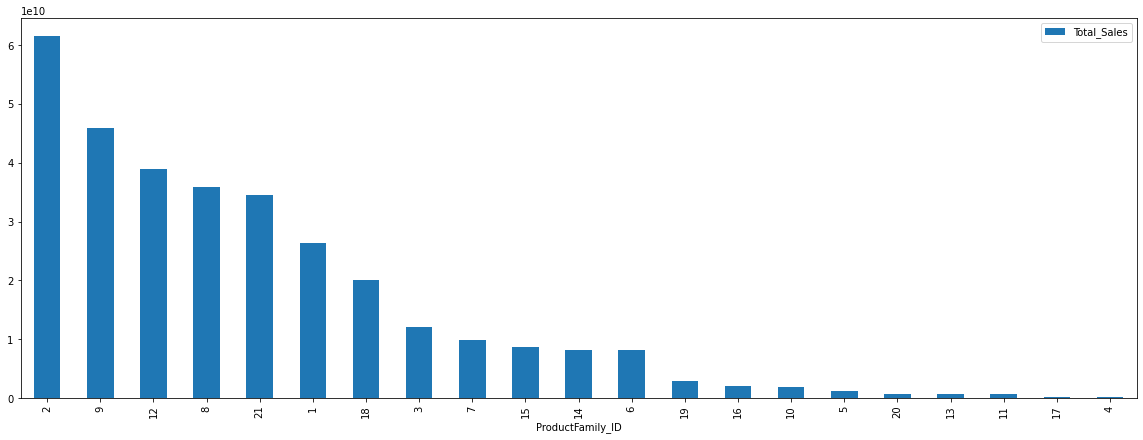

In [319]:
pd.DataFrame(df.groupby(['Point-of-Sales','ProductFamily_ID'])['Total_Sales'].sum()).sort_values(by='Total_Sales', 
                                                                                ascending=False).plot(kind='bar',
                                                                                                     figsize=(20,7))

In [321]:
pd.DataFrame(df.groupby(['Point-of-Sale_ID','ProductFamily_ID'])['Total_Sales'].sum()).unstack()

Total_Sales                                       \
ProductFamily_ID            1           10         11           12   
Point-of-Sale_ID                                                     
1                  80371664.0  6922791.000   972478.0  104689096.0   
10                 36112764.0  1775854.000   516182.0   39663624.0   
100               124252360.0  4850180.000  1639898.0  122106896.0   
101                58612948.0  1977409.000   490175.0   53367956.0   
102               107831872.0  4692052.000   907567.0  133920600.0   
...                       ...          ...        ...          ...   
95                 53695884.0  4308528.000   481096.0   78094920.0   
96                 29137786.0  2401076.000   499822.0   47028968.0   
97                 32549696.0  2097841.000   462641.0   46798312.0   
98                 49314148.0  1546994.625   886657.0   41359416.0   
99                 76564648.0  3001973.750   715308.0   70184968.0   

                                                                              \
ProductFamily_ID           13          14          15          16         17   
Point-of-Sale_ID                                                               
1                 2685600.000  21670506.0  30273254.0  6693937.00   377177.0   
10                 527902.000   7252342.0  10787483.0  2548269.00    13017.0   
100               2758017.000  28510550.0  33493612.0  7058699.00   608377.0   
101               1459186.625  16035294.0  17929776.0  3340369.25   127290.0   
102               1654209.000  22814380.0  28932670.0  6593630.00  1032975.5   
...                       ...         ...         ...         ...        ...   
95                1567232.000  17871172.0  16710157.0  4269846.00   186860.0   
96                 844784.500   9732215.0  10116097.0  3034518.50   153409.0   
97                 750837.000   9113698.0   9588456.0  2223588.00   100963.0   
98                 834012.000   9520150.0  15373590.0  3473752.00   121411.0   
99                1451084.000  19669542.0  24558744.0  6257463.00   149132.0   

                              ...                                       \
ProductFamily_ID          18  ...            2         20           21   
Point-of-Sale_ID              ...                                        
1                 70038472.0  ...  180931760.0   368610.0   92319448.0   
10                22778602.0  ...   93190928.0   135030.0   26357604.0   
100               70540856.0  ...  259718800.0   935947.0  101393984.0   
101               30110440.0  ...  114105760.0   822574.0   54427316.0   
102               58323188.0  ...  246159936.0  1407816.0   86390904.0   
...                      ...  ...          ...        ...          ...   
95                33061344.0  ...  124319408.0   405820.0   65933208.0   
96                20386478.0  ...   65572264.0   405138.0   39309900.0   
97                26332586.0  ...   79824512.0   139858.0   23983256.0   
98                23974900.0  ...  108050472.0   118362.0   36280768.0   
99                37799408.0  ...  185938784.0   322784.0   71992848.0   

                                                                            \
ProductFamily_ID           3         4           5           6           7   
Point-of-Sale_ID                                                             
1                 50499980.0  360248.0  4599321.50  24687606.0  27031160.0   
10                22388898.0  206692.0  2804685.00  11784595.0  17793136.0   
100               65808992.0  714587.0  8035358.00  43501720.0  22266148.0   
101               34905784.0  199444.0  2765232.75  14011751.0   7597015.0   
102               76900304.0  544481.0  4039382.00  32624438.0  35198552.0   
...                      ...       ...         ...         ...         ...   
95                23488824.0  332471.0  2642220.00  13654228.0  21238468.0   
96                10440312.0  156295.0  1650958.00  10683396.0  12798186.0   
97                154

In [368]:
#Share of Sales Value by Product Family
df_family_sales = pd.DataFrame(df.groupby(['Point-of-Sale_ID', 'ProductFamily_ID'])['Total_Sales'].sum())
df_family_sales = df_family_sales.unstack()
for col in df_family_sales.droplevel(0, axis=1).columns:
    df_family_sales[col] = df_family_sales.droplevel(0, axis=1)[col]/df_family_sales.droplevel(0, axis=1).sum(axis=1)
df_family_sales = np.round(df_family_sales[['2','9','12','8','21','1','18','3','7','15','14','6']], 2)*100
df_family_sales = df_family_sales.droplevel(1, axis=1)
df_family_sales

2          9    12          8    21     1   18    3    7  \
Point-of-Sale_ID                                                                
1                 18.0  15.000001  11.0  12.000000   9.0   8.0  7.0  5.0  3.0   
10                22.0  15.000001   9.0  15.000001   6.0   8.0  5.0  5.0  4.0   
100               20.0  18.000000   9.0  12.000000   8.0   9.0  5.0  5.0  2.0   
101               19.0  16.000000   9.0  13.000000   9.0  10.0  5.0  6.0  1.0   
102               21.0  15.000001  12.0  10.000000   8.0   9.0  5.0  7.0  3.0   
...                ...        ...   ...        ...   ...   ...  ...  ...  ...   
95                20.0  15.000001  13.0   8.000000  11.0   9.0  5.0  4.0  3.0   
96                19.0  16.000000  13.0   8.000000  11.0   8.0  6.0  3.0  4.0   
97                22.0  16.000000  13.0   8.000000   7.0   9.0  7.0  4.0  3.0   
98                20.0  19.000000   8.0  17.000000   7.0   9.0  4.0  6.0  3.0   
99                22.0  18.000000   8.0  13.000000   8.0   9.0  4.0  5.0  3.0   

                   15   14    6  
Point-of-Sale_ID                 
1                 3.0  2.0  3.0  
10                3.0  2.0  3.0  
100               3.0  2.0  3.0  
101               3.0  3.0  2.0  
102               3.0  2.0  3.0  
...               ...  ...  ...  
95                3.0  3.0  2.0  
96                3.0  3.0  3.0  
97                3.0  3.0  3.0  
98                3.0  2.0  2.0  
99                3.0  2.0  2.0  

[410 rows x 12 columns]

In [369]:
clustering_data = pd.concat([clustering_data, df_family_sales], axis=1)
clustering_data

Total_Sales   Quantity  Value_per_Product  SalesYoY_2017  SalesYoY_2018  \
292  2.370513e+09  1429510.0             1658.0           5.83          -0.98   
92   2.040656e+09  1146164.0             1780.0           3.25          -4.44   
280  1.988559e+09  1201625.0             1655.0           8.21           8.97   
78   1.947181e+09  1218702.0             1598.0          25.99           8.04   
272  1.886343e+09  1158511.0             1628.0           7.88           9.41   
..            ...        ...                ...            ...            ...   
167  2.336765e+08   127605.0             1831.0          -5.91           2.48   
373  2.314108e+08   146802.0             1576.0          -5.71           5.33   
237  2.226688e+08   145743.0             1528.0           3.18           8.65   
221  2.126848e+08   128611.0             1654.0           6.59          13.98   
243  1.475361e+08    91629.0             1610.0           1.38           1.05   

     SalesYoY_2019  Top10_Sales  Top10_Sales_Percentage     2          9  \
292      -7.950000  639809664.0               26.990000  13.0  13.000000   
92      -15.810000  558232064.0               27.360001  16.0  15.000001   
280      -7.360000  685687296.0               34.480000  19.0  14.000000   
78       -9.950000  621672704.0               31.930000  21.0  14.000000   
272     -19.450001  615547072.0               32.630001  18.0  14.000000   
..             ...          ...                     ...   ...        ...   
167      -3.180000  103321496.0               44.220001  24.0  13.000000   
373     -11.260000   74322496.0               32.120003  22.0  14.000000   
237     -13.520000   70328384.0               31.580002  17.0  15.000001   
221     -11.530000   77069424.0               36.239998  21.0  12.000000   
243     -12.400000   43003600.0               29.150000  22.0  16.000000   

            12     8    21     1   18    3    7   15   14    6  
292  13.000000   9.0  19.0   9.0  5.0  2.0  4.0  3.0  3.0  2.0  
92    9.000000   8.0  28.0   7.0  4.0  3.0  3.0  1.0  2.0  2.0  
280  12.000000  11.0  10.0   9.0  7.0  3.0  4.0  2.0  3.0  2.0  
78   13.000000   8.0  11.0   8.0  6.0  4.0  3.0  3.0  2.0  3.0  
272  12.000000  11.0   9.0   9.0  7.0  4.0  4.0  3.0  3.0  2.0  
..         ...   ...   ...   ...  ...  ...  ...  ...  ...  ...  
167   9.000000  17.0   3.0   5.0  8.0  4.0  9.0  2.0  2.0  2.0  
373  15.000001  10.0   5.0  10.0  8.0  3.0  1.0  2.0  3.0  3.0  
237  12.000000  16.0   6.0   8.0  9.0  4.0  2.0  2.0  3.0  2.0  
221  12.000000  17.0   4.0   8.0  9.0  4.0  2.0  2.0  2.0  3.0  
243  13.000000  12.0   3.0  10.0  6.0  3.0  2.0  5.0  3.0  1.0  

[410 rows x 20 columns]

In [452]:
clustering_test = clustering_data.drop(columns=['Top10_Sales', 'Quantity', 
                                                'SalesYoY_2017', 'SalesYoY_2019', '3', '7', '15', '14', '6'])

In [453]:
metric_features = clustering_test.columns.to_list()

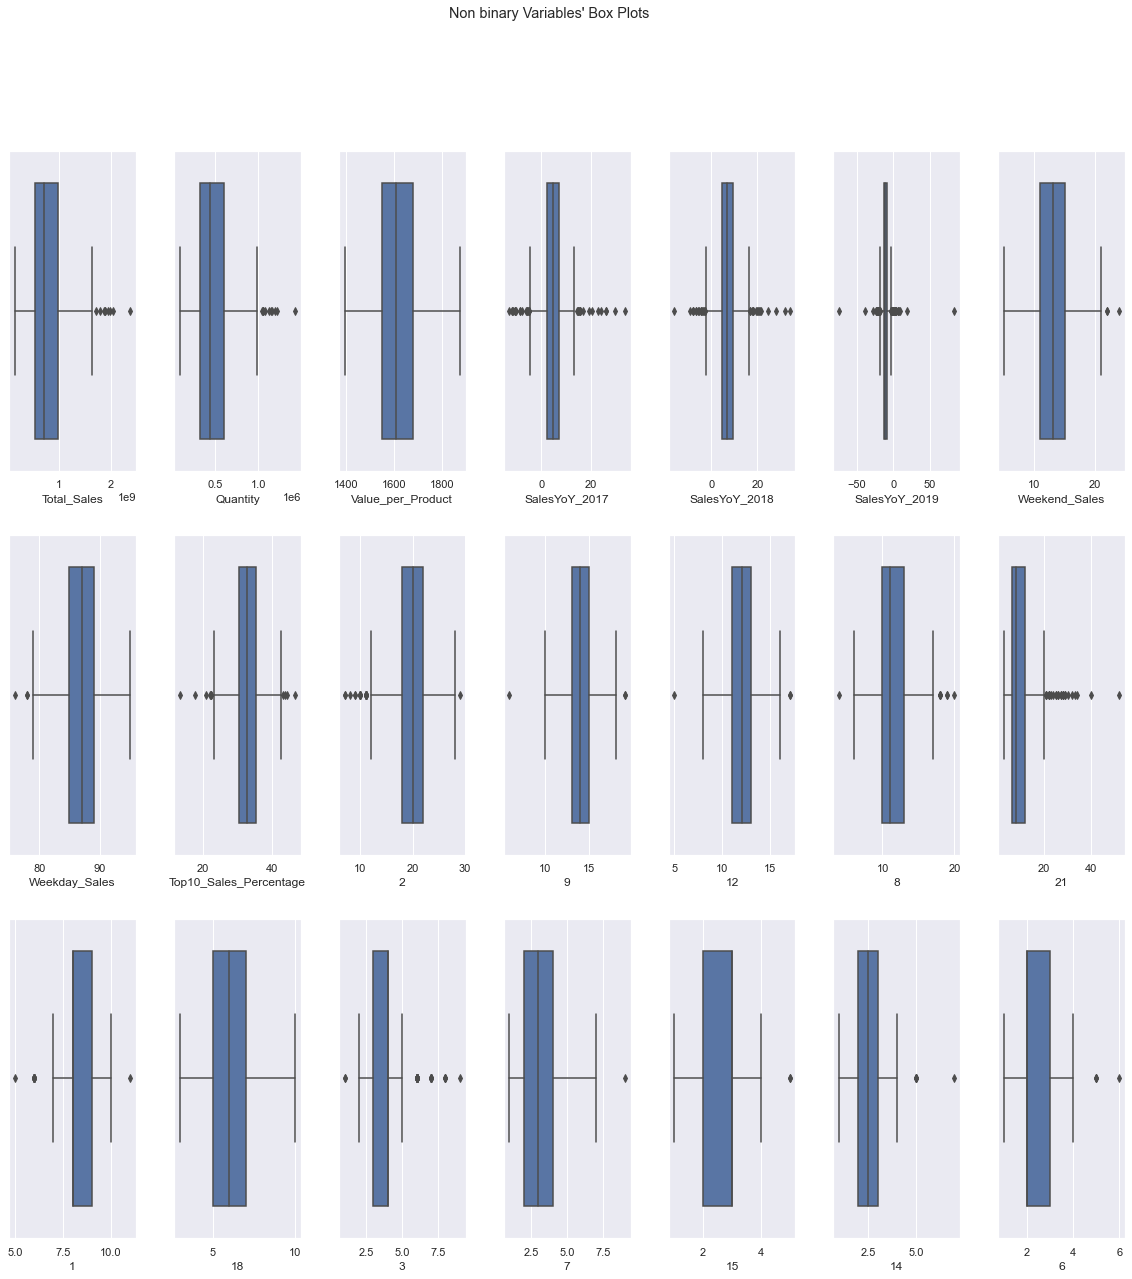

In [338]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(20, 20))

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=clustering_test[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Non binary Variables' Box Plots"
plt.suptitle(title)
plt.subplots_adjust(wspace=0.3)

plt.show()

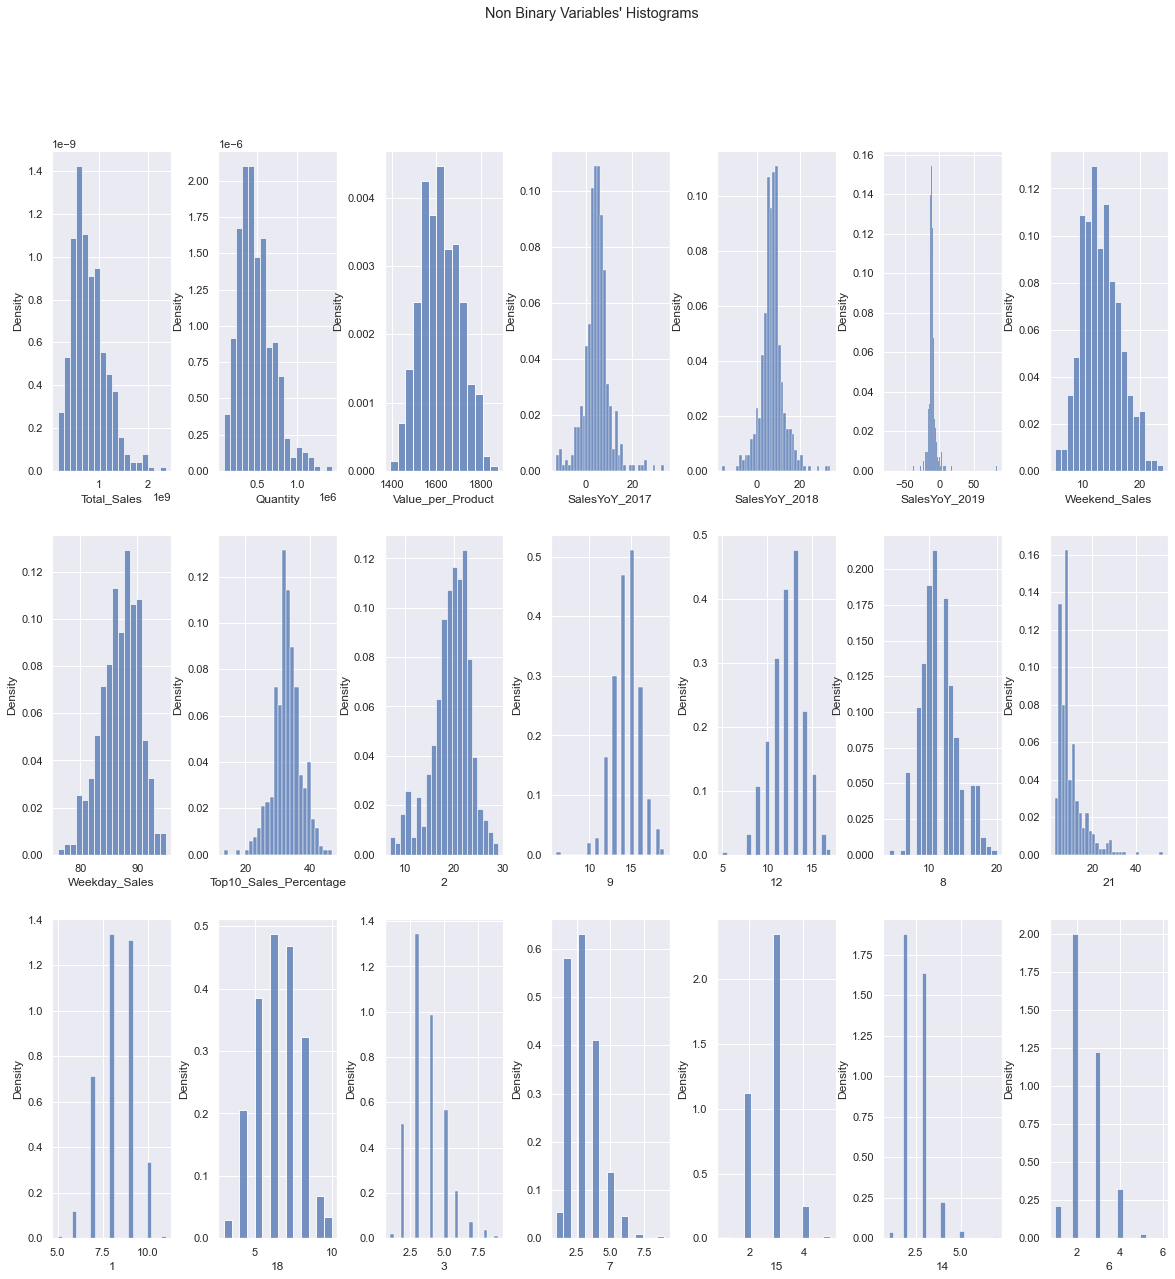

In [340]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(20, 20))

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.histplot(x=clustering_test[feat], stat='density', common_norm=False, ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Non Binary Variables' Histograms"
plt.suptitle(title)
plt.subplots_adjust(wspace=0.4)

plt.show()

interval columns not set, guessing: ['Total_Sales', 'Quantity', 'Value_per_Product', 'SalesYoY_2017', 'SalesYoY_2018', 'SalesYoY_2019', 'Weekend_Sales', 'Top10_Sales_Percentage', '2', '9', '12', '8', '21', '1', '18', '3', '7', '15', '14', '6']
interval columns not set, guessing: ['Total_Sales', 'Quantity', 'Value_per_Product', 'SalesYoY_2017', 'SalesYoY_2018', 'SalesYoY_2019', 'Weekend_Sales', 'Top10_Sales_Percentage', '2', '9', '12', '8', '21', '1', '18', '3', '7', '15', '14', '6']


locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x466b7fbe0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x466b7fbe0> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


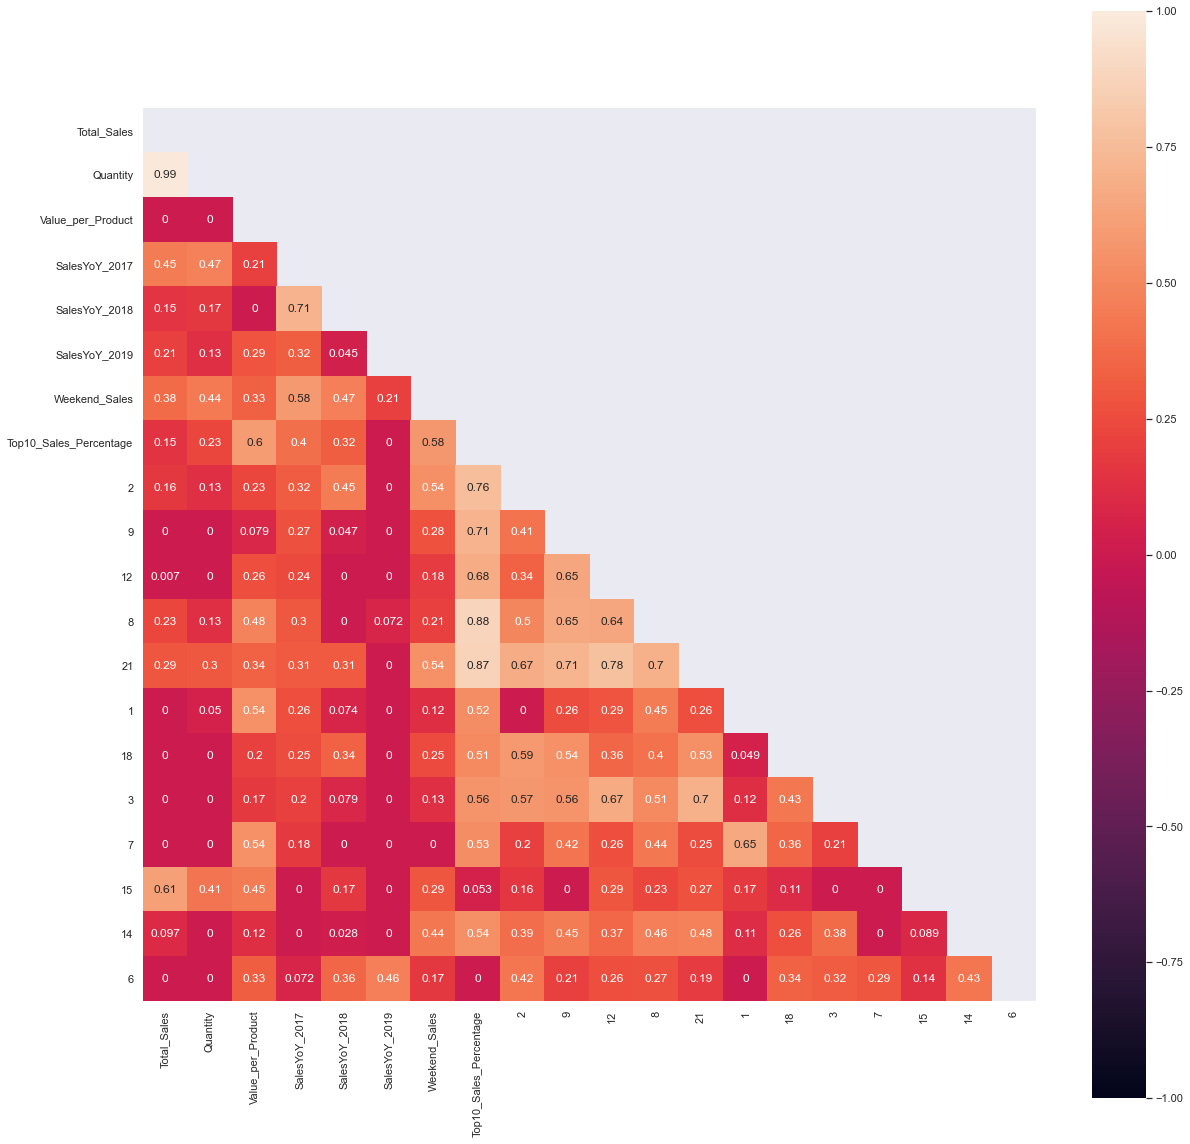

In [346]:
import phik
#Plot correlation matrix
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

mask = np.zeros_like(clustering_test.phik_matrix(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(clustering_test.phik_matrix(),vmin=-1, vmax=1, square=True, annot=True, mask=mask)

plt.show()

In [454]:
def Scaler(data, scaler):
    scaler = scaler
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    return round(data_scaled, 4)

data_MinMax = Scaler(clustering_test, MinMaxScaler())
data_standard = Scaler(clustering_test, StandardScaler())

In [348]:
data_MinMax

Total_Sales  Quantity  Value_per_Product  SalesYoY_2017  SalesYoY_2018  \
292       1.0000    1.0000             0.5498         0.4006         0.2997   
92        0.8516    0.7882             0.8029         0.3451         0.2302   
280       0.8282    0.8297             0.5436         0.4518         0.4994   
78        0.8096    0.8424             0.4253         0.8343         0.4807   
272       0.7822    0.7974             0.4876         0.4447         0.5082   
..           ...       ...                ...            ...            ...   
167       0.0388    0.0269             0.9087         0.1480         0.3691   
373       0.0377    0.0412             0.3797         0.1523         0.4263   
237       0.0338    0.0404             0.2801         0.3436         0.4930   
221       0.0293    0.0276             0.5415         0.4170         0.6000   
243       0.0000    0.0000             0.4502         0.3049         0.3404   

     SalesYoY_2019  Weekend_Sales  Top10_Sales_Percentage       2       9  \
292         0.4187         0.7895                  0.4094  0.2727  0.5385   
92          0.3686         0.1579                  0.4205  0.4091  0.6923   
280         0.4224         0.4211                  0.6344  0.5455  0.6154   
78          0.4059         0.7895                  0.5578  0.6364  0.6154   
272         0.3455         0.6842                  0.5789  0.5000  0.6154   
..             ...            ...                     ...     ...     ...   
167         0.4490         0.2632                  0.9270  0.7727  0.5385   
373         0.3976         0.2105                  0.5635  0.6818  0.6154   
237         0.3832         0.1053                  0.5473  0.4545  0.6923   
221         0.3959         0.3158                  0.6873  0.6364  0.4615   
243         0.3903         0.2105                  0.4743  0.6818  0.7692   

         12       8      21       1      18      3      7    15      14    6  
292  0.6667  0.3125  0.3265  0.6667  0.2857  0.125  0.375  0.50  0.3333  0.2  
92   0.3333  0.2500  0.5102  0.3333  0.1429  0.250  0.250  0.00  0.1667  0.2  
280  0.5833  0.4375  0.1429  0.6667  0.5714  0.250  0.375  0.25  0.3333  0.2  
78   0.6667  0.2500  0.1633  0.5000  0.4286  0.375  0.250  0.50  0.1667  0.4  
272  0.5833  0.4375  0.1224  0.6667  0.5714  0.375  0.375  0.50  0.3333  0.2  
..      ...     ...     ...     ...     ...    ...    ...   ...     ...  ...  
167  0.3333  0.8125  0.0000  0.0000  0.7143  0.375  1.000  0.25  0.1667  0.2  
373  0.8333  0.3750  0.0408  0.8333  0.7143  0.250  0.000  0.25  0.3333  0.4  
237  0.5833  0.7500  0.0612  0.5000  0.8571  0.375  0.125  0.25  0.3333  0.2  
221  0.5833  0.8125  0.0204  0.5000  0.8571  0.375  0.125  0.25  0.1667  0.4  
243  0.6667  0.5000  0.0000  0.8333  0.4286  0.250  0.125  1.00  0.3333  0.0  

[410 rows x 20 columns]

In [352]:
df_pca = data_MinMax.copy()
#df_pca.drop(['Income', 'Freq', 'LTV'], inplace=True, axis=1) 

pca = PCA()
pca_feat = pca.fit_transform(df_pca)

In [353]:
# Output PCA table
pca_table =pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)
pca_table

Eigenvalue  Difference  Proportion  Cumulative
1     0.093591    0.000000    0.211325    0.211325
2     0.065496   -0.028095    0.147887    0.359213
3     0.053630   -0.011866    0.121095    0.480308
4     0.042897   -0.010733    0.096861    0.577169
5     0.033048   -0.009849    0.074621    0.651790
6     0.027246   -0.005802    0.061521    0.713311
7     0.023258   -0.003988    0.052516    0.765827
8     0.017572   -0.005686    0.039676    0.805503
9     0.014674   -0.002897    0.033134    0.838638
10    0.014102   -0.000573    0.031841    0.870479
11    0.012865   -0.001236    0.029049    0.899528
12    0.010038   -0.002827    0.022665    0.922193
13    0.008839   -0.001199    0.019957    0.942150
14    0.007936   -0.000903    0.017919    0.960069
15    0.007340   -0.000596    0.016574    0.976642
16    0.006300   -0.001040    0.014226    0.990869
17    0.002117   -0.004183    0.004781    0.995650
18    0.001621   -0.000497    0.003660    0.999310
19    0.000276   -0.001345    0.000622    0.999932
20    0.000030   -0.000245    0.000068    1.000000

The minimum number of PCA to obtain at least 0.8 variance explained is:  7


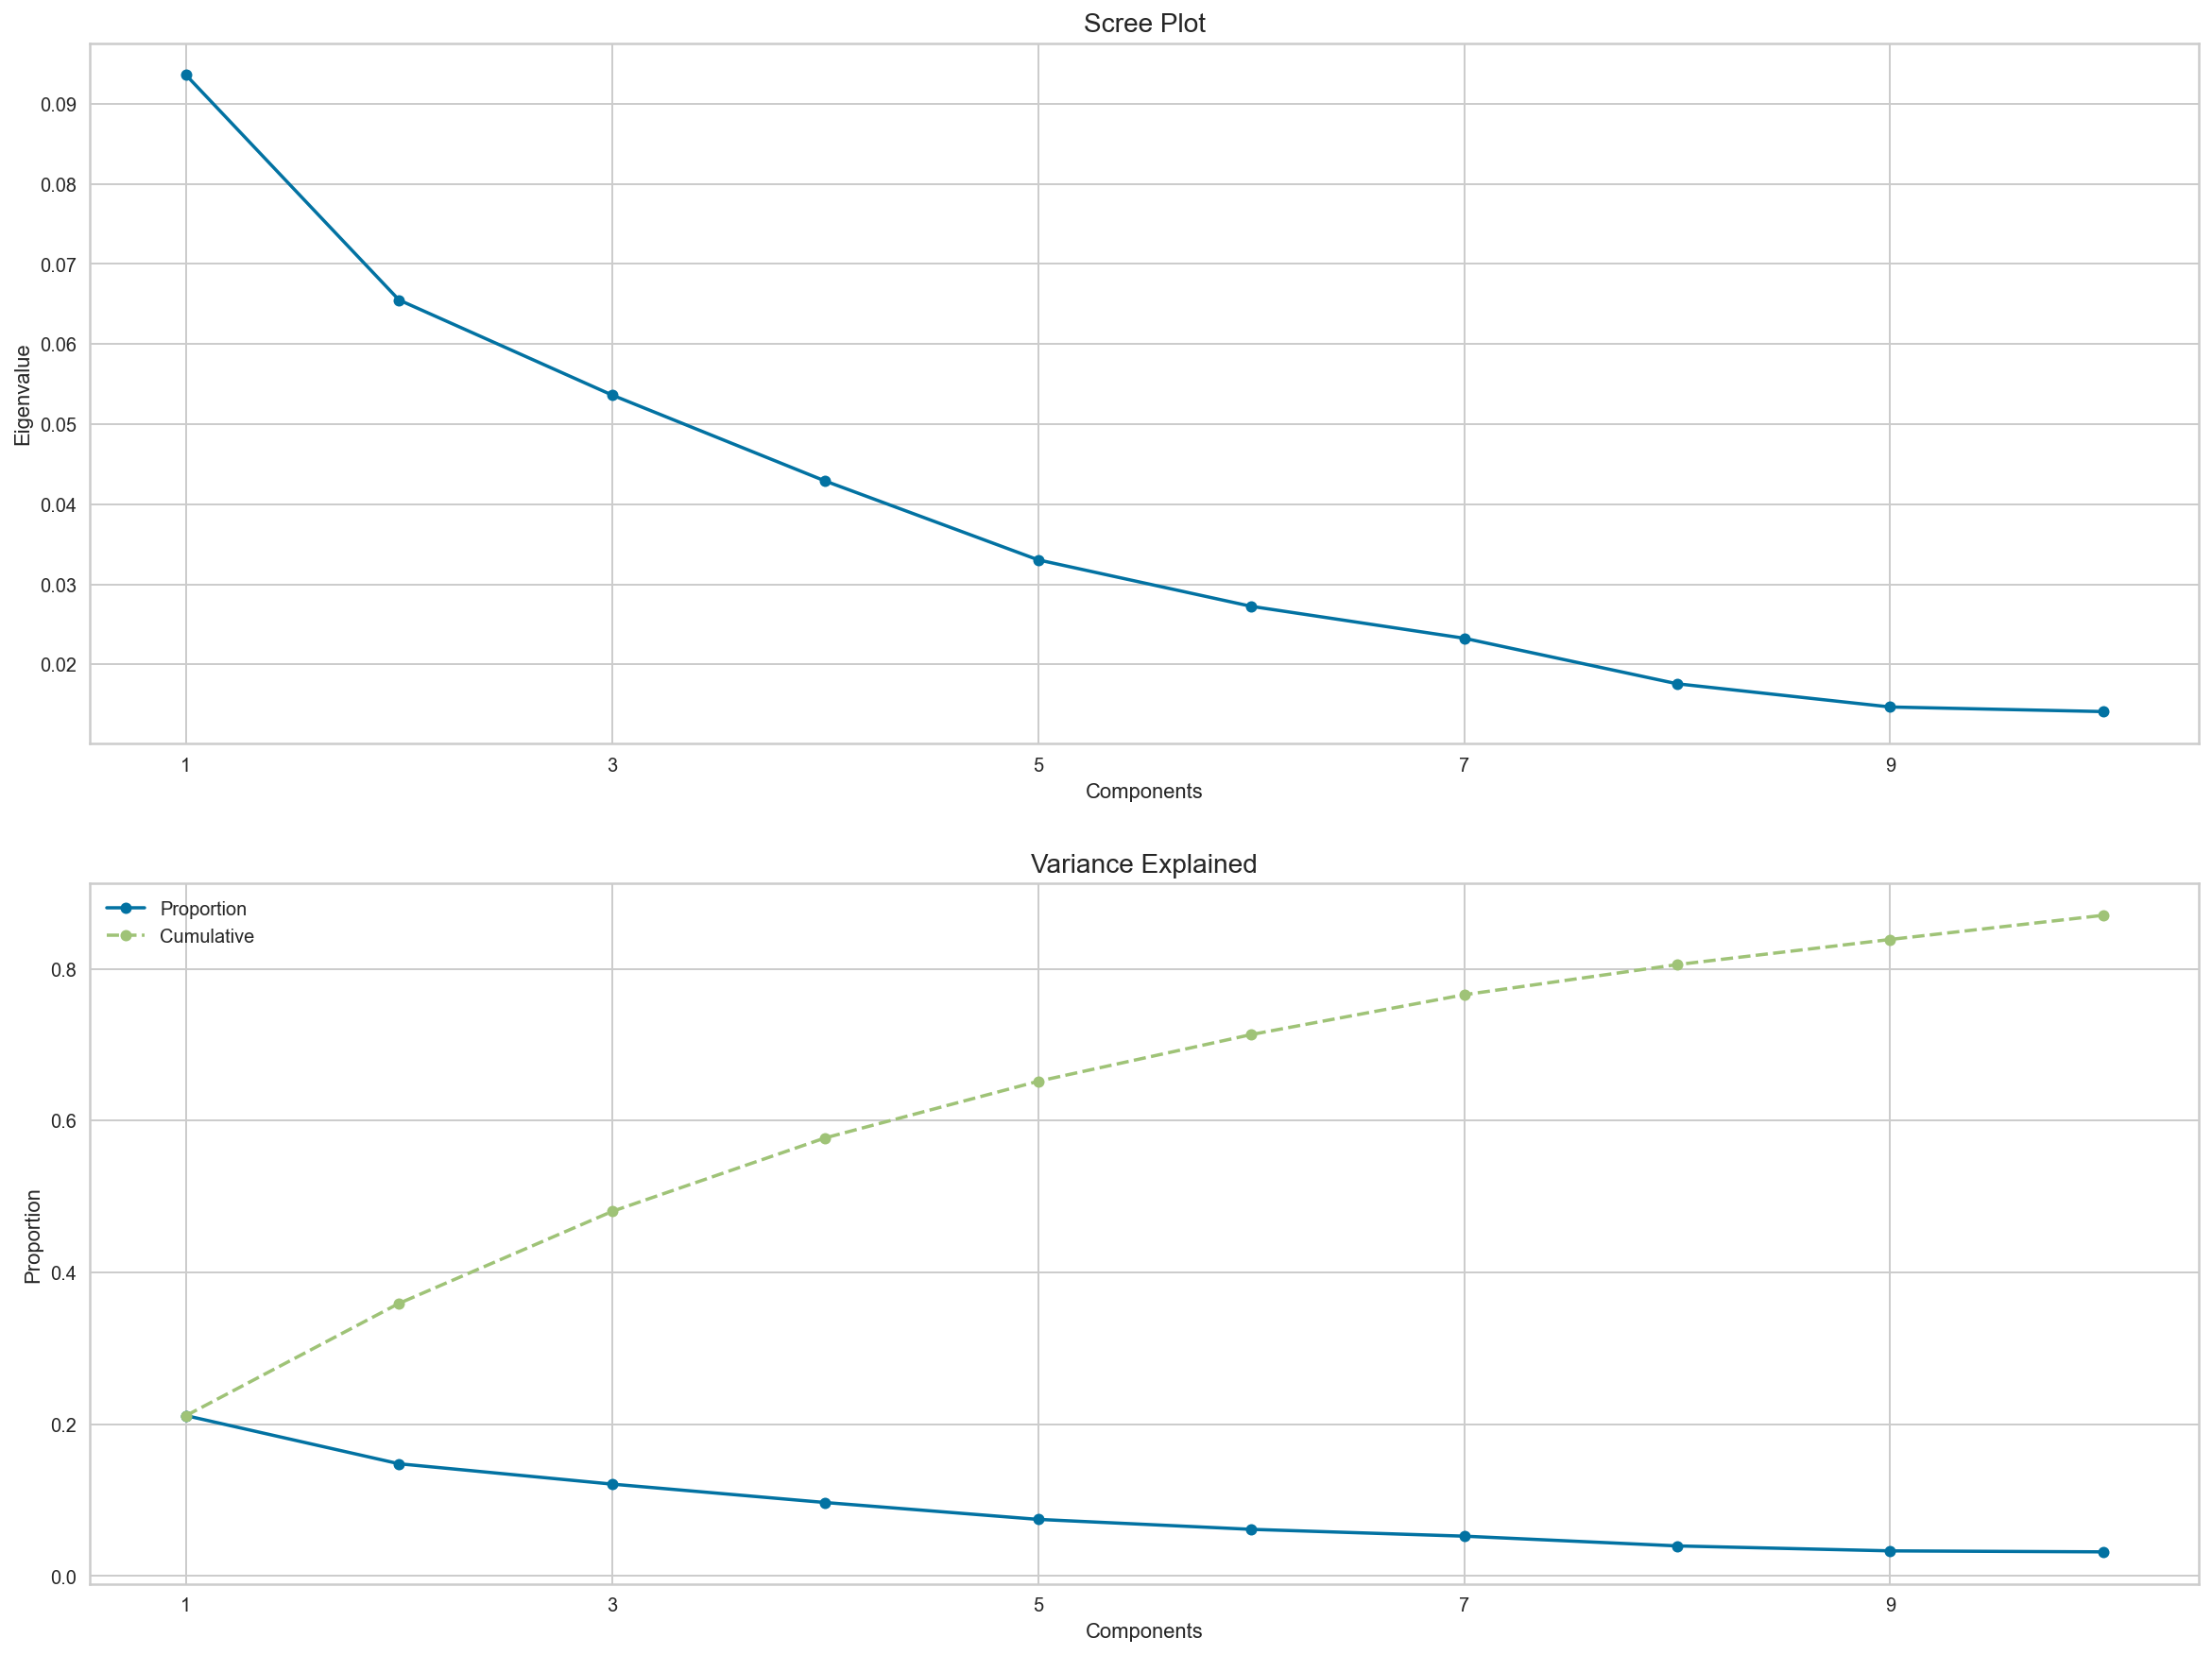

In [360]:
#figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

print('The minimum number of PCA to obtain at least 0.8 variance explained is: ',len(pca_table[pca_table["Cumulative"]<0.8]))
plt.show()

In [356]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=10)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
292  0.788897  0.126748 -0.727712  0.137919  0.114256 -0.383960  0.245268   
92   0.491619  0.466582 -0.556916 -0.266604  0.492486 -0.313393 -0.290943   
280  0.183233  0.014997 -0.637633  0.112365  0.196196 -0.394544 -0.001329   
78   0.468385 -0.299504 -0.715194 -0.038373 -0.046851 -0.030173  0.056959   
272  0.262557 -0.112543 -0.638188  0.144727  0.086611 -0.201546  0.184001   
..        ...       ...       ...       ...       ...       ...       ...   
167 -0.942259  0.602976 -0.203556 -0.178791 -0.277917  0.082785 -0.142865   
373 -0.173569 -0.179644  0.483630  0.269274  0.080237 -0.186482 -0.273726   
237 -0.417903  0.048848  0.300344  0.231370 -0.057001 -0.037211 -0.199977   
221 -0.521597  0.062393  0.106761  0.098921 -0.166210  0.115587 -0.191644   
243 -0.223668 -0.082473  0.553715  0.186005  0.256835  0.090333  0.374670   

          PC7       PC8       PC9  
292  0.001791 -0.213160  0.011684  
92  -0.200026  0.139622  0.176678  
280  0.066484 -0.020415 -0.079155  
78   0.150540 -0.030996 -0.232507  
272  0.092305 -0.141935 -0.028561  
..        ...       ...       ...  
167 -0.039071  0.024238  0.462947  
373  0.030668  0.166006 -0.050162  
237 -0.093298  0.119818 -0.114896  
221  0.089094  0.294456 -0.202215  
243 -0.201832 -0.270870 -0.176633  

[410 rows x 10 columns]

In [357]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

Total_Sales  Quantity  Value_per_Product  SalesYoY_2017  SalesYoY_2018  \
292       1.0000    1.0000             0.5498         0.4006         0.2997   
92        0.8516    0.7882             0.8029         0.3451         0.2302   
280       0.8282    0.8297             0.5436         0.4518         0.4994   
78        0.8096    0.8424             0.4253         0.8343         0.4807   
272       0.7822    0.7974             0.4876         0.4447         0.5082   

     SalesYoY_2019  Weekend_Sales  Top10_Sales_Percentage       2       9  \
292         0.4187         0.7895                  0.4094  0.2727  0.5385   
92          0.3686         0.1579                  0.4205  0.4091  0.6923   
280         0.4224         0.4211                  0.6344  0.5455  0.6154   
78          0.4059         0.7895                  0.5578  0.6364  0.6154   
272         0.3455         0.6842                  0.5789  0.5000  0.6154   

     ...       PC0       PC1       PC2       PC3       PC4       PC5  \
292  ...  0.788897  0.126748 -0.727712  0.137919  0.114256 -0.383960   
92   ...  0.491619  0.466582 -0.556916 -0.266604  0.492486 -0.313393   
280  ...  0.183233  0.014997 -0.637633  0.112365  0.196196 -0.394544   
78   ...  0.468385 -0.299504 -0.715194 -0.038373 -0.046851 -0.030173   
272  ...  0.262557 -0.112543 -0.638188  0.144727  0.086611 -0.201546   

          PC6       PC7       PC8       PC9  
292  0.245268  0.001791 -0.213160  0.011684  
92  -0.290943 -0.200026  0.139622  0.176678  
280 -0.001329  0.066484 -0.020415 -0.079155  
78   0.056959  0.150540 -0.030996 -0.232507  
272  0.184001  0.092305 -0.141935 -0.028561  

[5 rows x 30 columns]

In [358]:
def _color_red_or_green(val):
    if val < -0.6:
        color = 'background-color: red'
    elif val > 0.6:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

In [373]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(s=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [374]:
#K means Clustering 
def doKmeans(df, nclust):
    model = KMeans(nclust, random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [455]:
data_clust_test = data_standard
data_clust_test

Total_Sales  Value_per_Product  SalesYoY_2018  Top10_Sales_Percentage  \
292       4.5188             0.4785        -1.4933                 -1.3673   
92        3.5803             1.8757        -2.1350                 -1.2815   
280       3.4320             0.4441         0.3522                  0.3693   
78        3.3143            -0.2086         0.1797                 -0.2219   
272       3.1412             0.1349         0.4338                 -0.0596   
..           ...                ...            ...                     ...   
167      -1.5614             2.4597        -0.8515                  2.6276   
373      -1.5679            -0.4606        -0.3229                 -0.1779   
237      -1.5927            -1.0103         0.2929                 -0.3031   
221      -1.6211             0.4327         1.2815                  0.7774   
243      -1.8065            -0.0712        -1.1167                 -0.8665   

          2       9      12       8      21       1      18  
292 -1.7038 -0.8683  0.4693 -0.9001  1.4487  0.7403 -0.8846  
92  -0.8999  0.3830 -1.8010 -1.2739  2.9357 -1.2833 -1.5728  
280 -0.0961 -0.2426 -0.0983 -0.1523 -0.0383  0.7403  0.4918  
78   0.4398 -0.2426  0.4693 -1.2739  0.1269 -0.2715 -0.1964  
272 -0.3640 -0.2426 -0.0983 -0.1523 -0.2035  0.7403  0.4918  
..      ...     ...     ...     ...     ...     ...     ...  
167  1.2437 -0.8683 -1.8010  2.0910 -1.1948 -3.3069  1.1801  
373  0.7078 -0.2426  1.6045 -0.5262 -0.8644  1.7522  1.1801  
237 -0.6320  0.3830 -0.0983  1.7171 -0.6992 -0.2715  1.8683  
221  0.4398 -1.4940 -0.0983  2.0910 -1.0296 -0.2715  1.8683  
243  0.7078  1.0087  0.4693  0.2216 -1.1948  1.7522 -0.1964  

[410 rows x 11 columns]

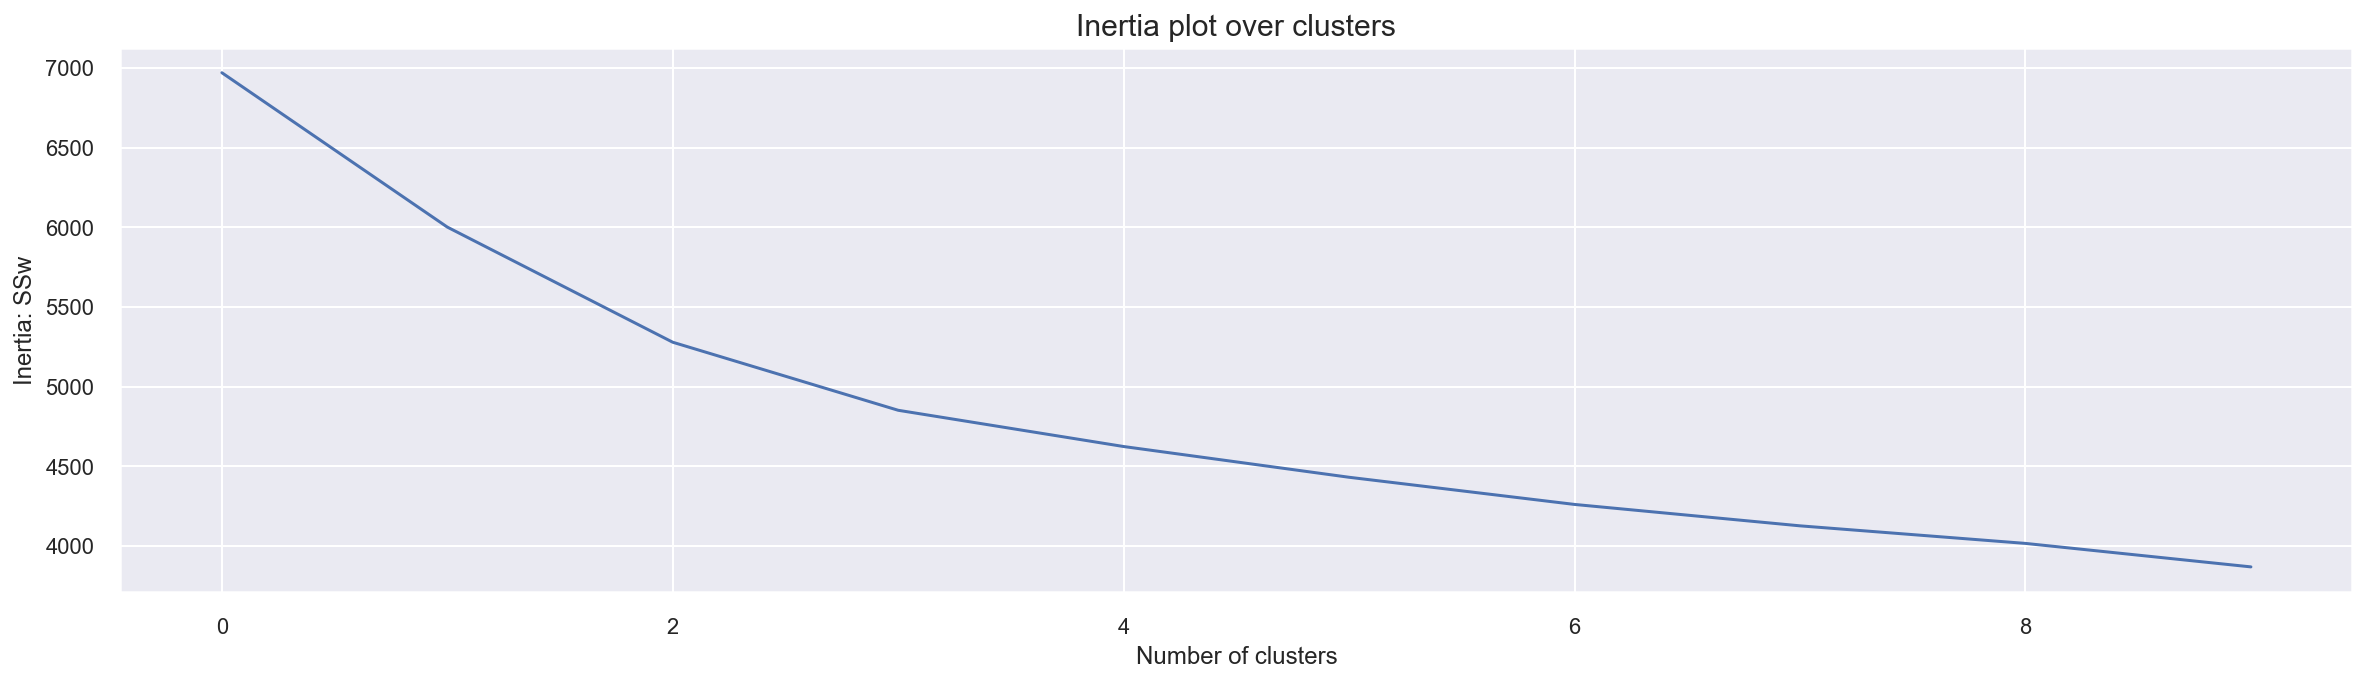

In [423]:
range_clusters = range(1, 11)
inertia = []

for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data_clust_test)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

# The inertia plot
plt.figure(figsize=(20,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [456]:
clust_labels, cent = doKmeans(data_clust_test, 4)
kmeans_data_clust_test = data_clust_test.copy()
kmeans_data_clust_test["kmeans_labels"] = clust_labels

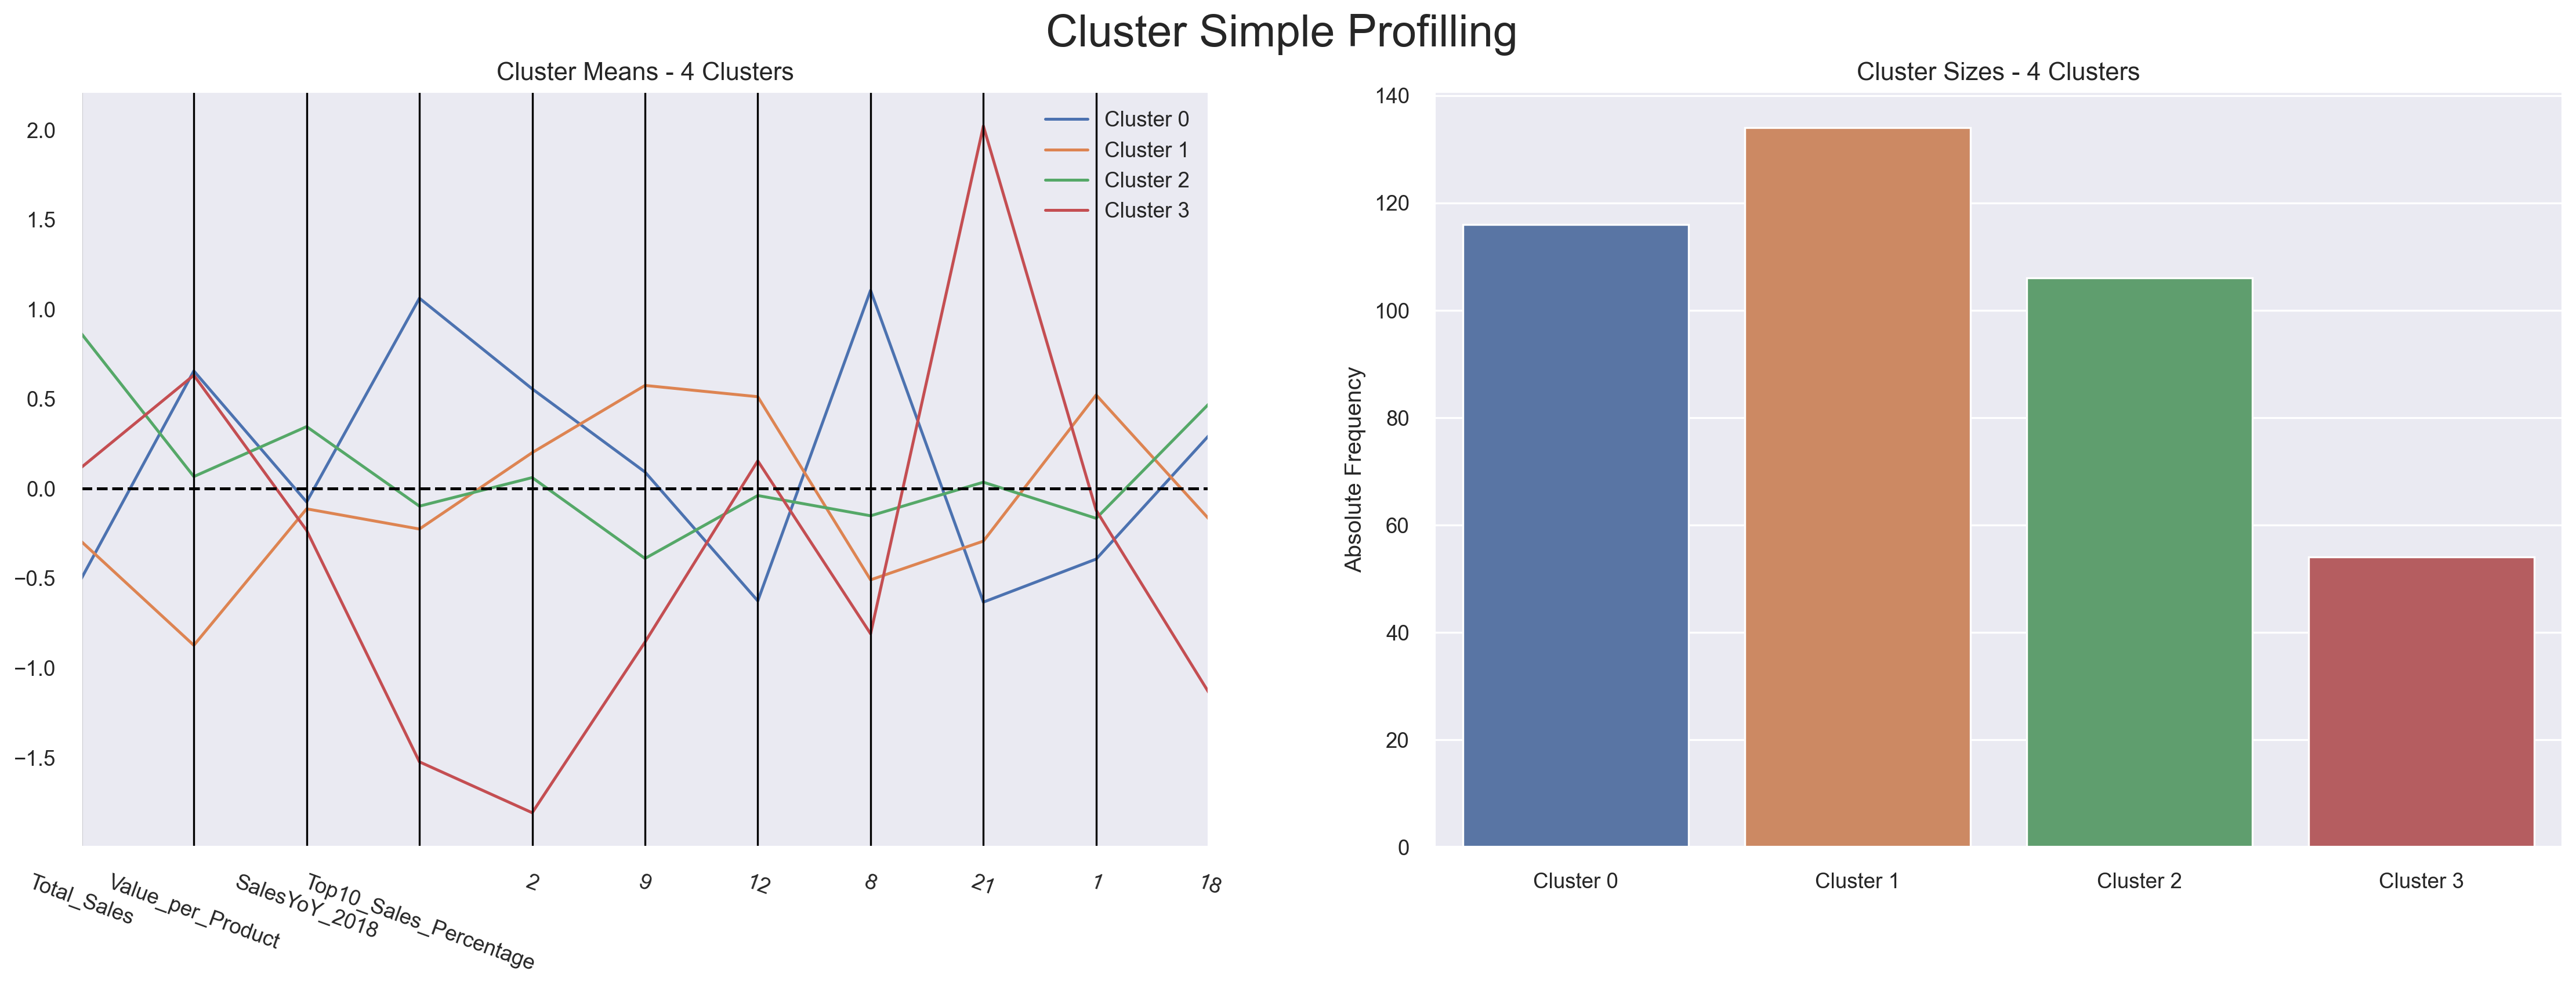

In [459]:
cluster_profiles(kmeans_data_clust_test, ["kmeans_labels"], figsize=(23, 7))

In [460]:
kmeans_summary = clustering_data.copy()
kmeans_summary['kmeans_labels'] = kmeans_data_clust_test['kmeans_labels'].reset_index().set_index(clustering_data.index).drop(columns='index')['kmeans_labels']
round(kmeans_summary.groupby("kmeans_labels").mean(), 2)

Total_Sales      Quantity  Value_per_Product  SalesYoY_2017  \
kmeans_labels                                                                 
0              6.047305e+08  360898.81250        1673.449951           5.25   
1              6.790833e+08  443194.15625        1539.869995           3.76   
2              1.086718e+09  670234.75000        1622.020020           5.13   
3              8.231981e+08  490695.81250        1671.349976           4.79   

               SalesYoY_2018  SalesYoY_2019  Top10_Sales  \
kmeans_labels                                              
0                       6.67         -11.48  227232416.0   
1                       6.46         -11.01  216568784.0   
2                       8.93          -9.52  352624448.0   
3                       5.81         -10.32  217253248.0   

               Top10_Sales_Percentage      2      9     12      8         21  \
kmeans_labels                                                                  
0                           37.459999  21.43  14.53  11.07  14.36   6.400000   
1                           31.910000  20.10  15.31  13.07  10.04   8.460000   
2                           32.459999  19.58  13.76  12.10  11.00  10.440000   
3                           26.309999  12.61  13.02  12.44   9.24  22.459999   

                  1    18     3     7    15    14     6  
kmeans_labels                                            
0              7.88  6.72  3.89  3.79  2.81  2.32  2.27  
1              8.78  6.04  4.10  2.68  2.84  2.49  2.81  
2              8.10  6.97  3.74  3.02  2.75  2.75  2.32  
3              8.15  4.63  2.48  2.85  2.54  3.04  2.35

In [461]:
kmeans_summary.tail(25)

Total_Sales  Quantity  Value_per_Product  SalesYoY_2017  SalesYoY_2018  \
234  338654048.0  220453.0             1536.0          13.37      15.640000   
220  335802560.0  204626.0             1641.0           0.34       1.870000   
94   327806848.0  214136.0             1531.0          -3.31       2.110000   
319  327194048.0  183274.0             1785.0          13.05       6.980000   
344  319694624.0  192776.0             1658.0           8.90       6.390000   
317  315229568.0  196696.0             1603.0         -10.44       3.880000   
313  313257952.0  198866.0             1575.0           1.29      -1.820000   
200  306975712.0  178861.0             1716.0           5.97       5.290000   
105  306727392.0  172025.0             1783.0           7.91       6.050000   
332  290732384.0  181187.0             1605.0           5.82      -3.880000   
247  284364000.0  182621.0             1557.0           7.08       5.210000   
320  266622240.0  168947.0             1578.0           5.18      17.879999   
365  266414096.0  153225.0             1739.0           3.36       5.210000   
366  262418800.0  155716.0             1685.0          -0.01       0.110000   
157  260070544.0  160988.0             1615.0           7.75      13.180000   
91   259099040.0  156175.0             1659.0          -1.82       3.680000   
310  256527936.0  174616.0             1469.0          -2.34      -0.240000   
375  253581008.0  151512.0             1674.0          -4.42      -2.560000   
178  246980864.0  147051.0             1680.0           5.68      10.010000   
307  236510208.0  155099.0             1525.0          14.76      13.060000   
167  233676512.0  127605.0             1831.0          -5.91       2.480000   
373  231410752.0  146802.0             1576.0          -5.71       5.330000   
237  222668848.0  145743.0             1528.0           3.18       8.650000   
221  212684800.0  128611.0             1654.0           6.59      13.980000   
243  147536080.0   91629.0             1610.0           1.38       1.050000   

     SalesYoY_2019  Top10_Sales  Top10_Sales_Percentage          2          9  \
234     -11.530000  137238896.0               40.520000  19.000000  17.000000   
220     -23.490000  107534496.0               32.020000  20.000000  15.000001   
94      -16.320000   96662112.0               29.490000  17.000000  15.000001   
319      -9.180000   58048012.0               17.740000   7.000000  10.000000   
344     -12.700000  119647992.0               37.430000  23.000000  16.000000   
317     -12.960000  116537168.0               36.970001  18.000000  14.000000   
313     -27.660000   97328544.0               31.070000  17.000000  15.000001   
200     -12.720000  120603616.0               39.290001  23.000000  11.000000   
105      -6.780000  143073872.0               46.650002  22.000000  13.000000   
332     -11.250000  104705408.0               36.009998  21.000000  14.000000   
247     -38.060001   85823968.0               30.180000  23.000000  17.000000   
320     -14.330000   87032616.0               32.639999  15.000001  14.000000   
365     -15.730000   85590536.0               32.130001  22.000000  14.000000   
366     -15.180000   81625328.0               31.099998  23.000000  16.000000   
157      -9.430000   87212776.0               33.529999  21.000000  12.000000   
91      -19.190001   80317240.0               31.000000  17.000000  15.000001   
310      -7.490000   62284276.0               24.279999  11.000000  13.000000   
375      -6.810000   80206688.0               31.630001  26.000000  15.000001   
178     -13.720000   88843360.0               35.970001  15.000001  15.000001   
307     -22.730000   55314820.0               23.389999  10.000000  13.000000   
167      -3.180000  103321496.0               44.220001  24.000000  13.000000   
373     -11.260000   74322496.0               32.120003  22.000000  14.000000   
237     -13.520000   70328384.0               31.580002  17.000000  15.000001   
221   

In [383]:
data_som = data_standard

In [408]:
#Producing SOM clustering based on proportional product data
sm = sompy.SOMFactory().build(data=data_som.values, 
                        mapsize=(10,10),
                        normalization='var',
                        initialization='random',
                        component_names=data_som.columns,
                        lattice='hexa',
                        training='seq')

sm.train(n_job=4,
         verbose=None,
         train_rough_len=100,
         train_finetune_len=100)

#Obtaining SOM's BMUs labels
som_data_socioeconomical_clust_test = pd.DataFrame(np.concatenate((sm._data, np.expand_dims(sm._bmu[0],1)), axis=1),
                               index=data_som.index, columns=np.append(data_som.columns,"labels_som"))

sm.calculate_quantization_error()

0.5422835843336804

In [409]:
som_data_socioeconomical_clust_test

Total_Sales  Quantity  Value_per_Product  SalesYoY_2017  SalesYoY_2018  \
292     4.518789  4.368805             0.4785       0.208200        -1.4933   
92      3.580292  3.058403             1.8757      -0.255200        -2.1350   
280     3.431992  3.314904             0.4441       0.635700         0.3522   
78      3.314292  3.393804            -0.2086       3.829601         0.1797   
272     3.141192  3.115504             0.1349       0.576500         0.4338   
..           ...       ...                ...            ...            ...   
167    -1.561397 -1.652304             2.4597      -1.900700        -0.8515   
373    -1.567897 -1.563504            -0.4606      -1.864800        -0.3229   
237    -1.592697 -1.568404            -1.0103      -0.267800         0.2929   
221    -1.621097 -1.647604             0.4327       0.344700         1.2815   
243    -1.806496 -1.818604            -0.0712      -0.591200        -1.1167   

     SalesYoY_2019  Weekend_Sales  Top10_Sales_Percentage         2         9  \
292       0.367795       2.147281               -1.367296 -1.703801 -0.868306   
92       -0.695803      -1.605684               -1.281496 -0.899902  0.383000   
280       0.447694      -0.041998                0.369301 -0.096103 -0.242603   
78        0.097195       2.147281               -0.221898  0.439796 -0.242603   
272      -1.188402       1.521787               -0.059598 -0.364003 -0.242603   
..             ...            ...                     ...       ...       ...   
167       1.013293      -0.980190                2.627597  1.243695 -0.868306   
373      -0.080104      -1.292987               -0.177898  0.707796 -0.242603   
237      -0.385904      -1.918481               -0.303097 -0.632003  0.383000   
221      -0.116604      -0.667493                0.777400  0.439796 -1.494009   
243      -0.234404      -1.292987               -0.866496  0.707796  1.008703   

     ...         8        21         1        18         3         7  \
292  ... -0.900098  1.448698  0.740325 -0.884611 -1.354174  0.781090   
92   ... -1.273899  2.935694 -1.283255 -1.572813 -0.572185 -0.091505   
280  ... -0.152296 -0.038298  0.740325  0.491793 -0.572185  0.781090   
78   ... -1.273899  0.126902 -0.271465 -0.196409  0.209805 -0.091505   
272  ... -0.152296 -0.203497  0.740325  0.491793  0.209805  0.781090   
..   ...       ...       ...       ...       ...       ...       ...   
167  ...  2.091009 -1.194794 -3.306834  1.180095  0.209805  5.143866   
373  ... -0.526197 -0.864395  1.752215  1.180095 -0.572185 -1.836696   
237  ...  1.717108 -0.699196 -0.271465  1.868297  0.209805 -0.964100   
221  ...  2.091009 -1.029595 -0.271465  1.868297  0.209805 -0.964100   
243  ...  0.221604 -1.194794  1.752215 -0.196409 -0.572185 -0.964100   

           15        14         6  labels_som  
292  0.391707  0.588873 -0.601999         4.0  
92  -3.025472 -0.823026 -0.601999         0.0  
280 -1.316833  0.588873 -0.601999        50.0  
78   0.391707 -0.823026  0.683511         4.0  
272  0.391707  0.588873 -0.601999         4.0  
..        ...       ...       ...         ...  
167 -1.316833 -0.823026 -0.601999        94.0  
373 -1.316833  0.588873  0.683511        69.0  
237 -1.316833  0.588873 -0.601999        79.0  
221 -1.316833 -0.823026  0.683511        96.0  
243  3.808986  0.588873 -1.887609        69.0  

[410 rows x 21 columns]

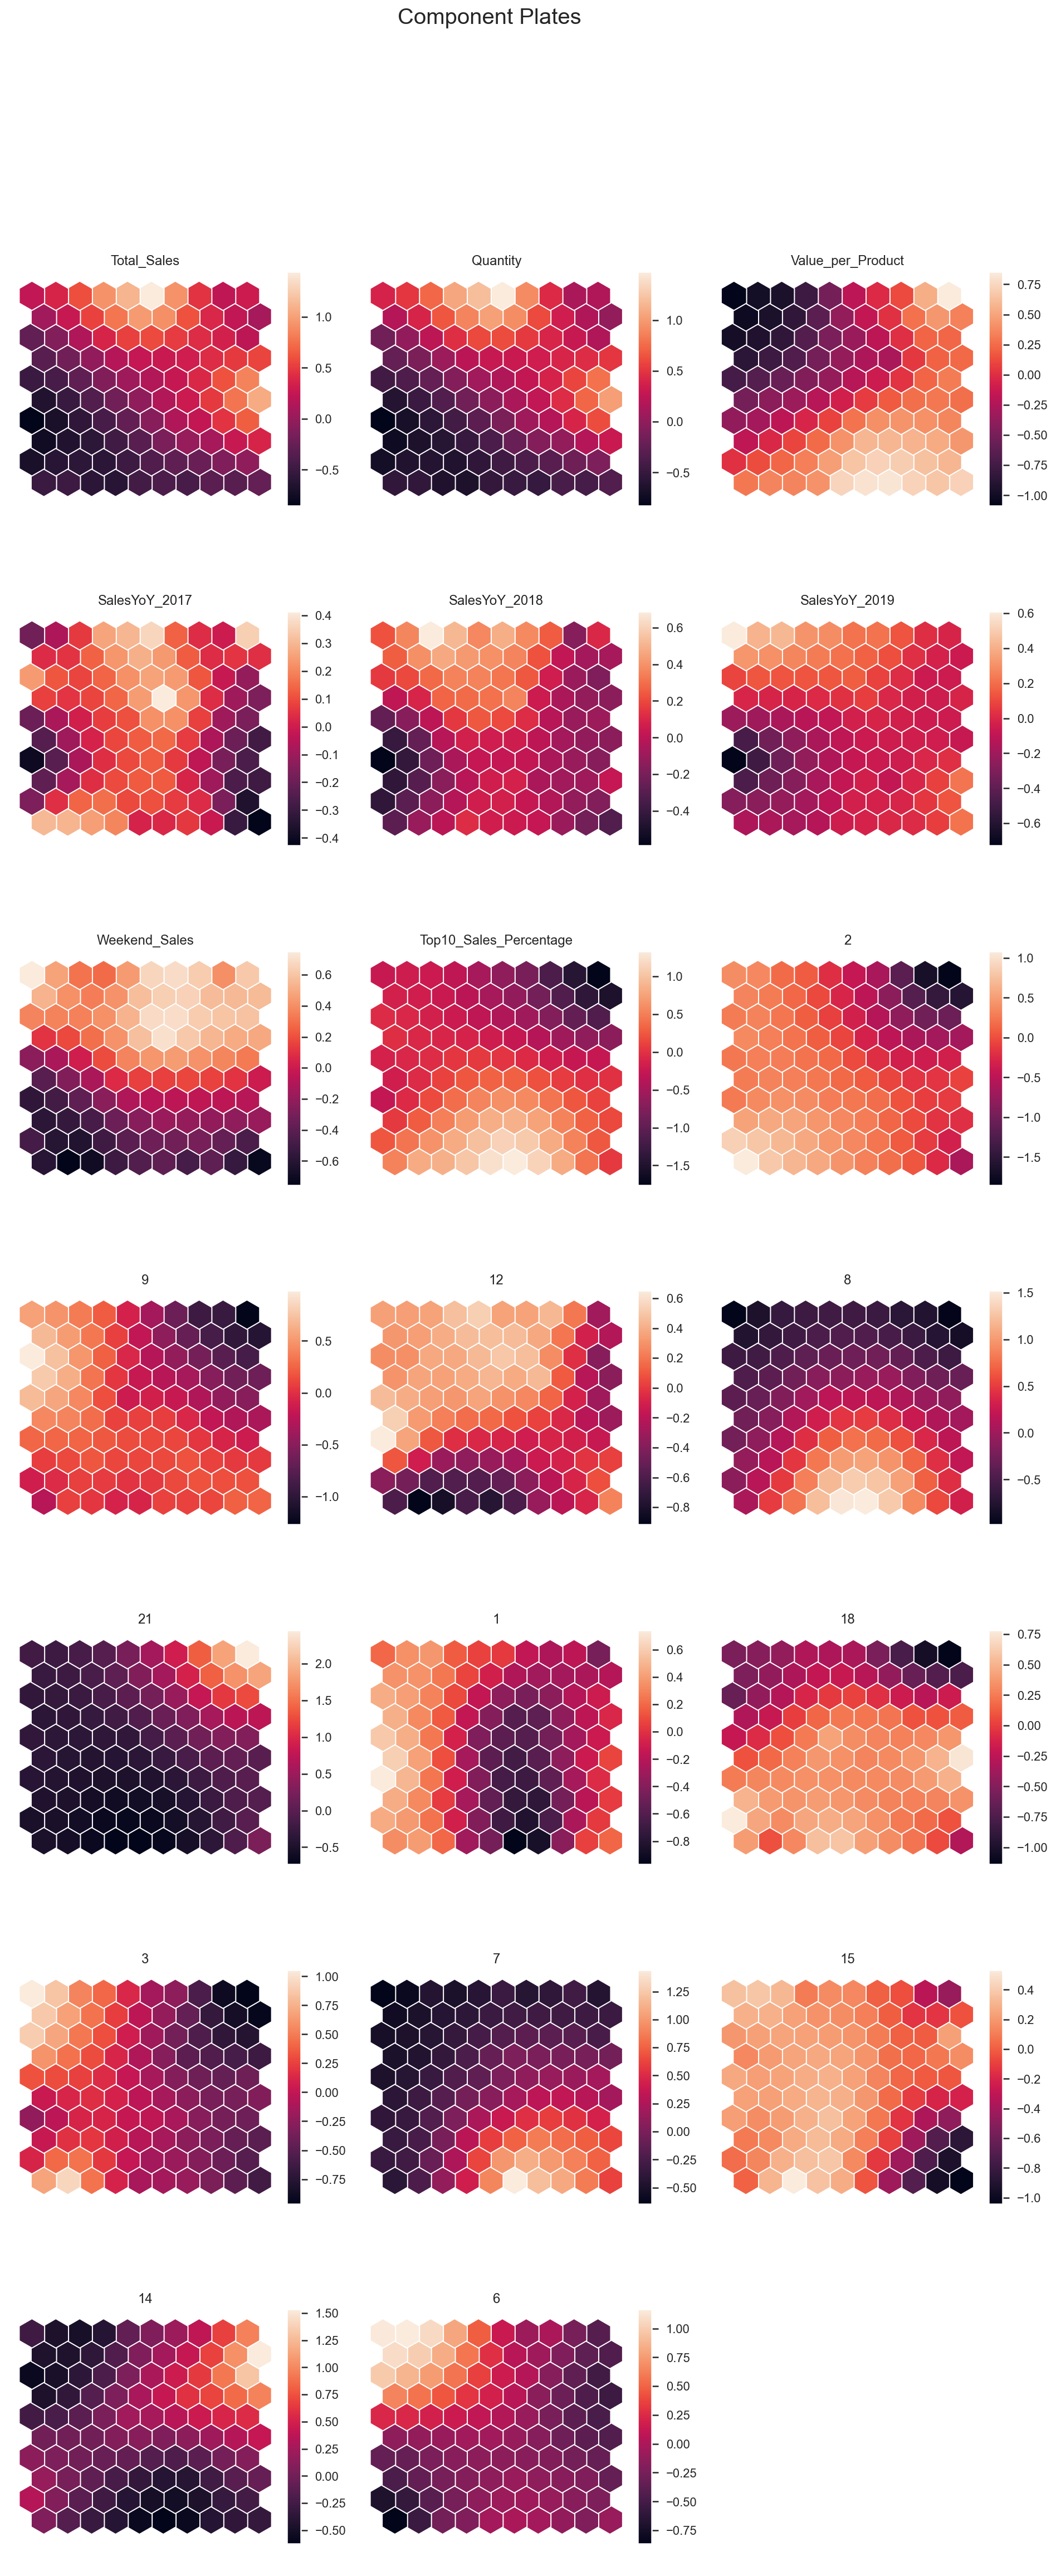

In [410]:
# Visualizing the Component plates (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Plates", fontsize=20)
plt.show()

In [411]:
# Getting the centroids of each cluster given by the BMUs of each observation
som_units = som_data_socioeconomical_clust_test.groupby("labels_som").mean()

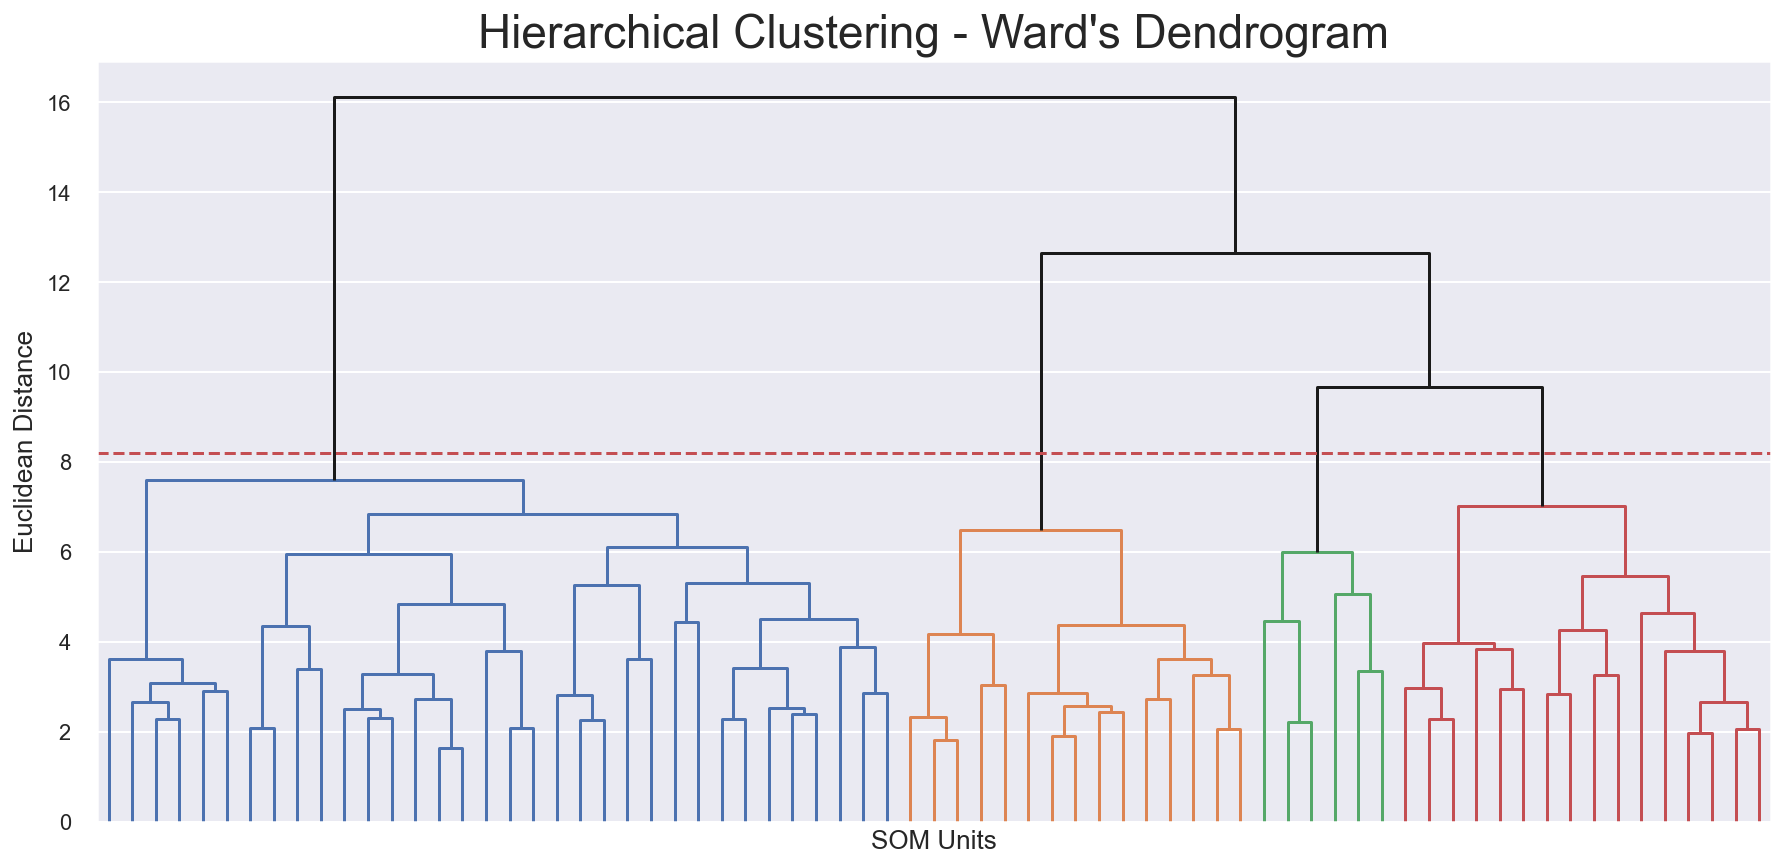

In [412]:
# Defining method to use
HCM = "ward"

# Hierarchical clustering assessment using scipy
Z = linkage(som_units, method=HCM)

sns.set()
fig = plt.figure(figsize=(15,7))

# Dendrogram
set_link_color_palette(list(sns.color_palette().as_hex()))
dendrogram(Z, color_threshold=8.2, orientation='top', no_labels=True, above_threshold_color='k')

plt.hlines(8.2, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
plt.xlabel('SOM Units', fontsize=13)
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

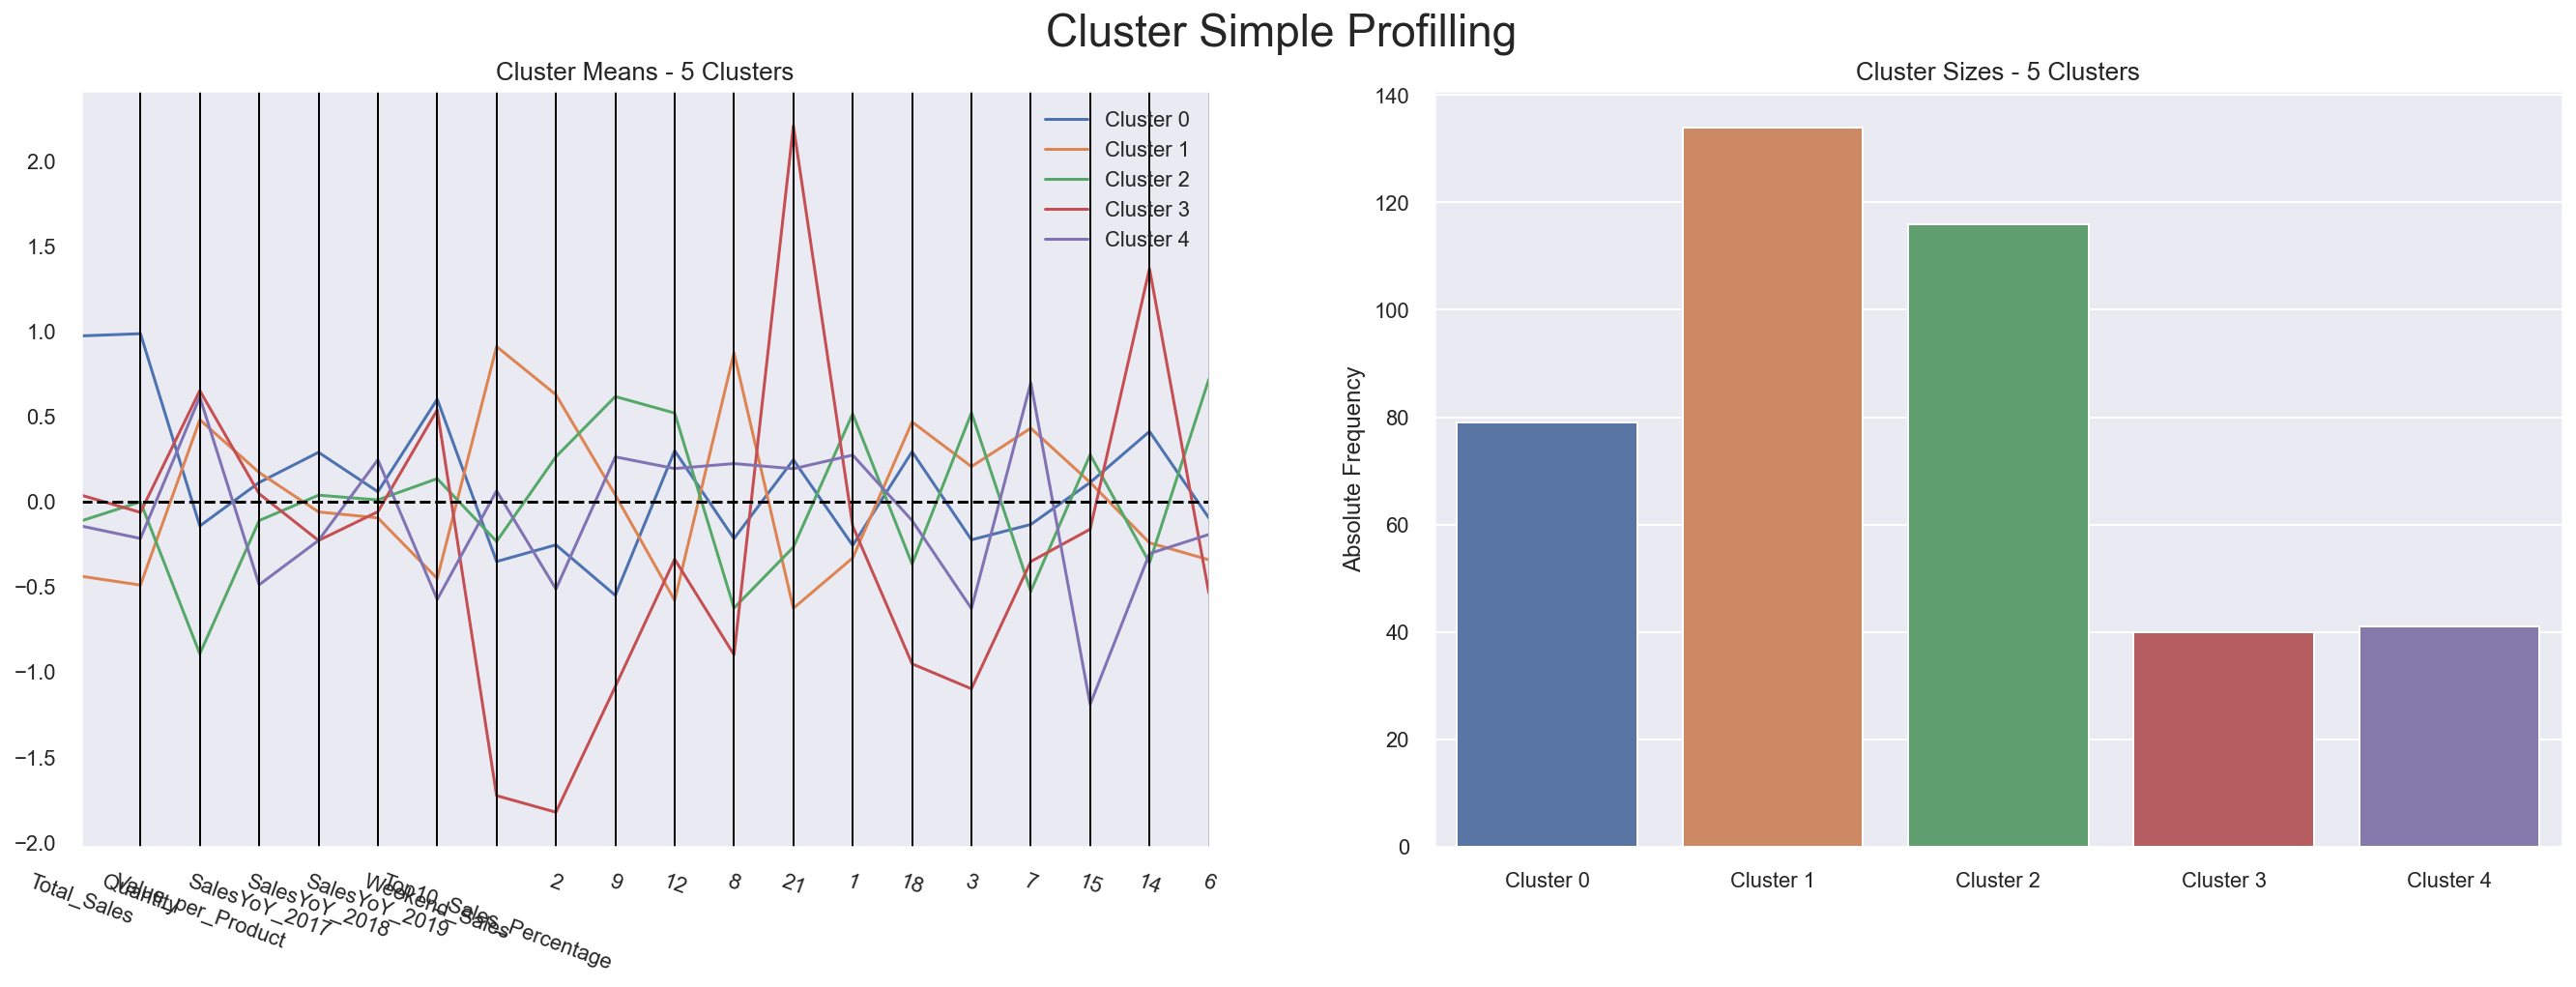

In [413]:
# Defining numbers of clusters
CLUSN = 5

# Hierarchical Clustering with sklearn
estimator = AgglomerativeClustering(n_clusters=CLUSN, linkage=HCM)
labels = estimator.fit_predict(som_units)

# Getting the HC labels for each SOM Unit
som_units_hc = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(labels,1)), axis=1), 
                            index=som_units.index, columns=np.append(som_units.columns,["labels_som_hc_4"]))

# Getting the HC labels for each observation in the main dataframe
som_data_socioeconomical_clust_test = som_data_socioeconomical_clust_test.merge(right=som_units_hc.loc[:,"labels_som_hc_4"], 
                                           left_on="labels_som", right_index=True).sort_index()
# Cluster Simple Profilling
cluster_profiles(som_data_socioeconomical_clust_test.drop("labels_som", axis=1), ["labels_som_hc_4"], (23, 7))


In [414]:
som_data_socioeconomical_clust_test

Total_Sales  Quantity  Value_per_Product  SalesYoY_2017  SalesYoY_2018  \
1       0.558998  0.576400            -0.1170        -0.2642         0.3225   
10     -1.014798 -1.030703             0.1006         0.8172         0.7566   
100     1.502396  1.633101            -0.5980         0.4346         0.5933   
101    -0.559799 -0.504902            -0.6553         0.5387        -0.0521   
102     1.039497  0.961400             0.4671         0.0286         0.0629   
..           ...       ...                ...            ...            ...   
95     -0.495799 -0.412002            -0.9072         0.0160        -0.7680   
96     -1.227798 -1.195703            -0.7469        -1.9653        -0.1207   
97     -1.194898 -1.069303            -2.1440        -2.9875        -0.9424   
98     -0.664499 -0.704202             0.3869         0.7597         0.2484   
99      0.200799  0.182699             0.1235         1.5393         0.4709   

     SalesYoY_2019  Weekend_Sales  Top10_Sales_Percentage         2         9  \
1        -0.054405       0.896293               -0.428297 -0.364003  0.383000   
10        0.229795      -0.980190                1.312899  0.707796  0.383000   
100       0.043095      -0.980190                0.123502  0.171896  2.260109   
101      -0.043505      -1.605684                0.065602 -0.096103  1.008703   
102      -0.390004      -0.041998                0.429601  0.439796  0.383000   
..             ...            ...                     ...       ...       ...   
95       -0.649803      -0.980190               -0.258998  0.171896  0.383000   
96       -8.531088       1.209090               -0.207998 -0.096103  1.008703   
97       12.724270      -0.667493               -0.031798  0.707796  1.008703   
98        0.080995      -0.980190                0.986000  0.171896  2.885712   
99        0.354295      -0.667493                0.531601  0.707796  2.260109   

     ...        21         1        18         3         7        15  \
1    ... -0.203497 -0.271465  0.491793  0.991794 -0.091505  0.391707   
10   ... -0.699196 -0.271465 -0.884611  0.991794  0.781090  0.391707   
100  ... -0.368697  0.740325 -0.884611  0.991794 -0.964100  0.391707   
101  ... -0.203497  1.752215 -0.884611  1.773784 -1.836696  0.391707   
102  ... -0.368697  0.740325 -0.884611  2.555674 -0.091505  0.391707   
..   ...       ...       ...       ...       ...       ...       ...   
95   ...  0.126902  0.740325 -0.884611  0.209805 -0.091505  0.391707   
96   ...  0.126902 -0.271465 -0.196409 -0.572185  0.781090  0.391707   
97   ... -0.533996  0.740325  0.491793  0.209805 -0.091505  0.391707   
98   ... -0.533996  0.740325 -1.572813  1.773784 -0.091505  0.391707   
99   ... -0.368697  0.740325 -1.572813  0.991794 -0.091505  0.391707   

           14         6  labels_som  labels_som_hc_4  
1   -0.823026  0.683511        26.0              2.0  
10  -0.823026  0.683511        97.0              1.0  
100 -0.823026  0.683511         7.0              2.0  
101  0.588873 -0.601999        98.0              1.0  
102 -0.823026  0.683511         8.0              2.0  
..        ...       ...         ...              ...  
95   0.588873 -0.601999        59.0              2.0  
96   0.588873  0.683511        69.0              2.0  
97   0.588873  0.683511         9.0              2.0  
98  -0.823026 -0.601999        98.0              1.0  
99  -0.823026 -0.601999        98.0              1.0  

[410 rows x 22 columns]

## Forecasting Sales

### Testing for a Specific Point-of-Sale and Product
- Product 2802
- Point-of-Sale 30

### Using SARIMA
-Link with tutorial here: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [412]:
data_product_POS = df[(df['Point-of-Sale_ID']=='1') & (df['ProductName_ID']=='481')]

In [413]:
data_product_POS['Date'] = pd.to_datetime(data_product_POS.Date)
data_product_POS_weekly = data_product_POS[['Quantity', 'Date']].set_index('Date').resample('W').sum()

In [414]:
data_product_POS_weekly

Quantity
Date                
2016-01-03      34.0
2016-01-10      75.0
2016-01-17      64.0
2016-01-24      40.0
2016-01-31      39.0
...              ...
2019-10-06      29.0
2019-10-13      30.0
2019-10-20      19.0
2019-10-27      47.0
2019-11-03      14.0

[201 rows x 1 columns]

In [10]:
data_product_POS = df[(df['Point-of-Sale_ID']=='30') & (df['ProductName_ID']=='481')]

In [11]:
data_product_POS['Date'] = pd.to_datetime(data_product_POS.Date)
data_product_POS_weekly = data_product_POS[['Quantity', 'Date']].set_index('Date').resample('W').sum()

In [22]:
data_product_POS_weekly

Quantity
Date                
2016-01-03      36.0
2016-01-10     111.0
2016-01-17      59.0
2016-01-24      52.0
2016-01-31      43.0
...              ...
2019-10-06      26.0
2019-10-13      69.0
2019-10-20      41.0
2019-10-27      42.0
2019-11-03      25.0

[201 rows x 1 columns]

In [109]:
benchmark = data_product_POS_weekly.shift().rolling(7, min_periods=1).mean()

In [34]:
res = adfuller(data_product_POS_weekly)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])

ADF Statistic: -4.207604
p-value: 0.000640


In [55]:
df_ = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df_

value
0      88
1      84
2      85
3      85
4      84
..    ...
95    222
96    228
97    226
98    222
99    220

[100 rows x 1 columns]

In [28]:
data_product_POS_weekly.reset_index().Quantity

0       36.0
1      111.0
2       59.0
3       52.0
4       43.0
       ...  
196     26.0
197     69.0
198     41.0
199     42.0
200     25.0
Name: Quantity, Length: 201, dtype: float32

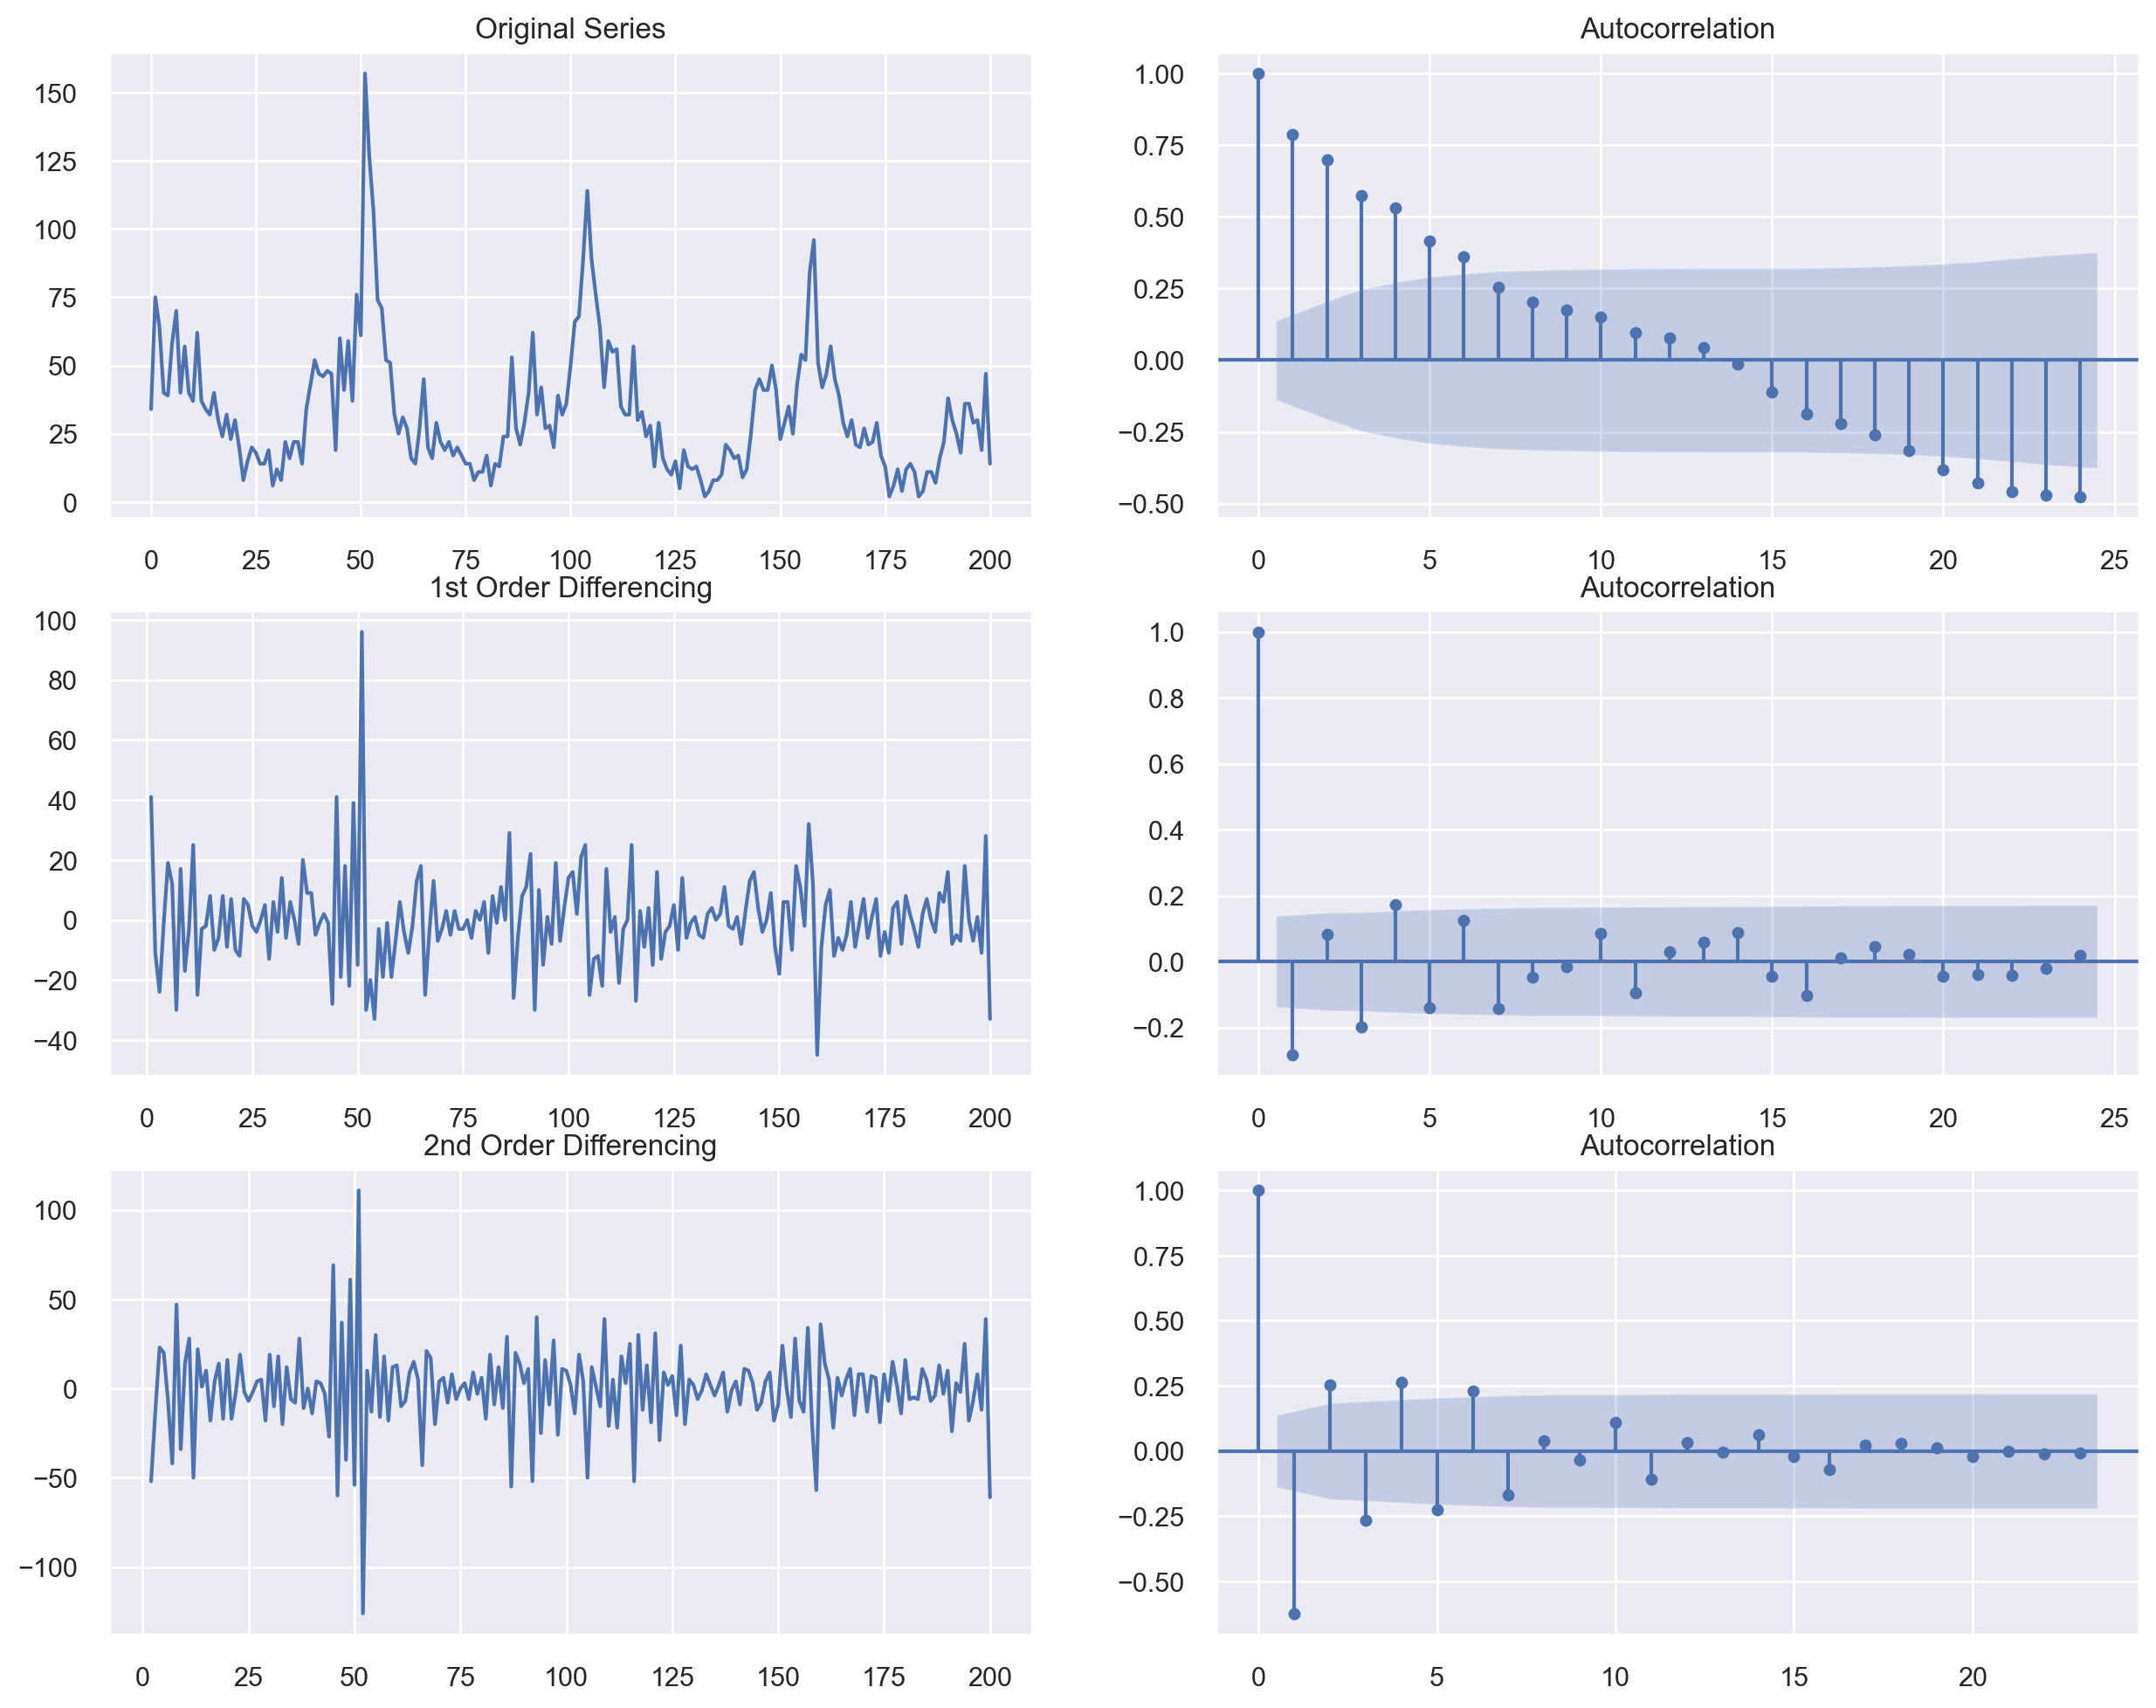

In [468]:
plt.rcParams.update({'figure.figsize':(15,12), 'figure.dpi':100})

# Import data
df__ = data_product_POS_weekly.reset_index().Quantity

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df__); axes[0, 0].set_title('Original Series')
plot_acf(df__, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df__.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df__.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df__.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df__.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Seems that diff 1 time is enough to make data stationary

In [36]:
res = adfuller(data_product_POS_weekly.diff().dropna())
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])

ADF Statistic: -18.406034
p-value: 0.000000


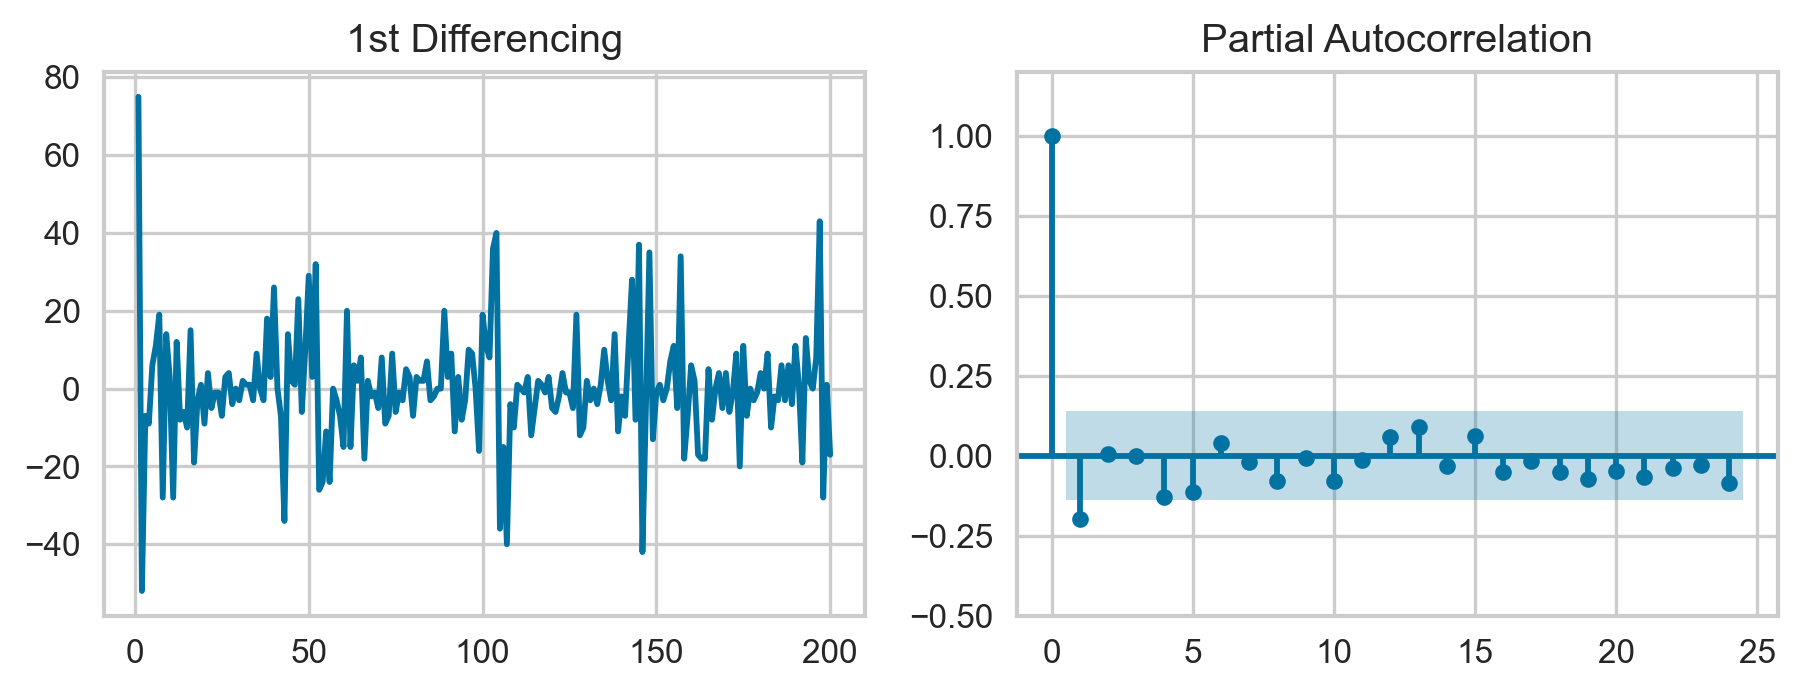

In [306]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df__.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-0.5,1.2))
plot_pacf(df__.diff().dropna(), ax=axes[1])

plt.show()

In [44]:
df__

0       36.0
1      111.0
2       59.0
3       52.0
4       43.0
       ...  
196     26.0
197     69.0
198     41.0
199     42.0
200     25.0
Name: Quantity, Length: 201, dtype: float32

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df__.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-1,1.2))
plot_acf(df__.diff().dropna(), ax=axes[1])

plt.show()

In [307]:
model = ARIMA(df__, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                  200
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -816.286
Method:                       css-mle   S.D. of innovations             14.330
Date:                Tue, 01 Jun 2021   AIC                           1640.573
Time:                        04:03:44   BIC                           1653.766
Sample:                             1   HQIC                          1645.912
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1087      0.845     -0.129      0.898      -1.766       1.548
ar.L1.D.Quantity    -0.2243      0.075     -2.999      0.003      -0.371      -0.078
ar.L2.D.Quantity     0.0246 

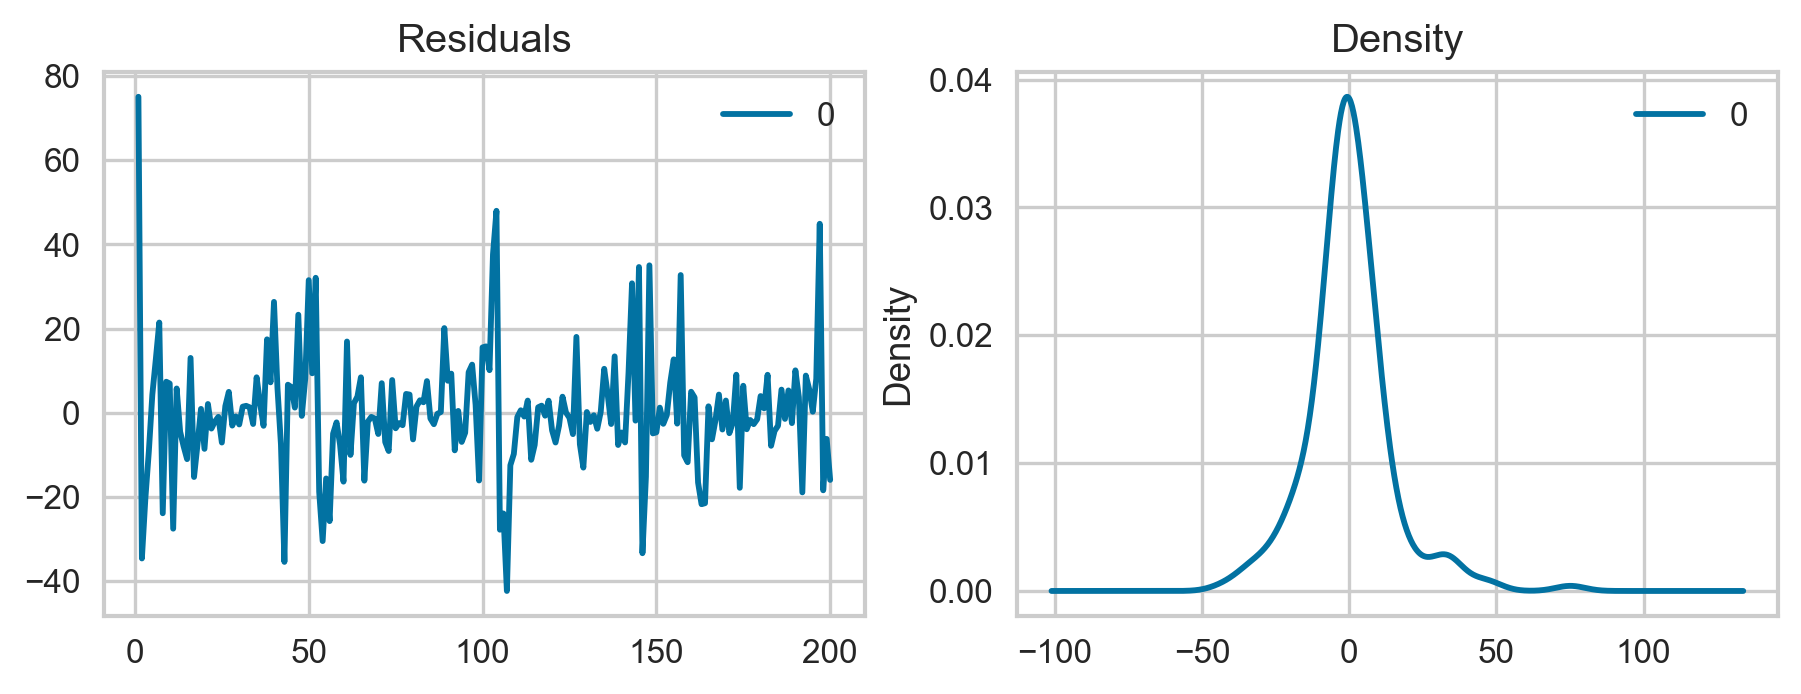

In [308]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

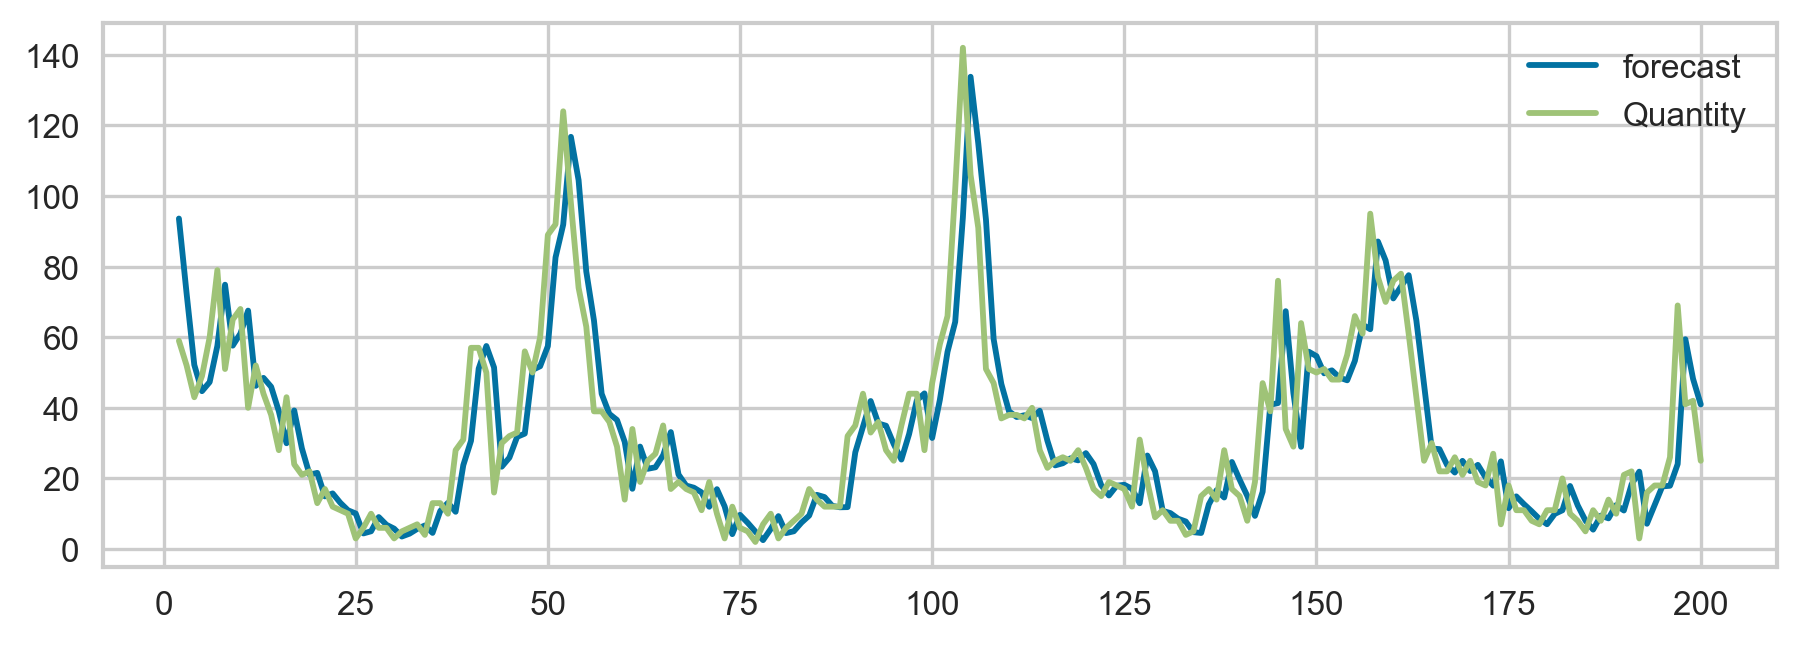

In [309]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [58]:
# Create Training and Test
train = df__[:194]
test = df__[194:]

/Users/rui.soromenho/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


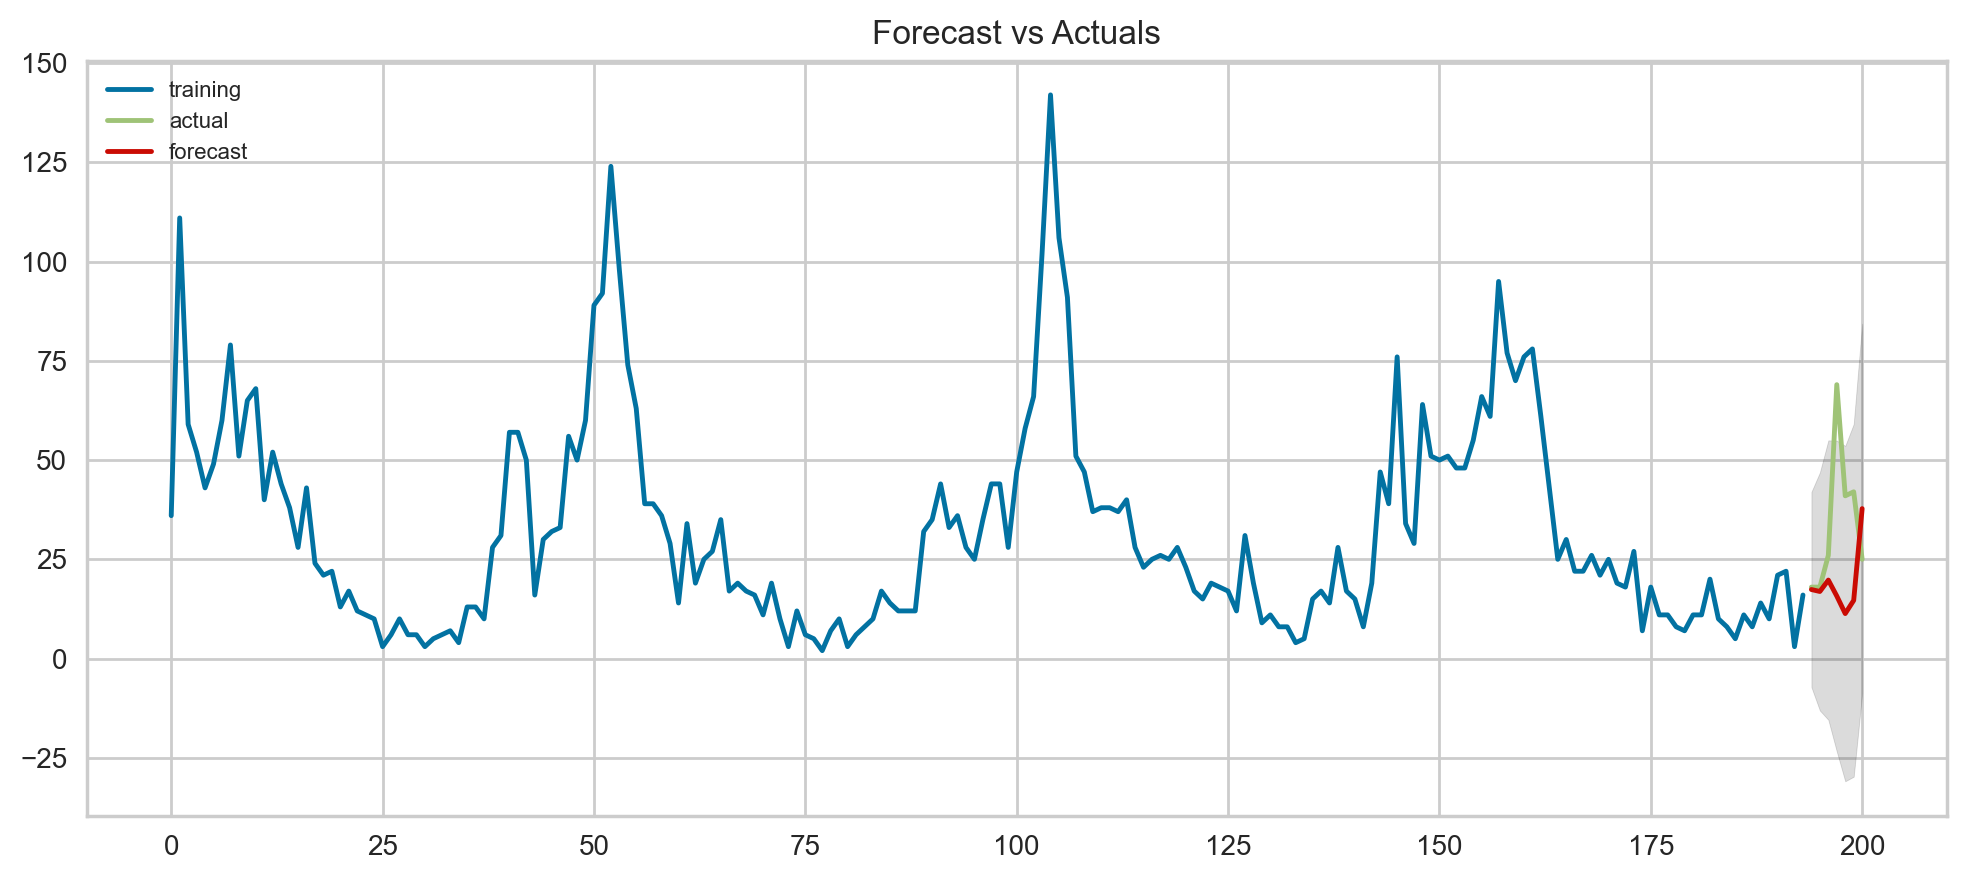

In [64]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(10, 1, 10))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.42739697566250606,
 'me': -15.061645094610729,
 'mae': 18.71017636297407,
 'mpe': -0.2814557249279723,
 'rmse': 25.820554665994877,
 'acf1': 0.12445108521783352,
 'corr': -0.3363626708106574,
 'minmax': 0.40272585845504116}

In [68]:
model = pm.auto_arima(df__, start_p=3, start_q=3,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1645.844, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1638.675, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1639.337, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1643.847, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1640.574, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1640.586, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1642.574, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1636.693, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1638.591, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1638.603, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1637.354, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1640.591, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.233 seconds
                           

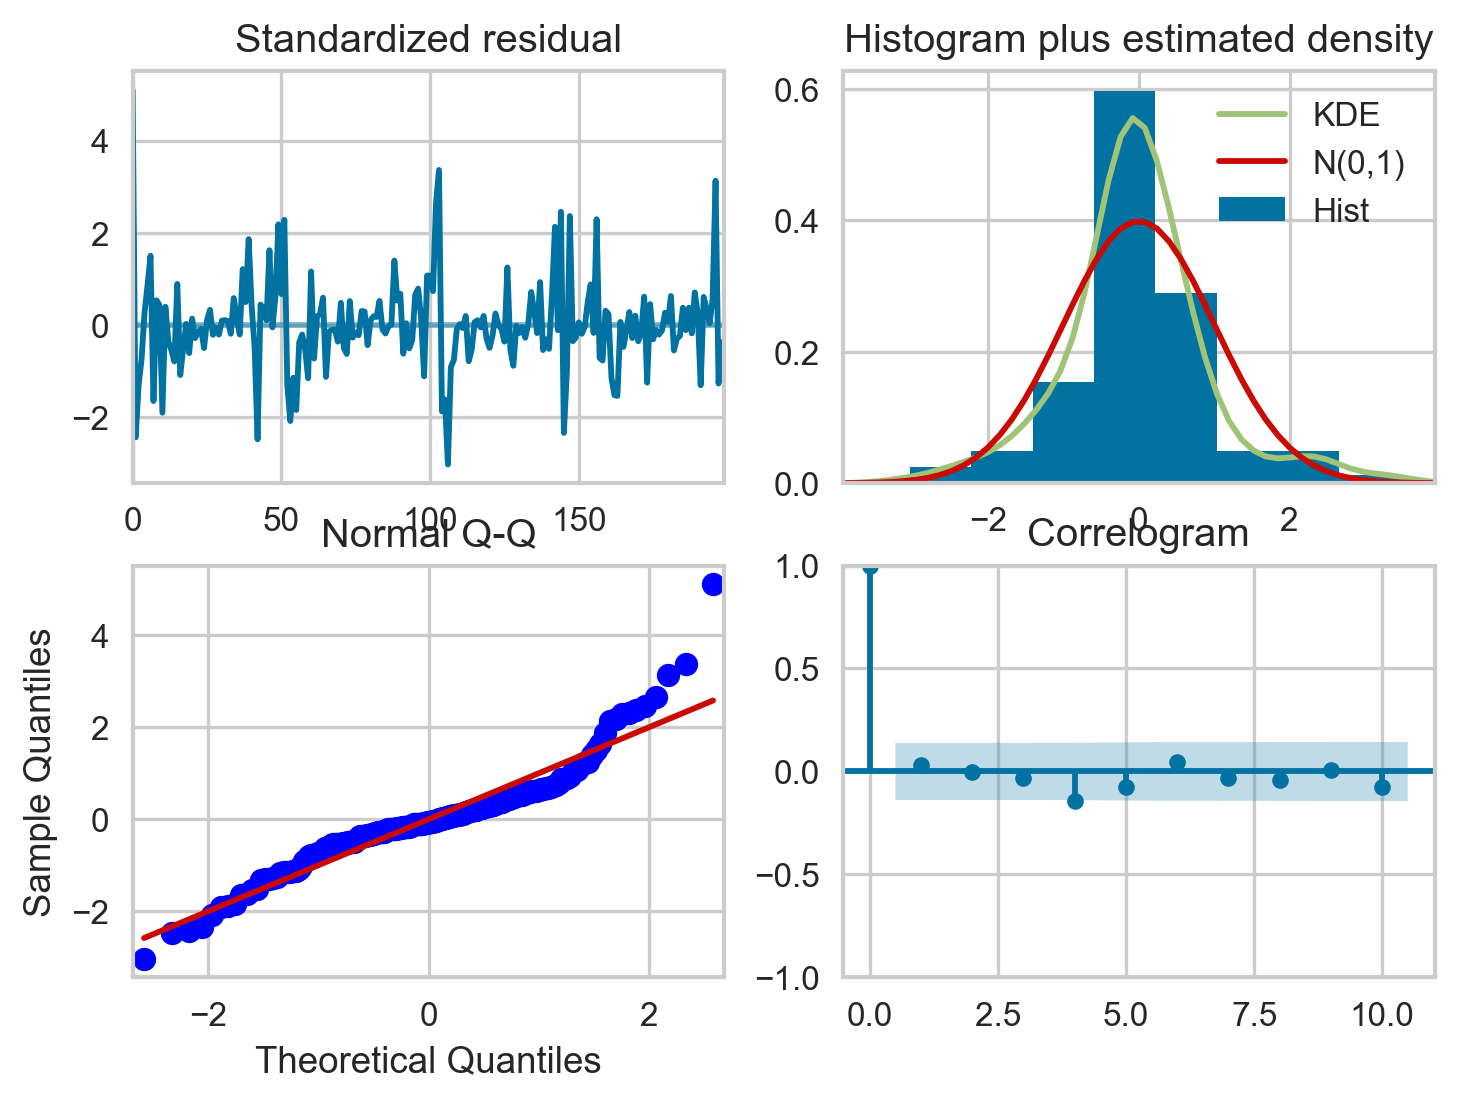

In [69]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


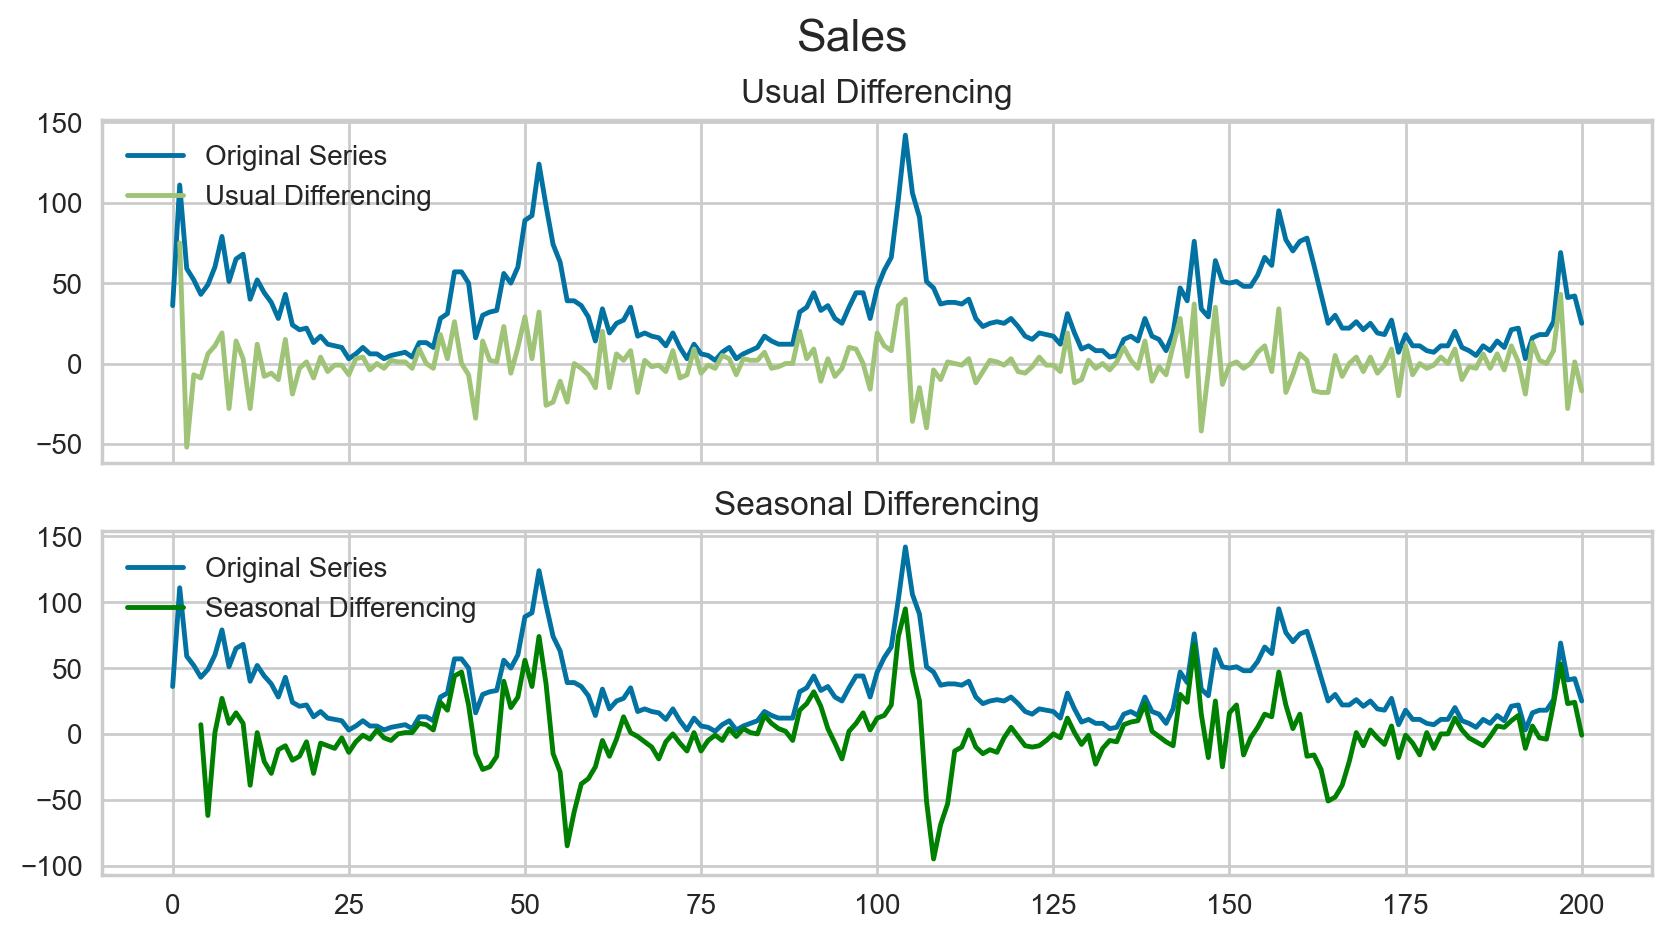

In [76]:
# Import
data = df__

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(4), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Sales', fontsize=16)
plt.show()

In [104]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=6, start_q=0,
                         test='adf',
                         max_p=10, max_q=10, m=7,
                         start_P=6, max_P=10,seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(6,1,1)(6,1,1)[7]             : AIC=1614.241, Time=7.59 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1706.408, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1656.658, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.43 sec
 ARIMA(6,1,1)(5,1,1)[7]             : AIC=inf, Time=5.96 sec
 ARIMA(6,1,1)(6,1,0)[7]             : AIC=1627.465, Time=2.11 sec
 ARIMA(6,1,1)(7,1,1)[7]             : AIC=inf, Time=11.63 sec
 ARIMA(6,1,1)(6,1,2)[7]             : AIC=inf, Time=9.88 sec
 ARIMA(6,1,1)(5,1,0)[7]             : AIC=1637.674, Time=1.90 sec
 ARIMA(6,1,1)(5,1,2)[7]             : AIC=inf, Time=8.84 sec
 ARIMA(6,1,1)(7,1,0)[7]             : AIC=1620.723, Time=4.97 sec
 ARIMA(6,1,1)(7,1,2)[7]             : AIC=inf, Time=16.86 sec
 ARIMA(5,1,1)(6,1,1)[7]             : AIC=1612.451, Time=10.32 sec
 ARIMA(5,1,1)(5,1,1)[7]             : AIC=inf, Time=6.77 sec
 ARIMA(5,1,1)(6,1,0)[7]             : AIC=1625.935, Time=2.42 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  201
Model:             SARIMAX(6, 1, 0)x(6, 1, [1], 7)   Log Likelihood                -792.130
Date:                             Tue, 01 Jun 2021   AIC                           1612.260
Time:                                     00:03:17   BIC                           1657.938
Sample:                                          0   HQIC                          1630.758
                                             - 201                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2065      0.065     -3.171      0.002      -0.334      -0.079
ar.L2          0.0062      0.073      0.085      0.932      -0.136       0.149
ar.L3         -0.0489      0.069     -0.710      0.477      -0.184       0.086
ar.L4         -0.2171      0.076     -2.846      0.004      -0.367      -0.068
ar.L5         -0.1598      0.082     -1.946      0.052      -0.321       0.001
ar.L6          0.0637      0.097      0.654      0.513      -0.127       0.255
ar.S.L7       -0.1304      0.091     -1.426      0.154      -0.310       0.049
ar.S.L14      -0.1309      0.111     -1.180      0.238      -0.348       0.087
ar.S.L21      -0.1557      0.115     -1.353      0.176      -0.381       0.070
ar.S.L28      -0.1741      0.115     -1.509      0.131      -0.400       0.052
ar.S.L35      -0.1180      0.103     -1.151      0.250      -0.319       0.083
ar.S.L42      -0.1468      0.091     -1.610      0.107      -0.325       0.032
ma.S.L7       -0.9090      0.118     -7.734      0.000      -1.139      -0.679
sigma2       192.2725     17.057     11.272      0.000     158.841     225.704
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                90.83
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.04
Prob(H) (two-sided):                  0.39   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [333]:
y = data_product_POS_weekly
order = (1,1,0)
seasonal_order = (1, 0, 1, 7)
pred_date = y.tail(50).index[0]
to_test = y[pred_date:]['Quantity']

In [425]:
def sarima_eva(y,order,seasonal_order,pred_date):
    # fit the model 
    y_to_test = y[pred_date:]['Quantity']
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    pred_ci['lower Quantity'] = pred_ci['lower Quantity'].apply(lambda x : x if x > 0 else 0)

    y_forecasted = pred.predicted_mean
    
    y_forecasted = y_forecasted.to_frame()
    y_forecasted['predicted_mean'] = y_forecasted['predicted_mean'].apply(lambda x : x if x > 0 else 0)
    y_forecasted = y_forecasted.squeeze()
    
    mse = ((y_forecasted - y_to_test) ** 2).mean()

    residuals = results.resid

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()
    
    
    # Root Mean Squarred Error (RMSE) 
    RMSE = np.sqrt(np.mean(np.square(y_forecasted - y_to_test)))
    print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))
  
    # # Mean Absolute Error (MAE)
    MAE = np.mean(abs(residuals))
    print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

    # Median Absolute Error (MedAE)
    MEDAE = np.median(abs(residuals))
    print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

    # Mean Squared Error (MSE)
    MSE = np.square(np.subtract(y_forecasted, y_to_test)).mean()
    print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean(np.abs(y_forecasted - y_to_test)/np.abs(y_forecasted))
    print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')
    
    return (results)

In [427]:
def sarima_eva_pipeline(y,order,seasonal_order,pred_date):
    y_to_test = y[pred_date:]['Quantity']
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_invertibility=False)

    results = mod.fit()

    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    pred_ci['lower Quantity'] = pred_ci['lower Quantity'].apply(lambda x : x if x > 0 else 0)

    y_forecasted = pred.predicted_mean
    
    y_forecasted = y_forecasted.to_frame()
    y_forecasted['predicted_mean'] = y_forecasted['predicted_mean'].apply(lambda x : x if x > 0 else 0)
    y_forecasted = y_forecasted.squeeze()
   
    benchmark = y.shift().rolling(7, min_periods=1).mean()
    benchmark = benchmark[pred_date:].Quantity
    
    # Root Mean Squarred Error (RMSE) 
    model_RMSE = np.sqrt(np.mean(np.square(y_forecasted - y_to_test)))
  
    # # Mean Absolute Error (MAE)
    model_MAE = np.mean(abs(residuals))

    # Median Absolute Error (MedAE)
    MEDAE = np.median(abs(residuals))

    # Mean Squared Error (MSE)
    model_MSE = np.square(np.subtract(y_forecasted, y_to_test)).mean()
    benchmark_MSE = np.square(np.subtract(benchmark, y_to_test)).mean()

    # Mean Absolute Percentage Error (MAPE)
    model_MAPE = np.mean(np.abs(y_forecasted - y_to_test)/np.abs(y_to_test))
    benchmark_MAPE = np.mean(np.abs(benchmark - y_to_test)/np.abs(y_to_test))
    
    df_results = pd.DataFrame([y_to_test, y_forecasted, benchmark], index=['Actual', 'Forecast', 'Benchmark']).T
    df_results = df_results.reset_index()
    
    df_metrics = pd.DataFrame([model_MSE, benchmark_MSE, model_MAPE, benchmark_MAPE], 
                          index=['Model_MSE', 'Benchmark_MSE', 'Model_MAPE', 'Benchmark_MAPE']).T
    return df_results, df_metrics

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2268      0.045     -5.065      0.000      -0.315      -0.139
ar.S.L7        0.6768      0.507      1.335      0.182      -0.317       1.671
ma.S.L7       -0.7380      0.479     -1.542      0.123      -1.676       0.200
sigma2       204.1629     11.581     17.629      0.000     181.465     226.861


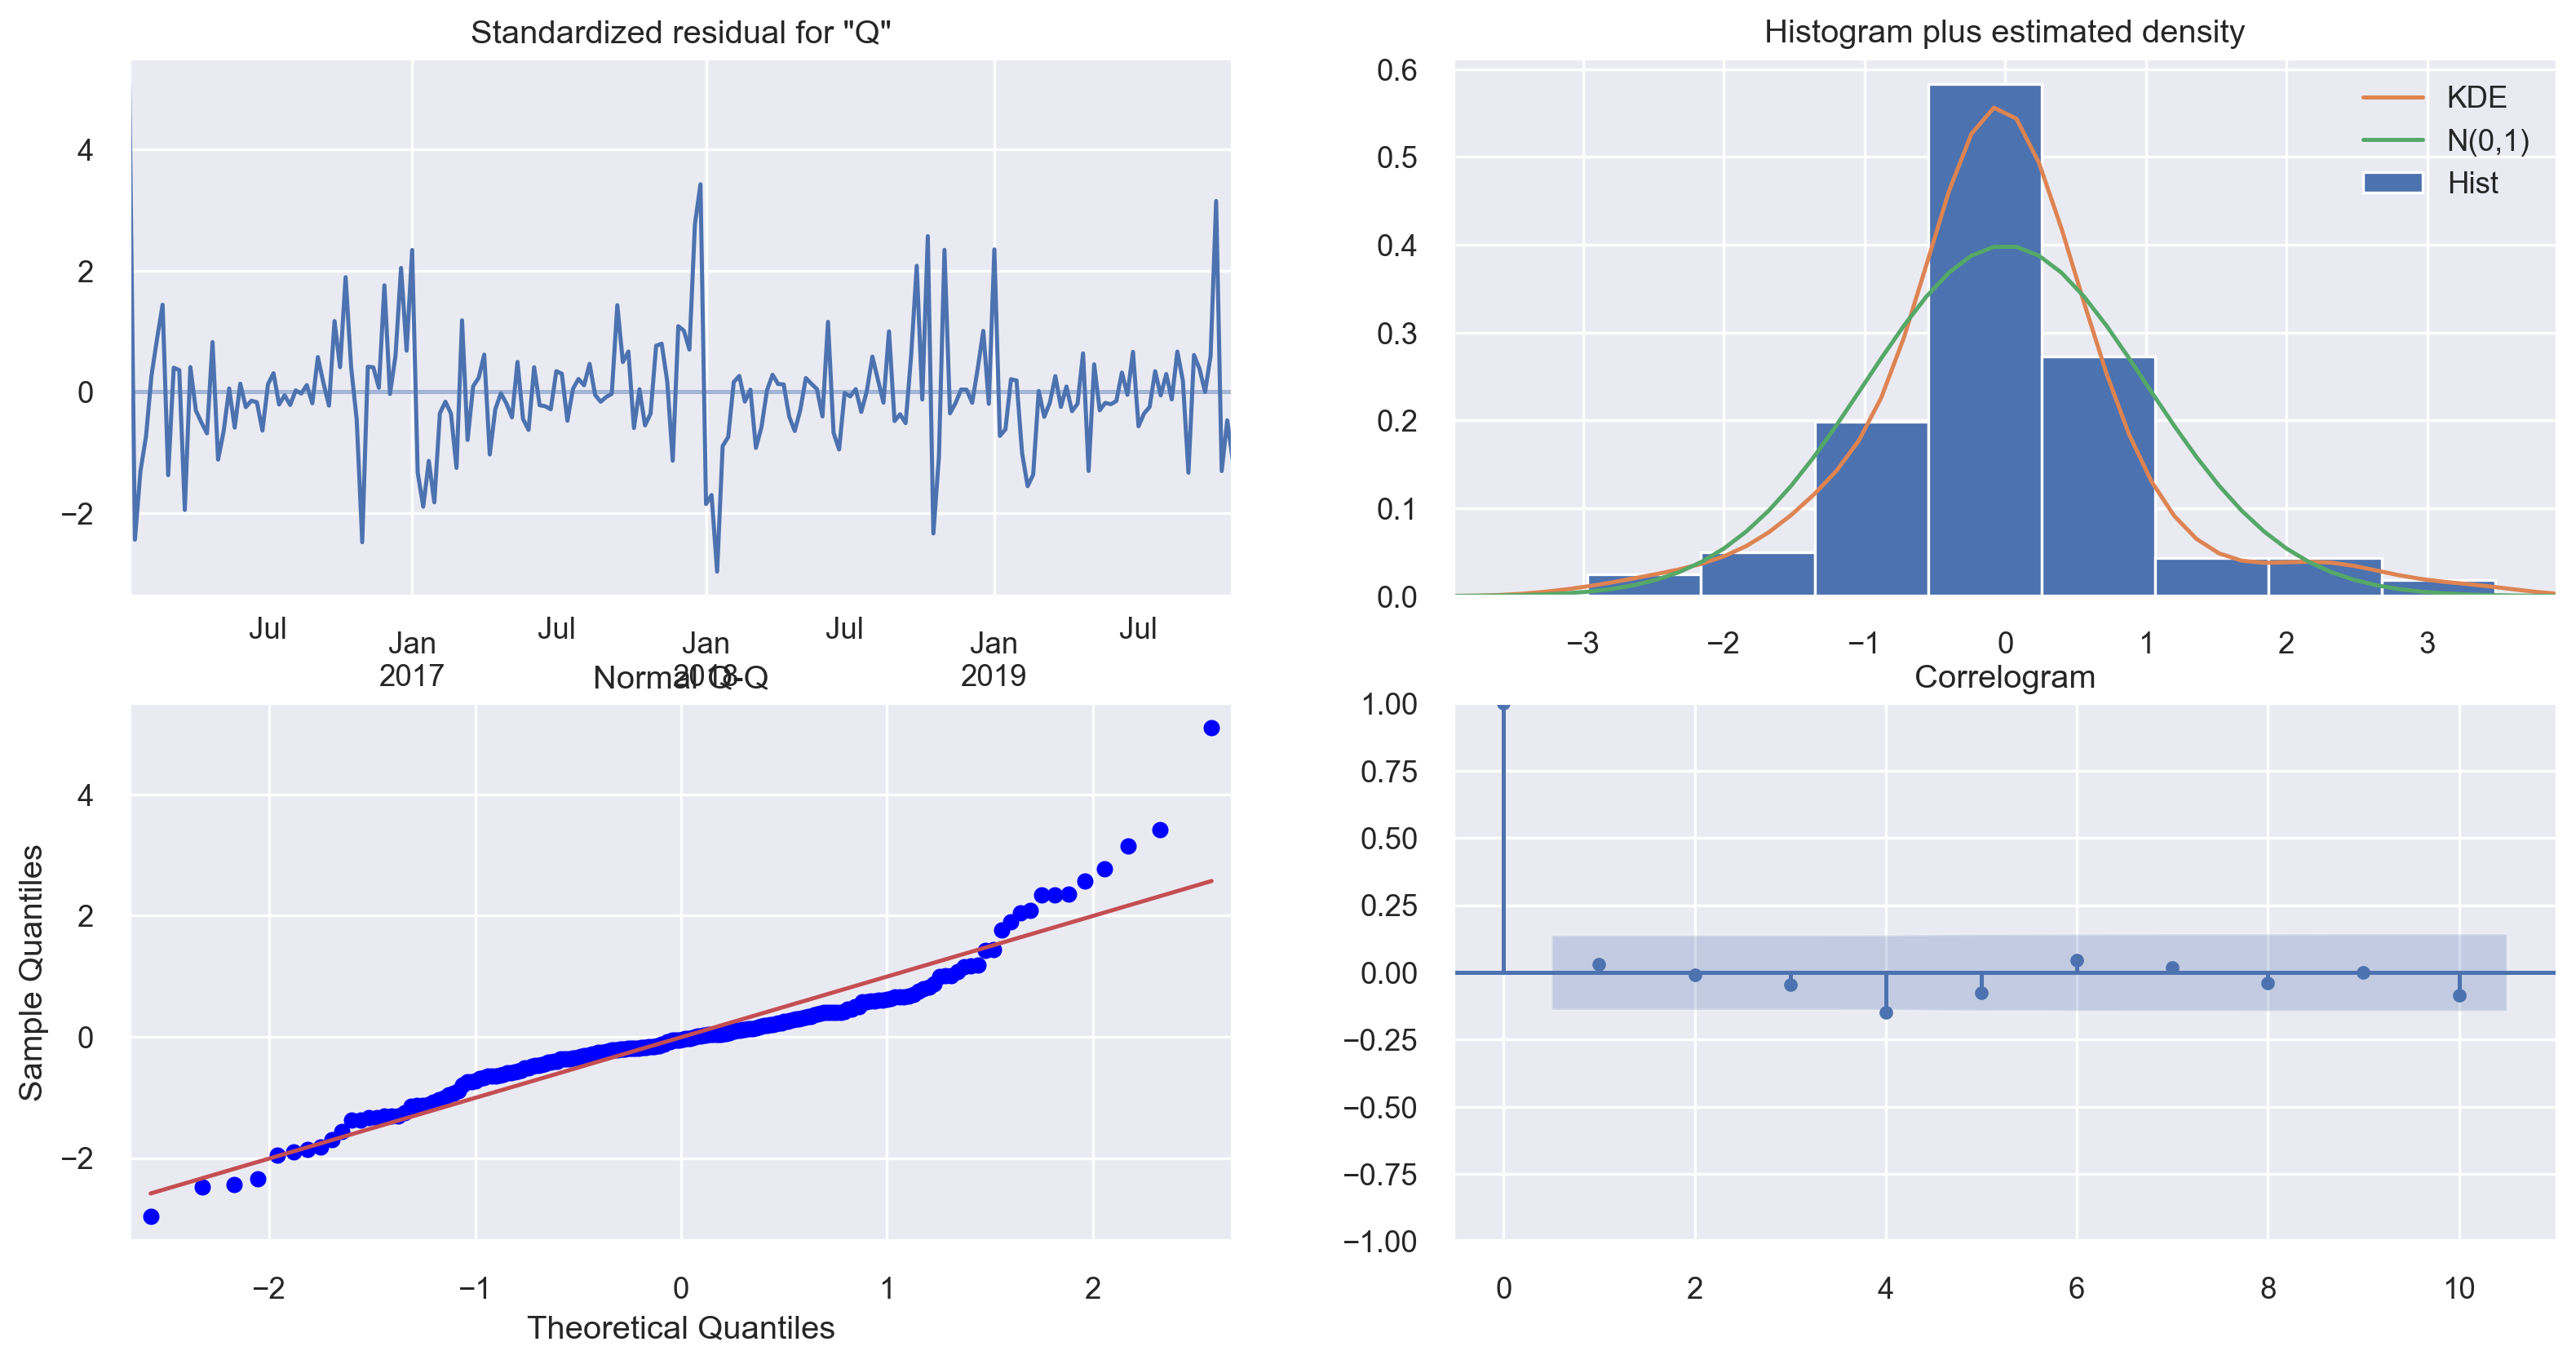

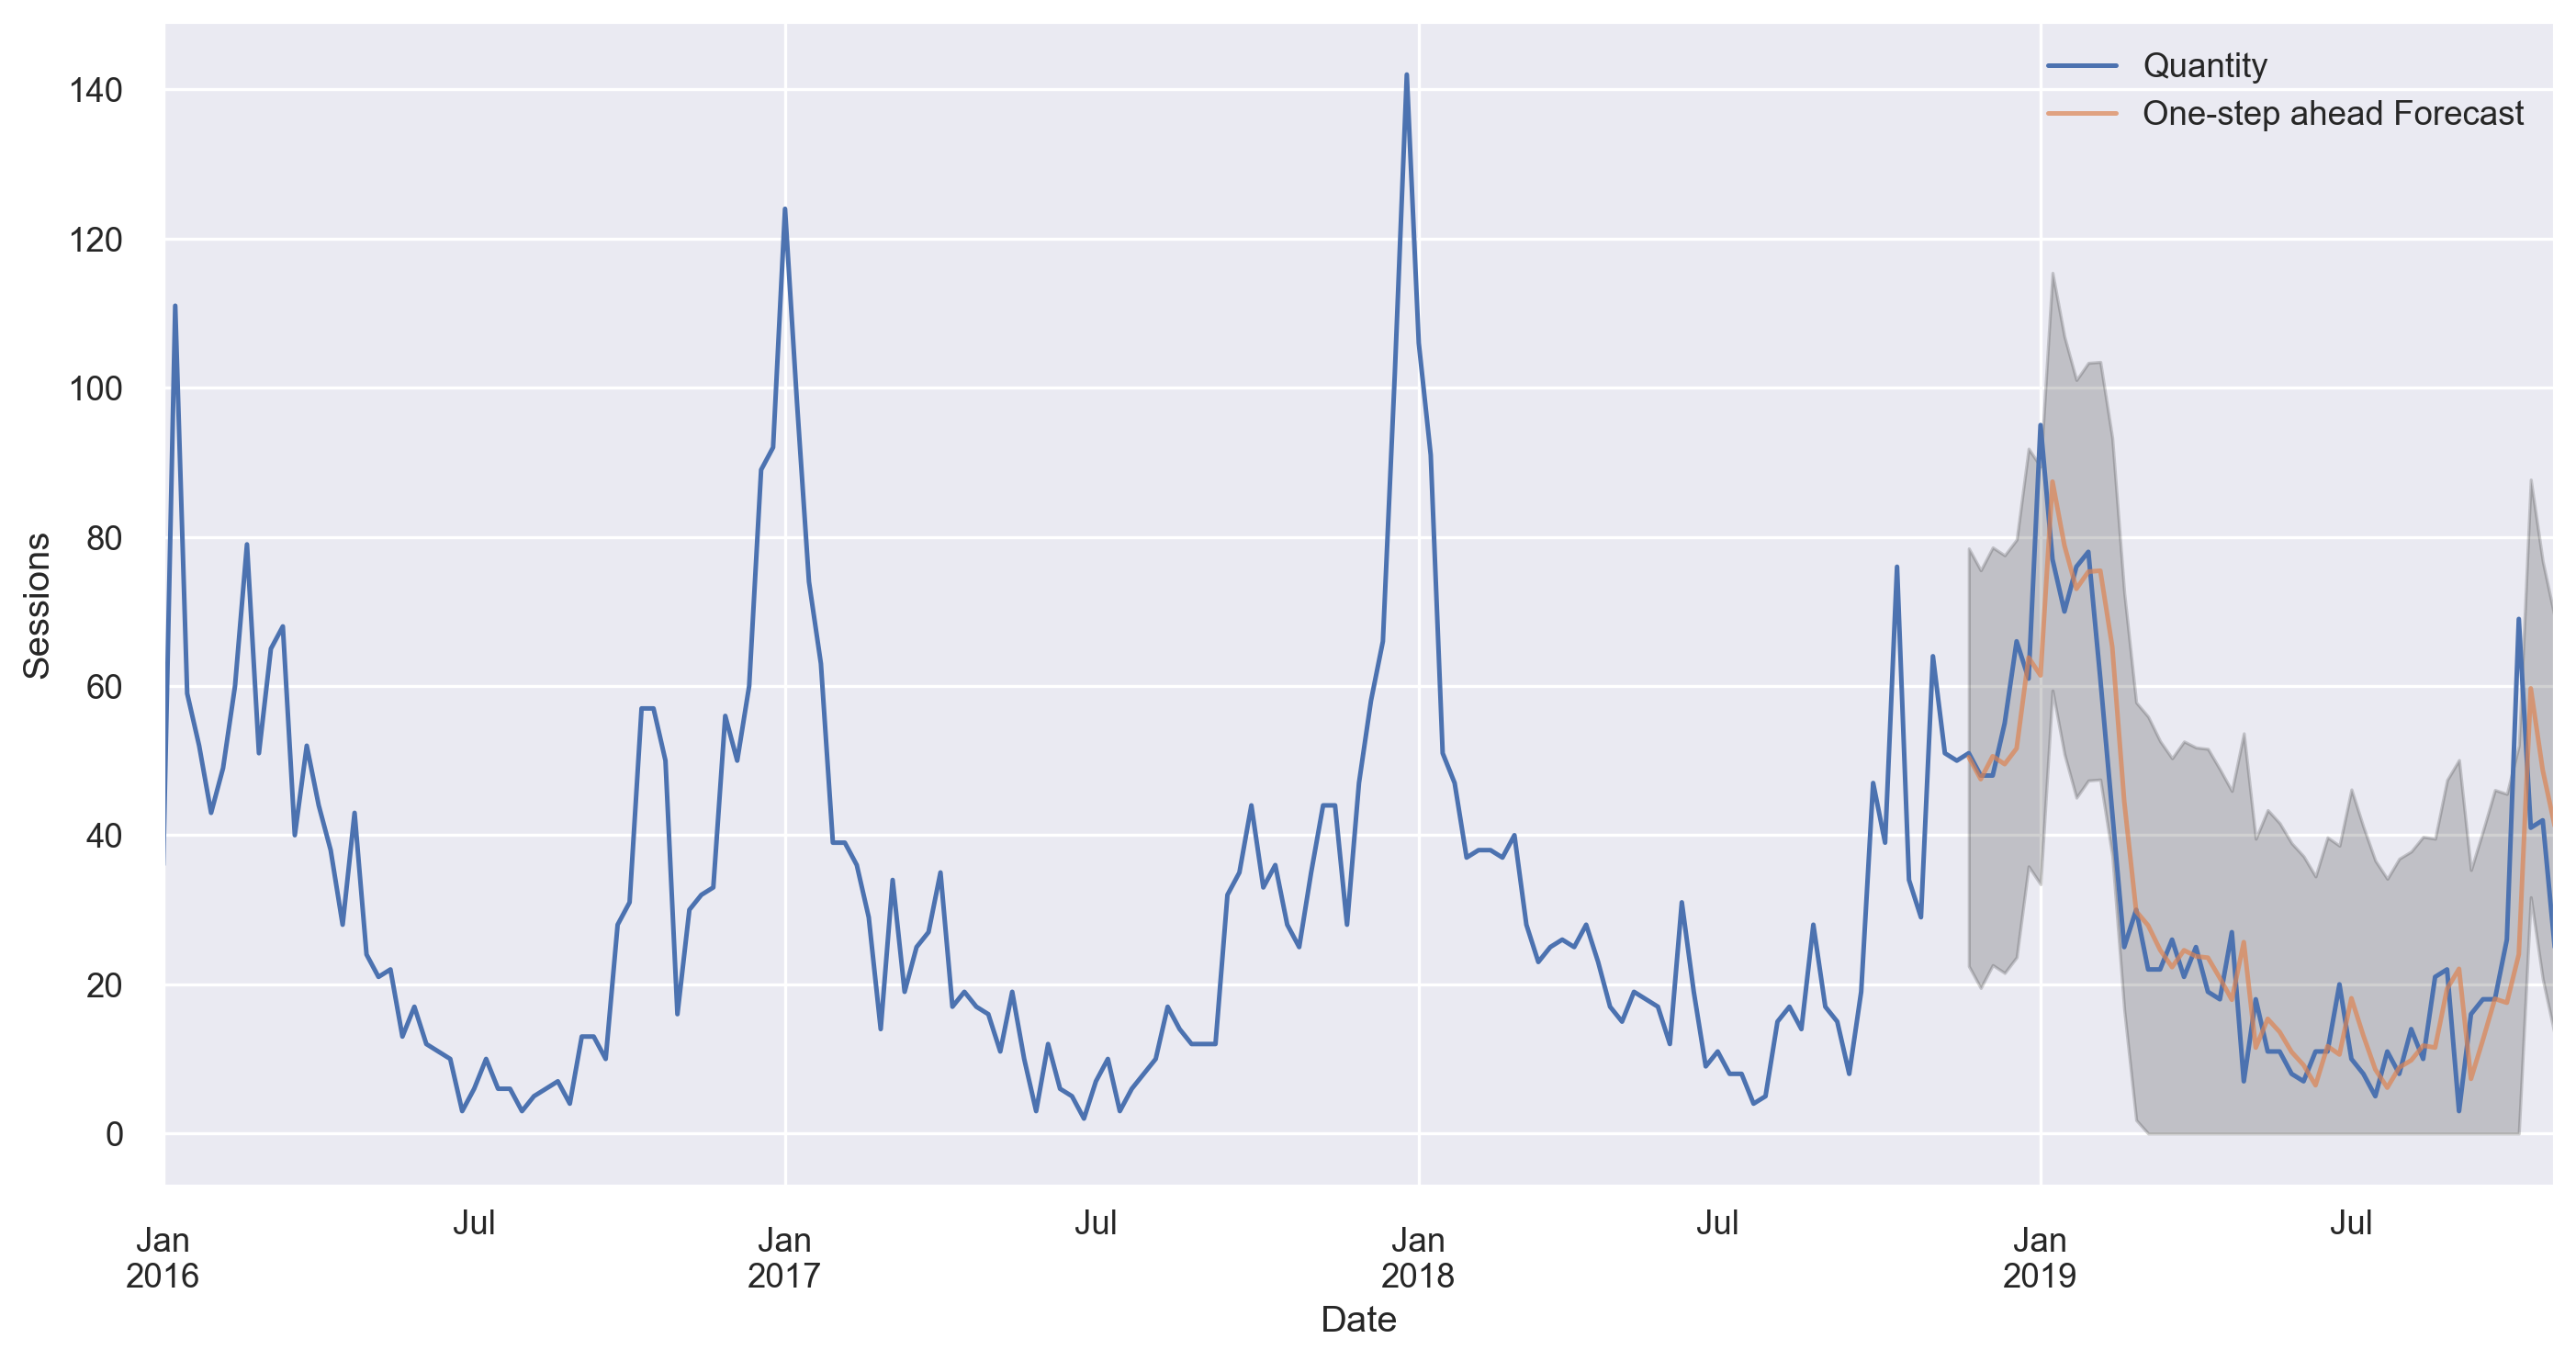

Root Mean Squared Error (RMSE): 11.71
Mean Absolute Error (MAE): 9.66
Median Absolute Error (MedAE): 5.8
Mean Squared Error (MSE): 137.12
Mean Absolute Percentage Error (MAPE): 0.34 %


In [426]:
model = sarima_eva(y,order,seasonal_order,pred_date)

In [98]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()    
    pred_ci['lower Quantity'] = pred_ci['lower Quantity'].apply(lambda x : x if x > 0 else 0)

    pred_uc.predicted_mean = pred_uc.predicted_mean.to_frame()
    pred_uc.predicted_mean['predicted_mean'] = pred_uc.predicted_mean['predicted_mean'].apply(lambda x : x if x > 0 else 0)
    pred_uc.predicted_mean = pred_uc.predicted_mean.squeeze()
    
    ax = y.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.columns.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

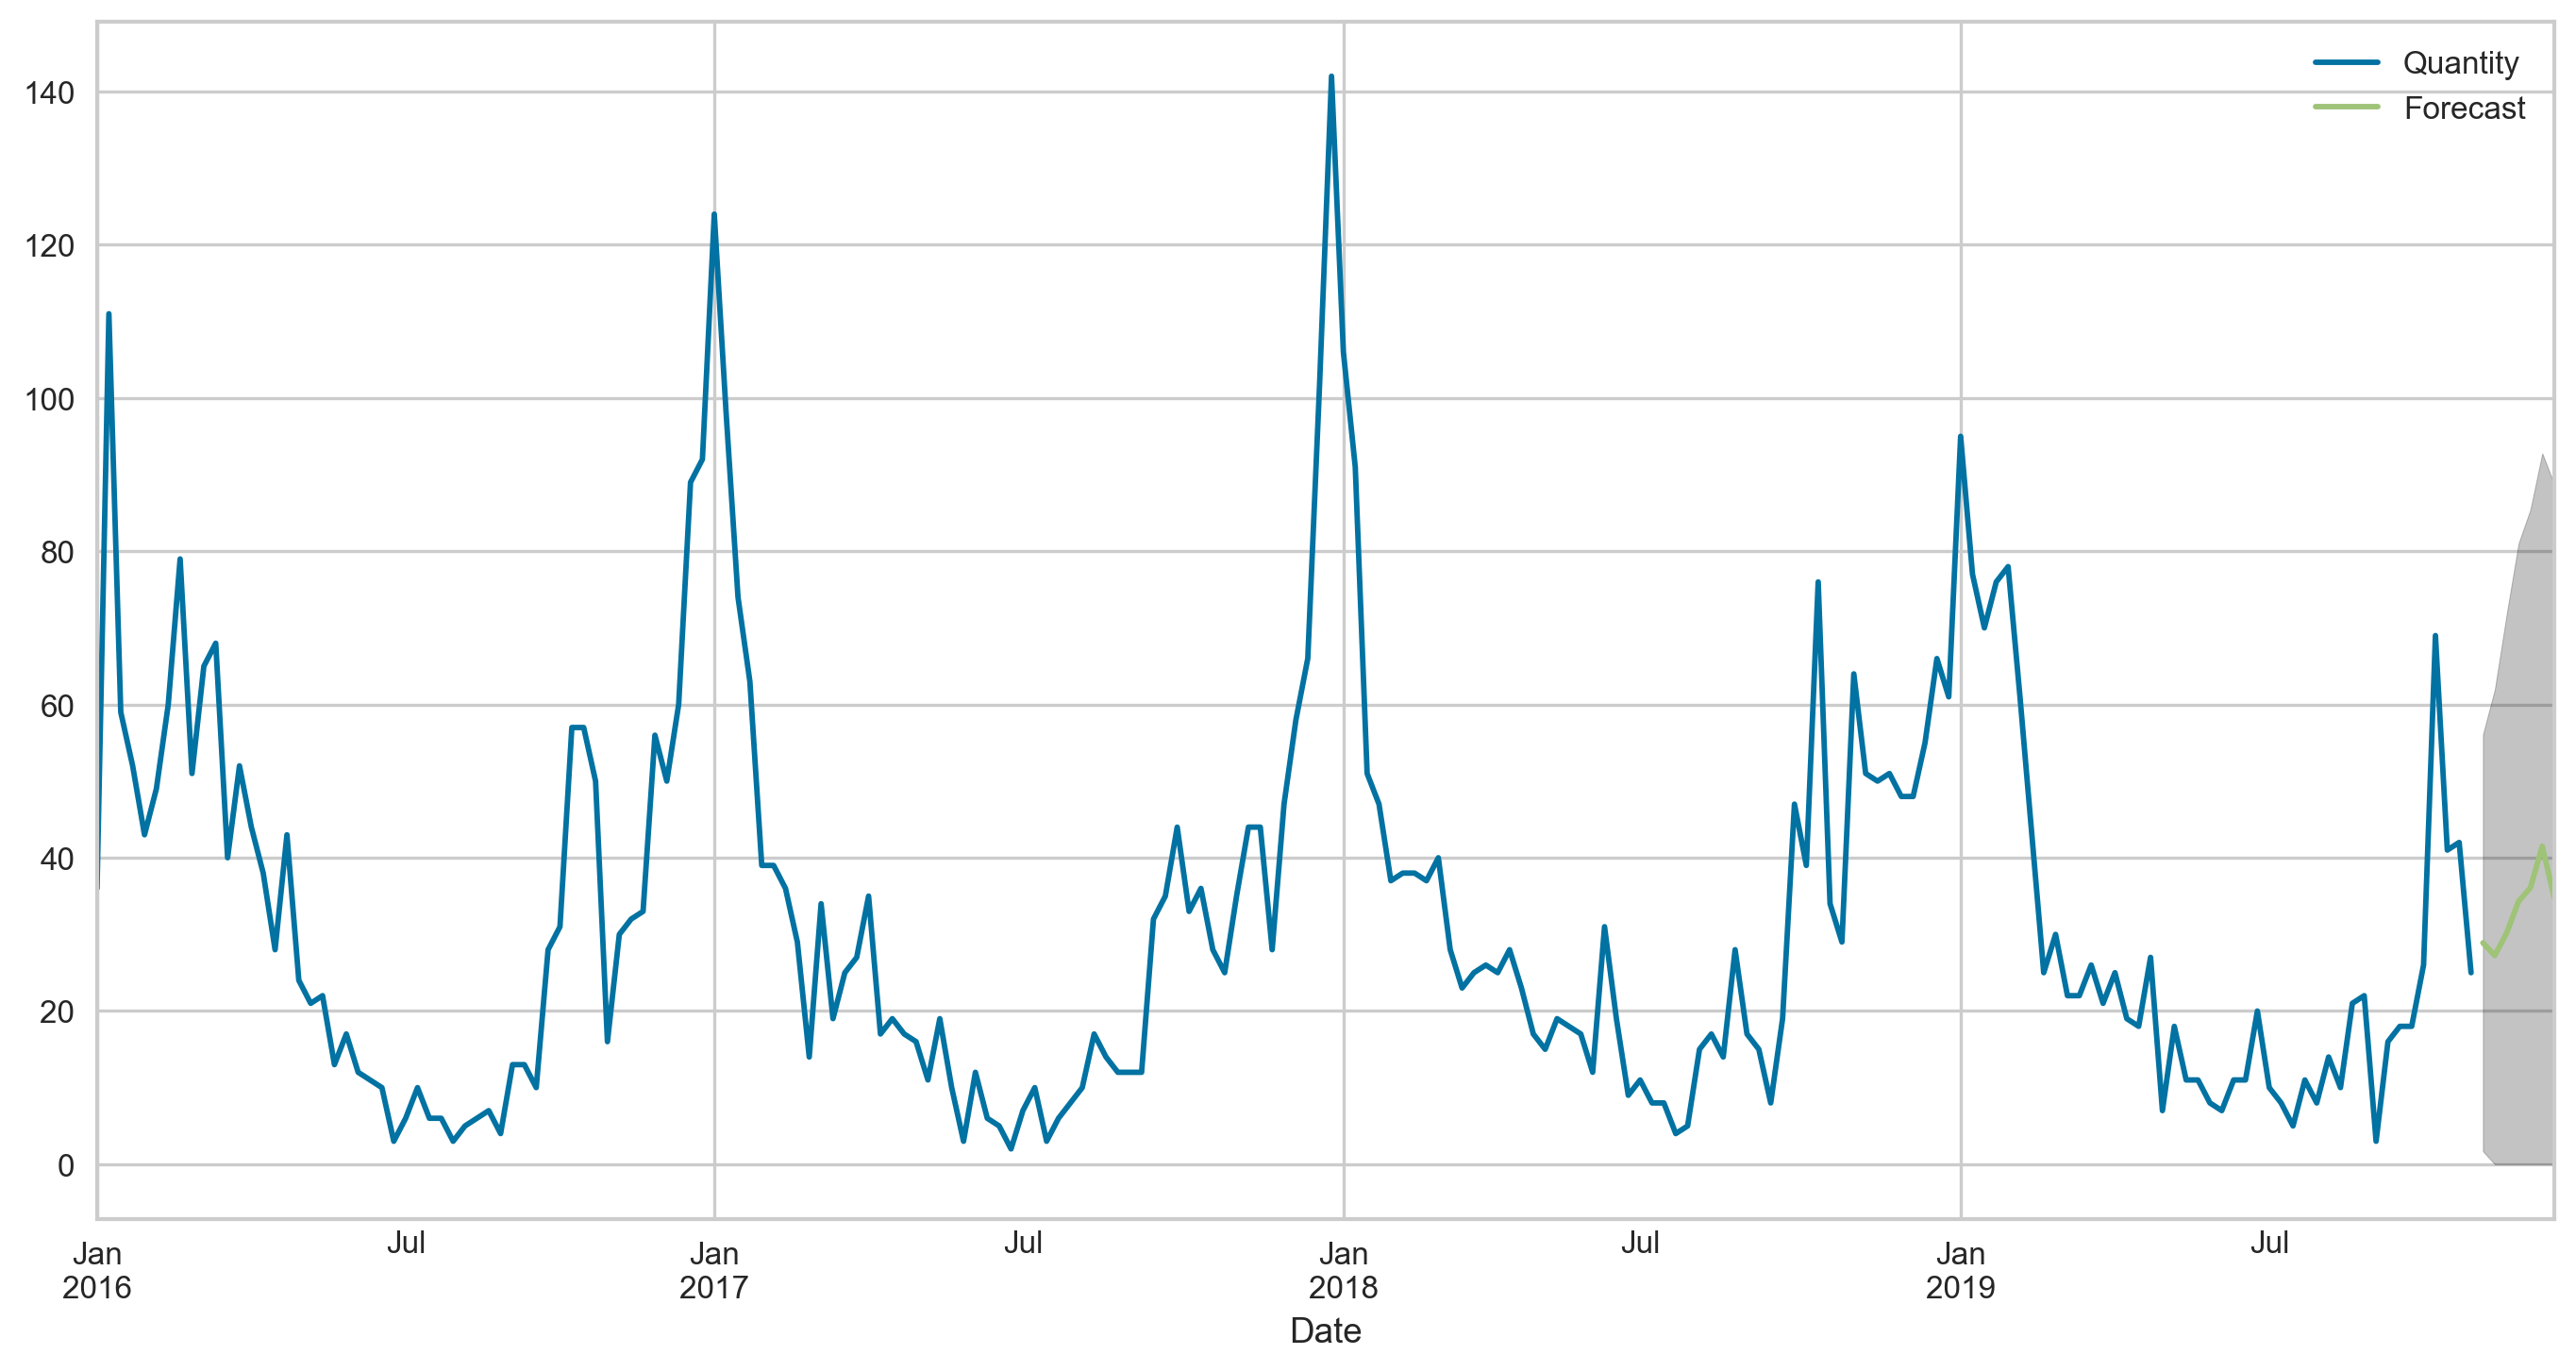

Date  Predicted_Mean  Lower Bound  Upper Bound
0 2019-11-10       28.895671     1.702127    56.089214
1 2019-11-17       27.236053     0.000000    61.950152
2 2019-11-24       30.182964     0.000000    71.772733
3 2019-12-01       34.302421     0.000000    81.012997
4 2019-12-08       36.082533     0.000000    85.451615

In [107]:
final_table = forecast(model,7,y)
final_table.head()

## Pipeline for forecasting

In [144]:
df_SARIMA = df[['Quantity', 'Date', 'Point-of-Sale_ID', 'ProductName_ID']]
df_SARIMA['Date'] = pd.to_datetime(df_SARIMA['Date'])

In [439]:
#Empty dataframe to store forecasting results
df_summary = pd.DataFrame([0, 0, 0, 0, 0, 0], 
                          index=['Date', 'Actual', 'Forecast', 'Benchmark', 'POS', 'Product']).T
df_summary

Date  Actual  Forecast  Benchmark  POS  Product
0     0       0         0          0    0        0

In [440]:
#Empty dataframe to store forecasting accuracy metrics
df_metrics =  pd.DataFrame([0, 0, 0, 0, 0, 0], 
                          index=['POS', 'Product', 'Model_MSE', 'Benchmark_MSE', 'Model_MAPE', 'Benchmark_MAPE']).T
df_metrics

POS  Product  Model_MSE  Benchmark_MSE  Model_MAPE  Benchmark_MAPE
0    0        0          0              0           0               0

In [433]:
def forecast_product_pos(product_name, point_of_sale):
    '''
    This function will forecast sales quantity using SARIMA for a specified product and 
    point-of-sale storing the forecasts and respective metrics in dtaframes df_summary and df_metrics.
    '''
    #filter df for product_name-POS and aggregate weekly quantities
    print(product_name, ' ', point_of_sale)
    df_ = df_SARIMA[(df_SARIMA['Point-of-Sale_ID']==point_of_sale) & (df_SARIMA['ProductName_ID']==product_name)]
    df_ = df_[['Quantity', 'Date']].set_index('Date').resample('W').sum()
    y = df_
    order = (1,1,0)
    seasonal_order = (1, 0, 1, 7)
    if int(len(y.index)*0.25)==0:
        pred_date = y.index[0]
    else:
        pred_date = y.tail(int(len(y.index)*0.25)).index[0]
    print(pred_date)
    to_test = y[pred_date:]['Quantity']
    print(len(y))
    print(len(to_test))
    dfs = sarima_eva_pipeline(y,order,seasonal_order,pred_date)
    df_results, df_Metrics = dfs[0], dfs[1]
    df_results['POS'] = point_of_sale
    df_results['Product'] = product_name
    df_Metrics['POS'] = point_of_sale
    df_Metrics['Product'] = product_name
    return pd.concat([df_summary,df_results]), pd.concat([df_metrics,df_Metrics])

## Loop through all points-of-sale and products to evaluate model results

In [292]:
#Storing top 10 products and POS
top10_prod = pd.DataFrame(df_SARIMA.groupby(["ProductName_ID"])['Quantity'].sum()).sort_values(by='Quantity', ascending=False)[:10].index.tolist()
top10_pos = pd.DataFrame(df_SARIMA.groupby(["Point-of-Sale_ID"])['Quantity'].sum()).sort_values(by='Quantity', ascending=False)[:10].index.tolist()


In [441]:
for pos in top10_pos:
    for product in top10_prod:
        result = forecast_product_pos(product, pos)
        df_summary, df_metrics = result[0], result[1]

1277   292
2018-11-25 00:00:00
201
50
2609   292
2018-11-25 00:00:00
201
50
481   292
2018-11-25 00:00:00
201
50
993   292
2018-11-25 00:00:00
201
50
1147   292
2018-11-25 00:00:00
201
50
1234   292
2018-11-25 00:00:00
201
50
2802   292
2018-11-25 00:00:00
201
50
847   292
2018-11-25 00:00:00
201
50
226   292
2018-11-25 00:00:00
201
50
1422   292
2018-11-25 00:00:00
201
50
1277   78
2018-11-25 00:00:00
201
50
2609   78
2018-11-25 00:00:00
201
50
481   78
2018-11-25 00:00:00
201
50
993   78
2018-11-25 00:00:00
201
50
1147   78
2018-11-25 00:00:00
201
50
1234   78
2018-11-25 00:00:00
201
50
2802   78
2018-11-25 00:00:00
201
50
847   78
2018-11-25 00:00:00
201
50
226   78
2018-11-25 00:00:00
201
50
1422   78
2018-11-25 00:00:00
201
50
1277   280
2018-11-25 00:00:00
201
50
2609   280
2018-11-25 00:00:00
201
50
481   280
2018-11-25 00:00:00
201
50
993   280
2018-11-25 00:00:00
201
50
1147   280
2018-11-25 00:00:00
201
50
1234   280
2018-11-25 00:00:00
201
50
2802   280
2018-11-25 00:00:00
2

In [435]:
result = forecast_product_pos('481', '1')
df_summary, df_metrics = result[0], result[1]

481   1
2018-11-25 00:00:00
201
50


<AxesSubplot:>

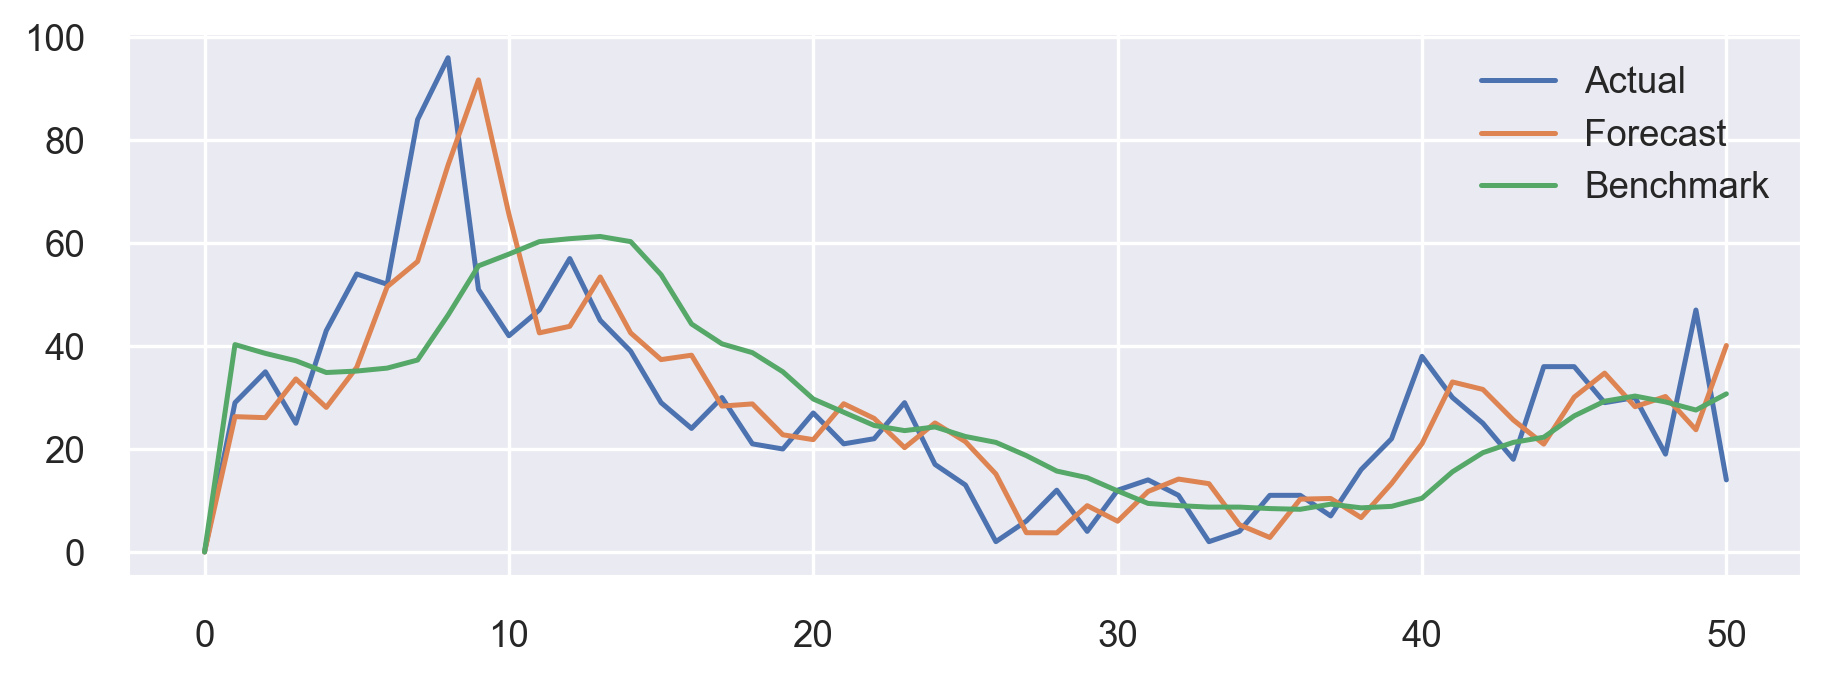

In [437]:
df_summary[['Actual', 'Forecast', 'Benchmark']].reset_index().drop(columns='index').plot()

<AxesSubplot:>

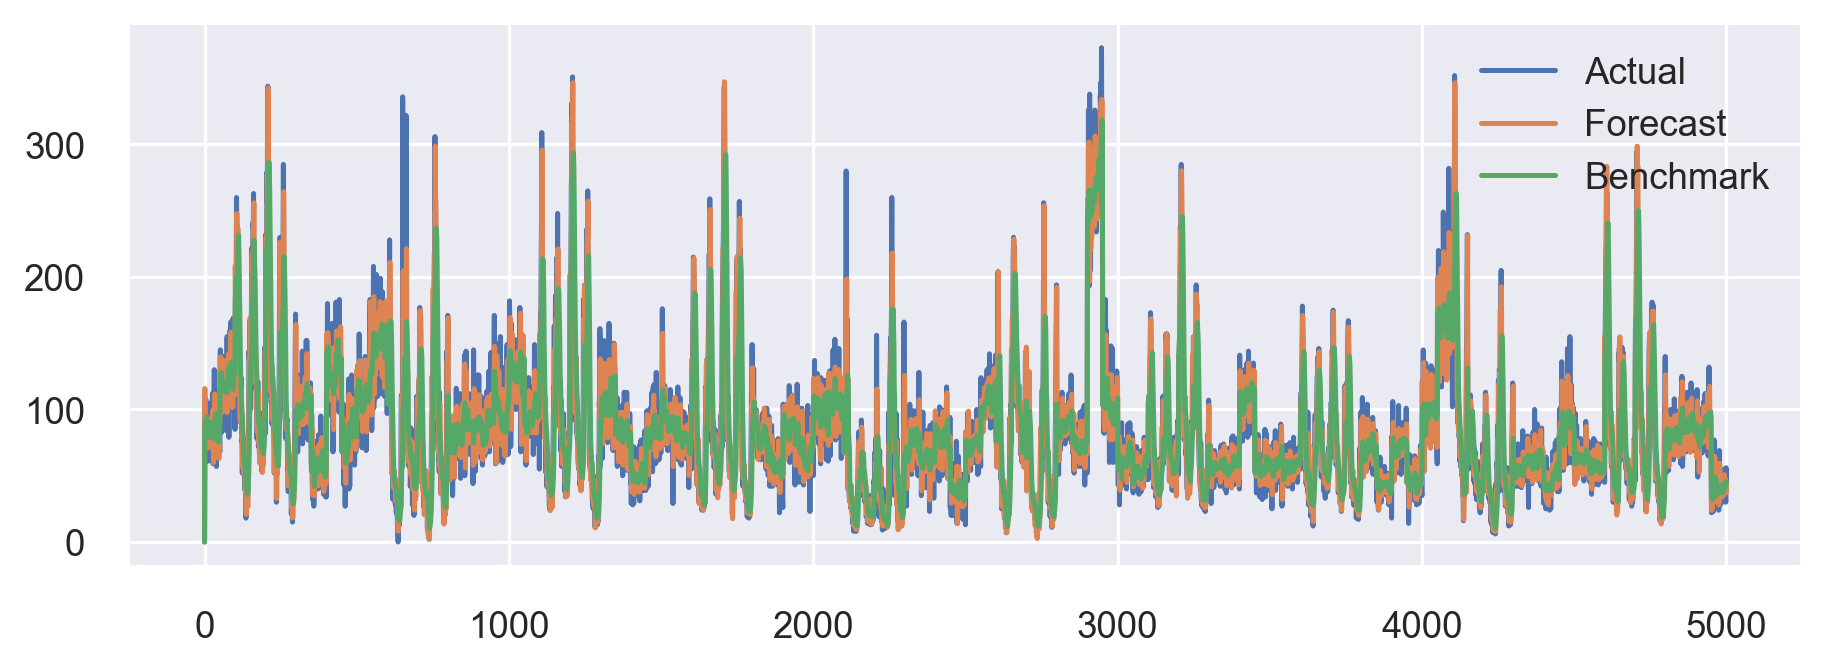

In [442]:
df_summary[['Actual', 'Forecast', 'Benchmark']].reset_index().drop(columns='index').plot()

<AxesSubplot:>

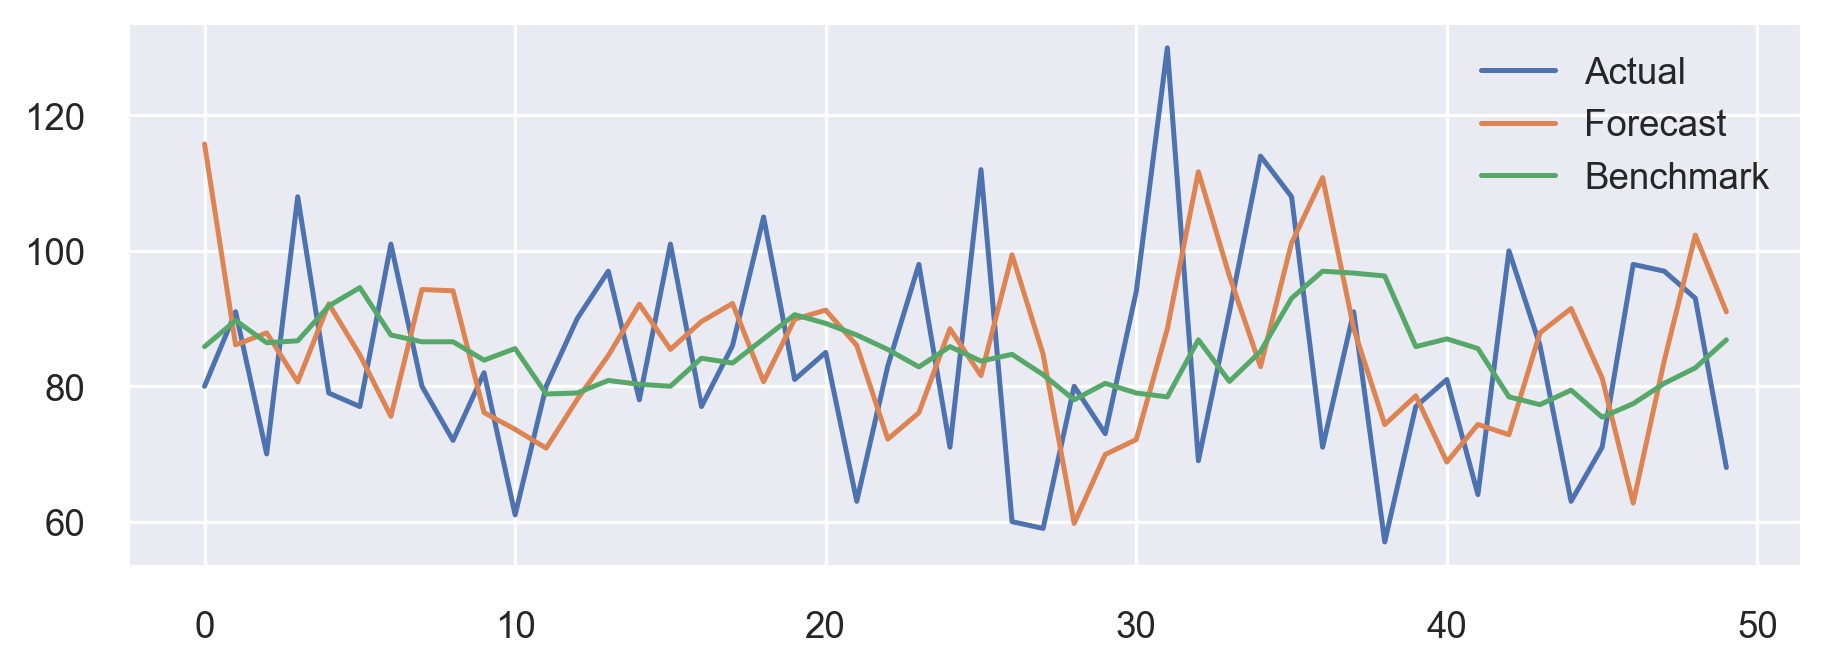

In [450]:
df_summary[(df_summary['POS']=='292') & (df_summary['Product']=='1277')][['Actual', 'Forecast', 'Benchmark']].reset_index().drop(columns='index').plot()

In [443]:
df_metrics

POS Product   Model_MSE  Benchmark_MSE  Model_MAPE  Benchmark_MAPE
0     0       0    0.000000       0.000000    0.000000        0.000000
0   292    1277  435.419787     316.624898    0.217869        0.181769
0   292    2609  579.630254     514.972653    0.167087        0.154600
0   292     481  598.463897    1490.588571    0.215308        0.327265
0   292     993  563.344405    1319.684490    0.159380        0.237284
..  ...     ...         ...            ...         ...             ...
0   359    1234  415.405387    1026.291020    0.217090        0.372005
0   359    2802  231.944312     198.380408    0.168937        0.154633
0   359     847  394.374523     298.149388    0.193770        0.162820
0   359     226  347.043209     276.477959    0.178086        0.166950
0   359    1422  169.233618     144.872653    0.251190        0.253529

[101 rows x 6 columns]

In [464]:
df_summary.to_csv('/Users/rui.soromenho/Downloads/SARIMA_results.csv')

In [465]:
df_metrics.to_csv('/Users/rui.soromenho/Downloads/SARIMA_metrics')